## 加载项目库文件

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

## 加载数据
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

In [3]:
train_df = pd.read_csv('train.csv')
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')

/home/z1yuan/anaconda3/envs/robot-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 数据项
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are  closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g.    "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#### 训练集数据

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
train_df.columns[train_df.isnull().sum() != 0]

Index([], dtype='object')

In [8]:
train_df[(train_df.Open==0)& (train_df.Sales==0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1
3105,876,3,2015-07-29,0,0,0,1,0,1
3636,292,2,2015-07-28,0,0,0,1,0,1
4220,876,2,2015-07-28,0,0,0,1,0,1
4751,292,1,2015-07-27,0,0,0,1,0,1
5335,876,1,2015-07-27,0,0,0,1,0,1


In [9]:
train_df[(train_df.Open!=0)& (train_df.Sales==0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0
340348,227,4,2014-09-11,0,0,1,0,0,0
340860,835,4,2014-09-11,0,0,1,0,0,0
341795,835,3,2014-09-10,0,0,1,0,0,0
346232,548,5,2014-09-05,0,0,1,1,0,1
346734,28,4,2014-09-04,0,0,1,1,0,0


#### 店面数据

In [10]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [13]:
store_df.columns[store_df.isnull().sum() != 0]

Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')

In [14]:
store_df[store_df.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [15]:
store_df[store_df.CompetitionOpenSinceMonth.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [16]:
store_df[store_df.Promo2 == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


In [17]:
store_df[store_df.Promo2SinceWeek.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


#### 测试集数据

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [19]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [20]:
test_df.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [21]:
test_df[test_df.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


## 数据合并

#### 合并 train_df 和 store_df
using pandas.merge function to merge train_df, test_df and store_df.

In [22]:
train_store_df = pd.merge(train_df, store_df, on='Store')
test_store_df = pd.merge(test_df, store_df, on='Store')

In [23]:
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [24]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

In [25]:
test_store_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [26]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null object
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          40992 non-null float64
CompetitionOpenSinceMonth    25872 non-null float64
CompetitionOpenSinceYear     25872 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                23856 non-null object
dtypes: float64(6), int6

### 数据清洁

`train_store_df`:
- incorrect data type: `Date`
- missing data : `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

`test_store_df`:
- incorrect data type: `Date`
- missing data : `Open`, `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

### 训练数据处理 : 

#### 处理非标准数据项 `Date`
Using pandas.to_datetime to do it.

In [27]:
train_store_df.Date = pd.to_datetime(train_store_df.Date)

In [28]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 no

#### 处理有丢失数据项 : `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

利用 pandas.DataFrame.fillna 填充0到 `CompetitionDistance`,`CompetitionOpenSinceMonth`,`CompetitionOpenSinceYear`,`Promo2SinceWeek`,`Promo2SinceYear`,`PromoInterval`.


In [29]:
train_store_df.CompetitionDistance.fillna(0, inplace=True)
train_store_df.CompetitionOpenSinceMonth.fillna(0, inplace=True)
train_store_df.CompetitionOpenSinceYear.fillna(0, inplace=True)

In [30]:
train_store_df.Promo2SinceWeek.fillna(0, inplace=True)
train_store_df.Promo2SinceYear.fillna(0, inplace=True)
train_store_df.PromoInterval.fillna(0, inplace=True)

In [31]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

In [32]:
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [33]:
train_store_df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
419601,460,1,2013-10-14,3080,330,1,0,0,0,a,a,34050.0,4.0,2008.0,0,0.0,0.0,0
20128,22,3,2013-02-13,3199,380,1,0,0,1,a,a,1040.0,0.0,0.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
503992,553,4,2014-01-09,6645,560,1,1,0,0,c,a,3040.0,9.0,2002.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
141340,156,4,2013-10-03,0,0,0,0,a,0,a,a,2020.0,2.0,2011.0,1,14.0,2011.0,"Mar,Jun,Sept,Dec"
974680,1069,3,2014-04-30,9576,1195,1,1,0,1,a,c,18050.0,0.0,0.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


### 处理测试集`test_store_df`:

#### 使用pandas.to_datetime 处理非标准数据格式 `Date`


In [34]:
test_store_df.Date = pd.to_datetime(test_store_df.Date)

In [35]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          40992 non-null float64
CompetitionOpenSinceMonth    25872 non-null float64
CompetitionOpenSinceYear     25872 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                23856 non-null object
dtypes: datetime

#### 使用pandas.DataFrame.fillna 将`Open`的缺失部分补成1

In [36]:
test_store_df.Open.fillna(1, inplace=True)

In [37]:
#test
test_store_df.CompetitionDistance.fillna(0, inplace=True)
test_store_df.CompetitionOpenSinceMonth.fillna(0, inplace=True)
test_store_df.CompetitionOpenSinceYear.fillna(0, inplace=True)

test_store_df.Promo2SinceWeek.fillna(0, inplace=True)
test_store_df.Promo2SinceYear.fillna(0, inplace=True)
test_store_df.PromoInterval.fillna(0, inplace=True)

In [38]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
dtypes: datetime

In [39]:
test_store_df[test_store_df.Store == 622]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
22992,480,622,4,2015-09-17,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22993,1336,622,3,2015-09-16,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22994,2192,622,2,2015-09-15,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22995,3048,622,1,2015-09-14,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22996,3904,622,7,2015-09-13,0.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22997,4760,622,6,2015-09-12,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22998,5616,622,5,2015-09-11,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22999,6472,622,4,2015-09-10,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
23000,7328,622,3,2015-09-09,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
23001,8184,622,2,2015-09-08,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0


## 数据可视化探索

#### Sales

In [40]:
train_store_df.Sales.describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales')

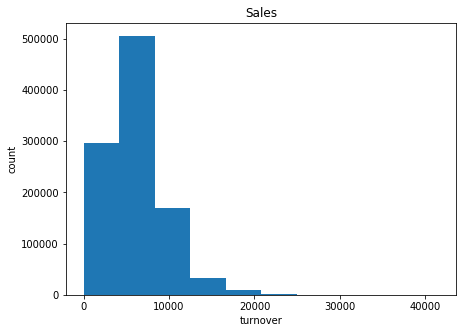

In [41]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

Text(0.5, 1.0, 'Sales')

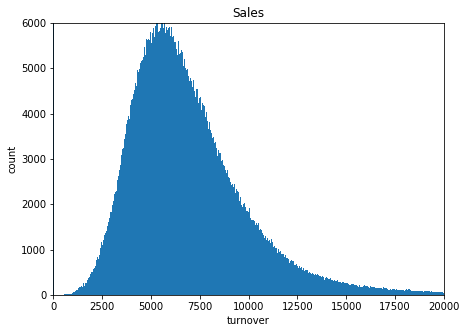

In [42]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales, bins=1000)
plt.xlim(0,20000)
plt.ylim(0,6000)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

Text(0.5, 1.0, 'Log(Sales)')

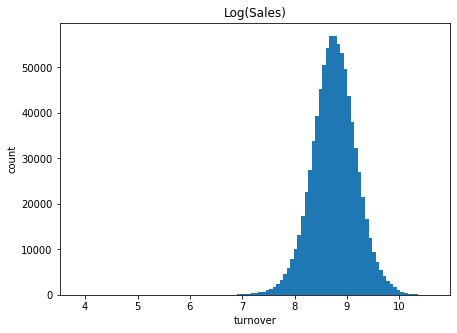

In [43]:
plt.figure(figsize=(7,5))
plt.hist(np.log1p(train_store_df[train_store_df.Sales != 0].Sales), bins= 100)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Log(Sales)")

Sales is positive skewed distribution。

#### Date

In [44]:
train_store_df.Date.describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

In [45]:
train_store_df.Date.unique()

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

In [46]:
test_store_df.Date.describe()

count                   41088
unique                     48
top       2015-09-15 00:00:00
freq                      856
first     2015-08-01 00:00:00
last      2015-09-17 00:00:00
Name: Date, dtype: object

In [47]:
test_store_df.Date.unique()

array(['2015-09-17T00:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-09-15T00:00:00.000000000', '2015-09-14T00:00:00.000000000',
       '2015-09-13T00:00:00.000000000', '2015-09-12T00:00:00.000000000',
       '2015-09-11T00:00:00.000000000', '2015-09-10T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-09-08T00:00:00.000000000',
       '2015-09-07T00:00:00.000000000', '2015-09-06T00:00:00.000000000',
       '2015-09-05T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-03T00:00:00.000000000', '2015-09-02T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-08-30T00:00:00.000000000', '2015-08-29T00:00:00.000000000',
       '2015-08-28T00:00:00.000000000', '2015-08-27T00:00:00.000000000',
       '2015-08-26T00:00:00.000000000', '2015-08-25T00:00:00.000000000',
       '2015-08-24T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-08-22T00:00:00.000000000', '2015-08-21

The Date in train data is from 2013-01-01 to 2015-07-31, while the date in test data is from 2015-08-01 to 2015-09-17.

#### Customers

In [48]:
train_store_df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

Text(0.5, 1.0, 'Customers')

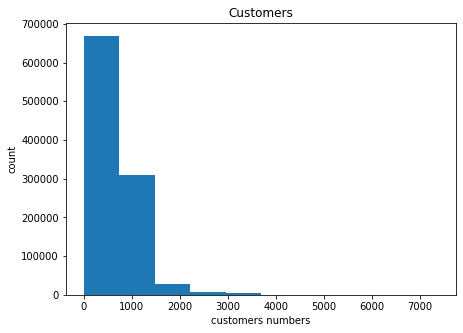

In [49]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

Text(0.5, 1.0, 'Customers')

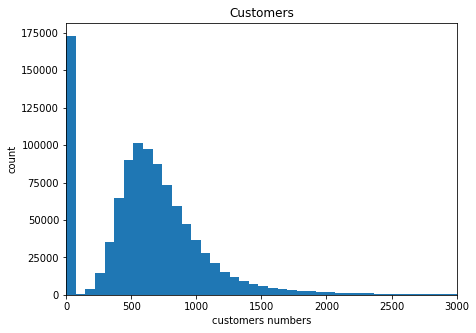

In [50]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers, bins=100)
plt.xlim(0,3000)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

Customers has a lot of zero values and is positive skewed distribution.

#### CompetitionDistance

In [51]:
train_store_df.CompetitionDistance.describe()

count    1.017209e+06
mean     5.415982e+03
std      7.710253e+03
min      0.000000e+00
25%      7.000000e+02
50%      2.320000e+03
75%      6.880000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

Text(0.5, 1.0, 'CompetitionDistance')

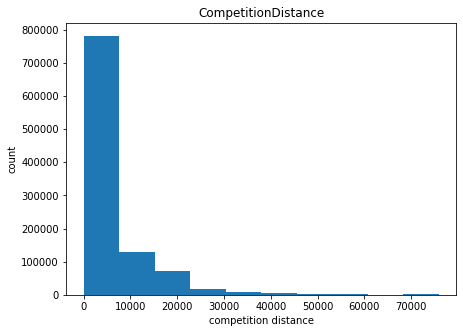

In [52]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionDistance)
plt.xlabel("competition distance")
plt.ylabel("count")
plt.title("CompetitionDistance")

CompetitionDistance is positive skewed distribution.

#### CompetitionOpenSinceMonth

Text(0.5, 1.0, 'CompetitionOpenSinceMonth')

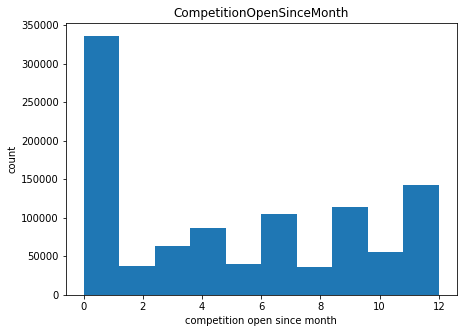

In [53]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionOpenSinceMonth)
plt.xlabel("competition open since month")
plt.ylabel("count")
plt.title("CompetitionOpenSinceMonth")

In [54]:
train_store_df.CompetitionOpenSinceMonth.value_counts()

0.0     323348
9.0     114254
4.0      87076
11.0     84455
3.0      63548
7.0      59434
12.0     57896
10.0     55622
6.0      45444
5.0      39608
2.0      37886
8.0      36186
1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

The zero value accounts for the majority.

#### CompetitionOpenSinceYear

In [55]:
train_store_df.CompetitionOpenSinceYear.unique()

array([ 2008.,  2007.,  2006.,  2009.,  2015.,  2013.,  2014.,  2000.,
        2011.,     0.,  2010.,  2005.,  1999.,  2003.,  2012.,  2004.,
        2002.,  1961.,  1995.,  2001.,  1990.,  1994.,  1900.,  1998.])

In [56]:
train_store_df.CompetitionOpenSinceYear.value_counts()

0.0       323348
2013.0     75426
2012.0     74299
2014.0     63732
2005.0     56564
2010.0     51258
2011.0     49396
2009.0     49396
2008.0     48476
2007.0     43744
2006.0     42802
2015.0     35060
2002.0     24882
2004.0     19804
2003.0     16794
2001.0     14704
2000.0      9236
1999.0      7352
1990.0      4710
1994.0      1884
1995.0      1700
1998.0       942
1961.0       942
1900.0       758
Name: CompetitionOpenSinceYear, dtype: int64

The zero value accounts for the majority.

#### Promo2SinceWeek

In [57]:
train_store_df.Promo2SinceWeek.unique()

array([  0.,  13.,  14.,   1.,  45.,  40.,  26.,  22.,   5.,   6.,  10.,
        31.,  37.,   9.,  39.,  27.,  18.,  35.,  23.,  48.,  36.,  50.,
        44.,  49.,  28.])

In [58]:
train_store_df.Promo2SinceWeek.value_counts()

0.0     508031
14.0     72990
40.0     62598
31.0     39976
10.0     38828
5.0      35818
37.0     32786
1.0      32418
13.0     29820
45.0     29268
22.0     28694
18.0     27318
35.0     22814
9.0      12452
27.0      9626
36.0      9236
48.0      8294
39.0      4732
23.0      4342
44.0      2642
28.0       942
50.0       942
6.0        942
26.0       942
49.0       758
Name: Promo2SinceWeek, dtype: int64

The zero value accounts for the majority.

#### Promo2SinceYear

In [59]:
train_store_df.Promo2SinceYear.unique()

array([    0.,  2010.,  2011.,  2012.,  2009.,  2014.,  2015.,  2013.])

In [60]:
train_store_df.Promo2SinceYear.value_counts()

0.0       508031
2011.0    115056
2013.0    110464
2014.0     79922
2012.0     73174
2009.0     65270
2010.0     56240
2015.0      9052
Name: Promo2SinceYear, dtype: int64

The zero value accounts for the majority.

#### PromoInterval

In [61]:
train_store_df.PromoInterval.unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

In [62]:
train_store_df.PromoInterval.value_counts()

0                   508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

The zero value accounts for the majority. Jan,Apr,Jul,Oct follows the following.

### Construct some new variables

#### Construct new variables `Year`, `Month`, `Day` and `WeekOfYear`  based on `Date` .

In [63]:
#train_store_df
train_store_df['Year'] = train_store_df.Date.dt.year
train_store_df['Month'] = train_store_df.Date.dt.month
train_store_df['Day'] = train_store_df.Date.dt.day
train_store_df['WeekOfYear'] = train_store_df.Date.dt.weekofyear

train_store_df.drop('Date', axis=1, inplace=True)

In [64]:
#test_store_df
test_store_df['Year'] = test_store_df.Date.dt.year
test_store_df['Month'] = test_store_df.Date.dt.month
test_store_df['Day'] = test_store_df.Date.dt.day
test_store_df['WeekOfYear'] = test_store_df.Date.dt.weekofyear

test_store_df.drop('Date', axis=1, inplace=True)

CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code

#### Construct new variables `CompetitionOpen`

In [65]:
#train_store_df
train_store_df['CompetitionOpen'] = 12*(train_store_df.Year - train_store_df.CompetitionOpenSinceYear) + \
                                   (train_store_df.Month - train_store_df.CompetitionOpenSinceMonth)
#test_store_df
test_store_df['CompetitionOpen'] = 12*(test_store_df.Year - test_store_df.CompetitionOpenSinceYear) + \
                                   (test_store_df.Month - test_store_df.CompetitionOpenSinceMonth)

#### Construct new variables `PromoOpen` 

In [66]:
#train_store_df
train_store_df['PromoOpen'] = 12*(train_store_df.Year - train_store_df.Promo2SinceYear) + \
                                 (train_store_df.WeekOfYear - train_store_df.Promo2SinceWeek) / 4.0

train_store_df['PromoOpen'] = train_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
train_store_df.loc[train_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

#test_store_df
test_store_df['PromoOpen'] = 12*(test_store_df.Year - test_store_df.Promo2SinceYear) + \
                                (test_store_df.WeekOfYear - test_store_df.Promo2SinceWeek) / 4.0

test_store_df['PromoOpen'] = test_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
test_store_df.loc[test_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

### Bivariate Analysis

#### Sales & Open

In [67]:
train_store_df[train_store_df.Open == 0].Sales.sum()

0

In [68]:
train_store_df[(train_store_df.Open == 1) & (train_store_df.Sales == 0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen
22589,25,4,0,0,1,0,0,0,c,a,...,0,0.0,0.0,0,2014,2,13,7,130.0,0.00
22590,25,3,0,0,1,0,0,0,c,a,...,0,0.0,0.0,0,2014,2,12,7,130.0,0.00
25212,28,4,0,0,1,1,0,0,a,a,...,1,6.0,2015.0,"Mar,Jun,Sept,Dec",2014,9,4,36,-1.0,0.00
25213,28,3,0,0,1,1,0,1,a,a,...,1,6.0,2015.0,"Mar,Jun,Sept,Dec",2014,9,3,36,-1.0,0.00
25214,28,2,0,0,1,1,0,1,a,a,...,1,6.0,2015.0,"Mar,Jun,Sept,Dec",2014,9,2,36,-1.0,0.00
51491,57,2,0,0,1,1,0,0,d,c,...,0,0.0,0.0,0,2014,7,1,27,1.0,0.00
92570,102,4,0,0,1,0,0,1,a,a,...,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2014,7,24,30,79.0,5.00
92582,102,6,0,0,1,0,0,0,a,a,...,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2014,7,12,28,79.0,4.50
205303,227,4,0,0,1,0,0,0,a,a,...,0,0.0,0.0,0,2014,9,11,37,24177.0,0.00
210424,232,4,0,0,1,1,0,0,c,c,...,1,10.0,2013.0,"Mar,Jun,Sept,Dec",2013,1,24,4,32.0,0.00


Text(0.5, 1.0, 'the sales of open stores')

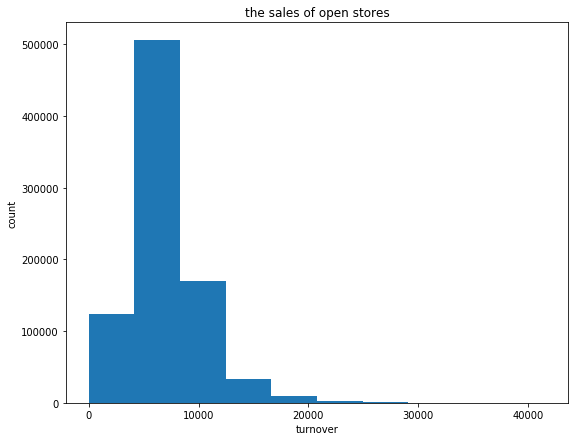

In [69]:
plt.figure(figsize=(9,7))
plt.hist(train_store_df[train_store_df.Open == 1].Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("the sales of open stores")

There are some opened stores which have zero sales.

#### Analysis of sales!=0 and open != 0

In [70]:
train_store_sales_df = train_store_df[(train_store_df.Sales != 0) & (train_store_df.Open != 0)]

Text(0.5, 1, 'Correlation Charts')

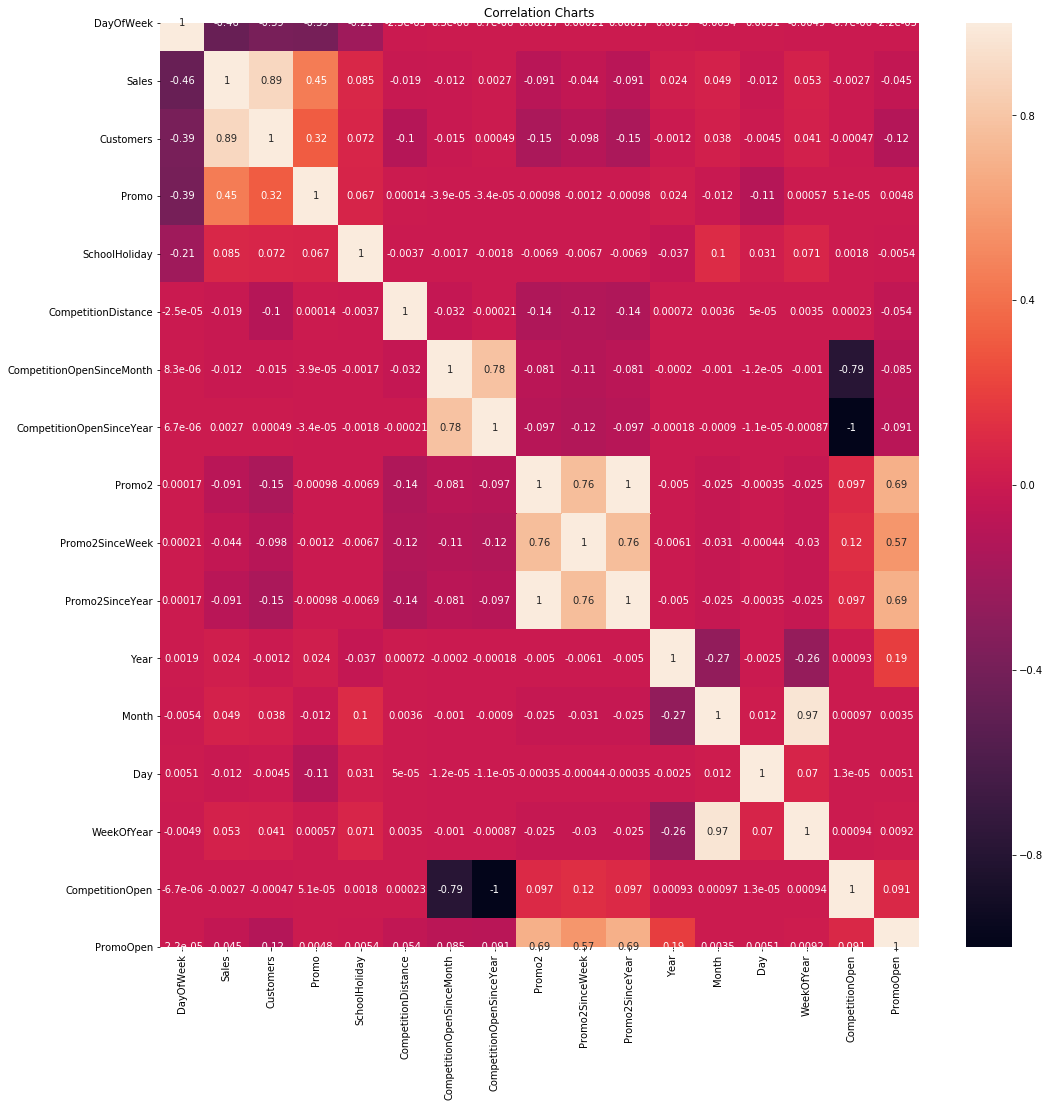

In [71]:
plt.figure(figsize=(17,17))
corr_mat = train_store_df.drop(['Store','Open'], axis=1).corr()
sns.heatmap(corr_mat,annot=True)
plt.title('Correlation Charts')

####  Sales & DayOfWeek

In [72]:
train_store_sales_df.groupby('DayOfWeek').Sales.mean()

DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & DayOfWeek')

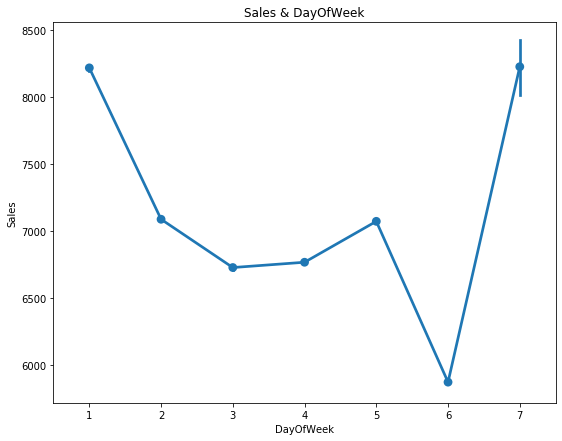

In [73]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['DayOfWeek'], train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")

Sales on Saturday are the lowest.

Text(0.5, 1.0, 'Sales & DayOfWeek')

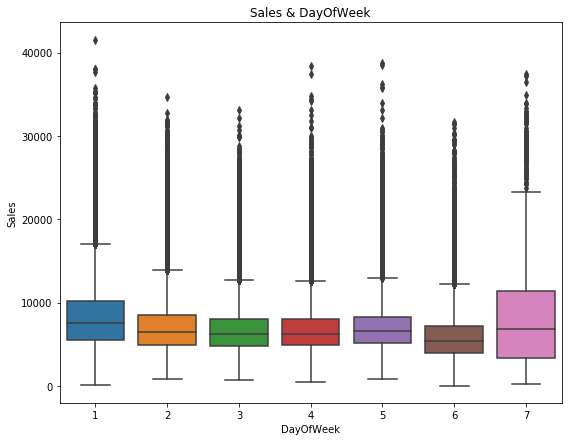

In [74]:
plt.figure(figsize=(9,7))
sns.boxplot(train_store_sales_df['DayOfWeek'], train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")

There seems to be some abnormal points. The daily sales are almost the same.

####  Sales & WeekOfYear

Text(0.5, 1.0, 'Sales & WeekOfYear')

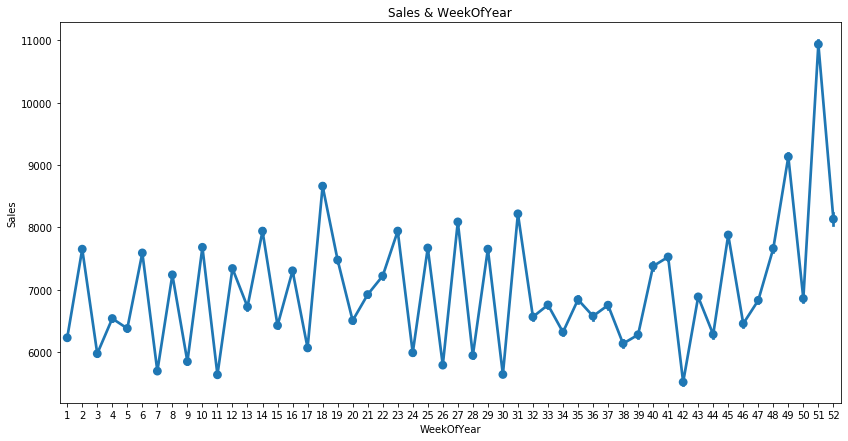

In [75]:
plt.figure(figsize=(14,7))
sns.pointplot(train_store_sales_df['WeekOfYear'], train_store_sales_df['Sales'])
plt.title("Sales & WeekOfYear")

#### Sales & Year

In [76]:
train_store_sales_df.groupby('Year').Sales.sum()

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

Text(0.5, 1.0, 'Sales & Year')

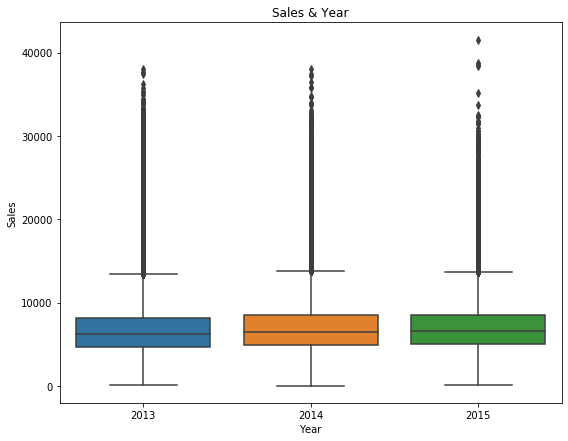

In [77]:
plt.figure(figsize=(9,7))
sns.boxplot(train_store_sales_df['Year'], train_store_sales_df['Sales'])
plt.title("Sales & Year")

The three years sales are almost the same.

#### Sales & Month

Text(0.5, 1.0, 'Sales & Month')

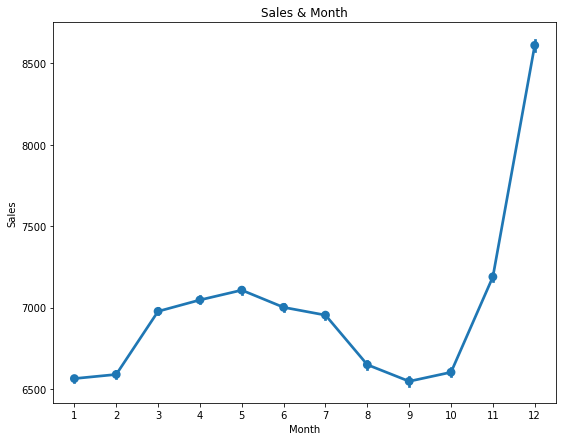

In [78]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['Month'], train_store_sales_df['Sales'])
plt.title("Sales & Month")

The December sales is the largest.

#### Sales & Day

Text(0.5, 1.0, 'Sales & Day')

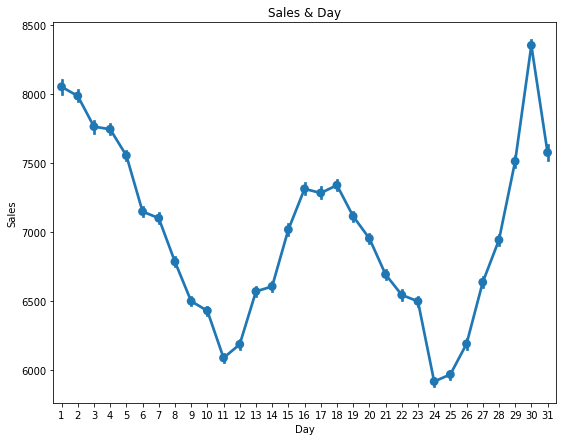

In [79]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['Day'], train_store_sales_df['Sales'])
plt.title("Sales & Day")

we see that sales are the most at the beginning of the month, the monthly, and the end of the month.
There is a strong rule between the two variables.

#### Sales & Customers

Text(0.5, 1.0, 'Sales & Customers')

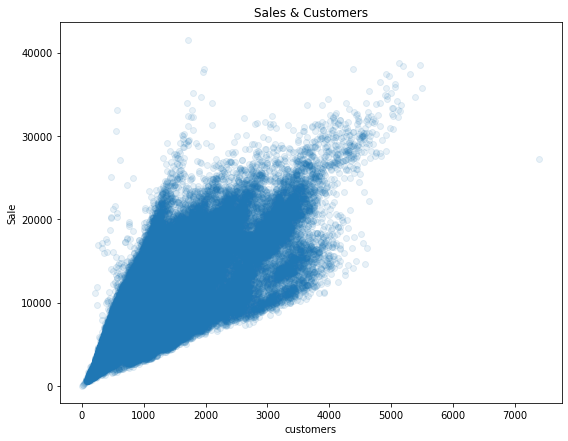

In [80]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='Customers', y='Sales', alpha=0.1)
plt.xlabel('customers')
plt.ylabel('Sale')
plt.title("Sales & Customers")

Text(0.5, 1.0, 'Log(Sales) & Log(Customers)')

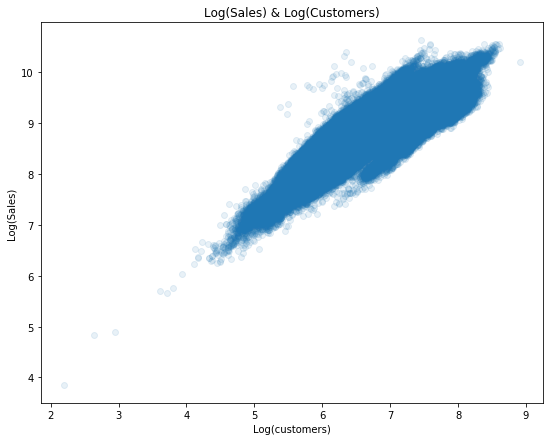

In [81]:
plt.figure(figsize=(9,7))
plt.scatter(np.log1p(train_store_sales_df.Customers), np.log1p(train_store_sales_df.Sales), alpha=0.1)
plt.xlabel('Log(customers)')
plt.ylabel('Log(Sales)')
plt.title("Log(Sales) & Log(Customers)")

There is a strong positive correlation between sales and customer.

#### Sales & Promo

In [82]:
train_store_sales_df.groupby('Promo').Sales.mean()

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & Promo')

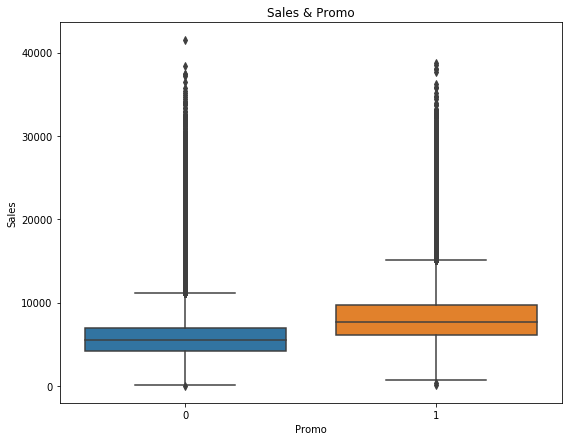

In [83]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo', y='Sales')
plt.title("Sales & Promo")

We can know that promotion is benifit to improve sales.

#### Sales & StateHoliday

In [84]:
train_store_sales_df.StateHoliday = train_store_sales_df.StateHoliday.astype('str')
train_store_sales_df[train_store_sales_df.StateHoliday == '0'].StateHoliday = train_store_sales_df[train_store_sales_df.StateHoliday == '0'].StateHoliday.astype('int')

/home/z1yuan/anaconda3/envs/robot-env/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [85]:
train_store_sales_df.groupby('StateHoliday').Sales.mean()

StateHoliday
0    6953.960229
a    8487.471182
b    9887.889655
c    9743.746479
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & StateHoliday')

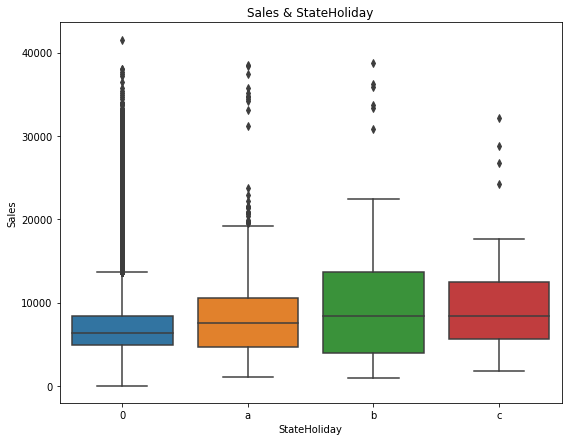

In [86]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='StateHoliday', y='Sales')
plt.title("Sales & StateHoliday")

#### Sales & SchoolHoliday

In [87]:
train_store_sales_df.groupby('SchoolHoliday').Sales.mean()

SchoolHoliday
0    6897.207830
1    7200.710282
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & SchoolHoliday')

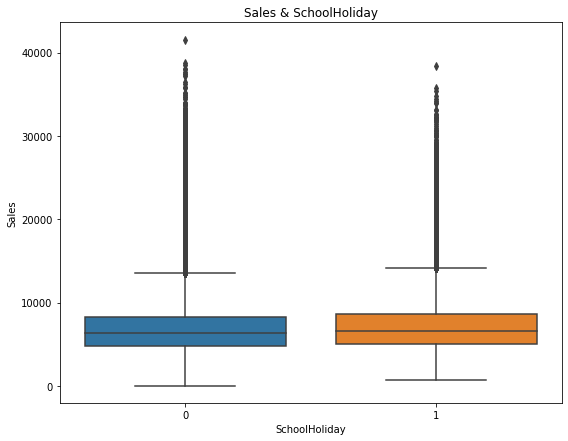

In [88]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='SchoolHoliday', y='Sales')
plt.title("Sales & SchoolHoliday")

#### Sales & StoreType

In [89]:
train_store_sales_df.groupby('StoreType').Sales.mean()

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & StoreType')

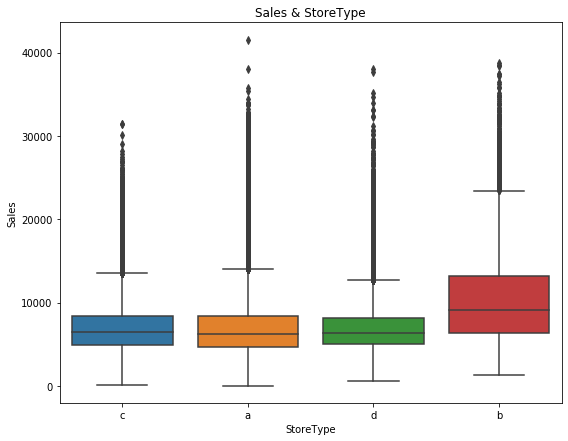

In [90]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='StoreType', y='Sales')
plt.title("Sales & StoreType")

Store sales of 'b' type are the most.

#### Sales & Assortment

In [91]:
train_store_sales_df.groupby('Assortment').Sales.mean()

Assortment
a    6621.523057
b    8642.503594
c    7300.843547
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & Assortment')

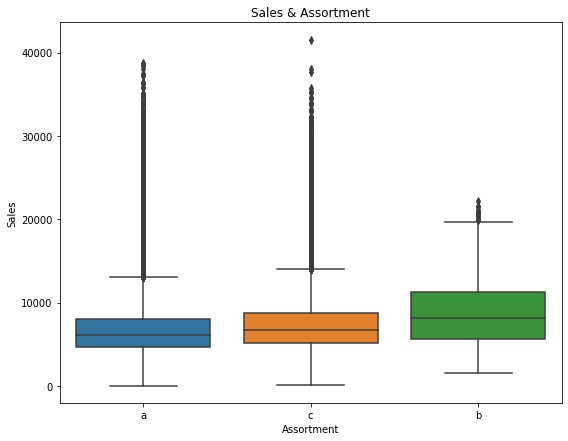

In [92]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Assortment', y='Sales')
plt.title("Sales & Assortment")

Store sales of  'b' assortment are the most.

#### Sales & CompetitionDistance

Text(0.5, 1.0, 'Sales & CompetitionDistance')

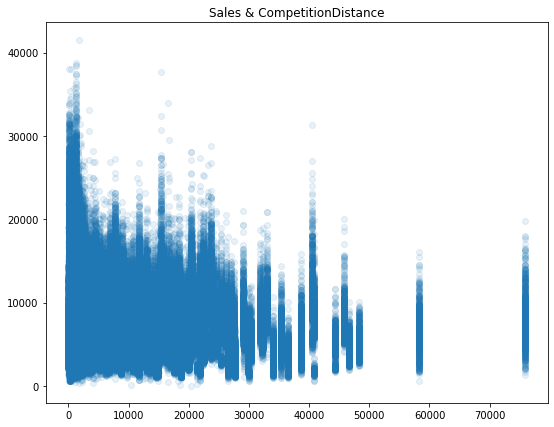

In [93]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='CompetitionDistance', y='Sales', alpha=0.1)
plt.title("Sales & CompetitionDistance")

There is no correlation between sales and CompetitionDistance.

#### Sales & CompetitionOpen

Text(0.5, 1.0, 'Sales & CompetitionOpen')

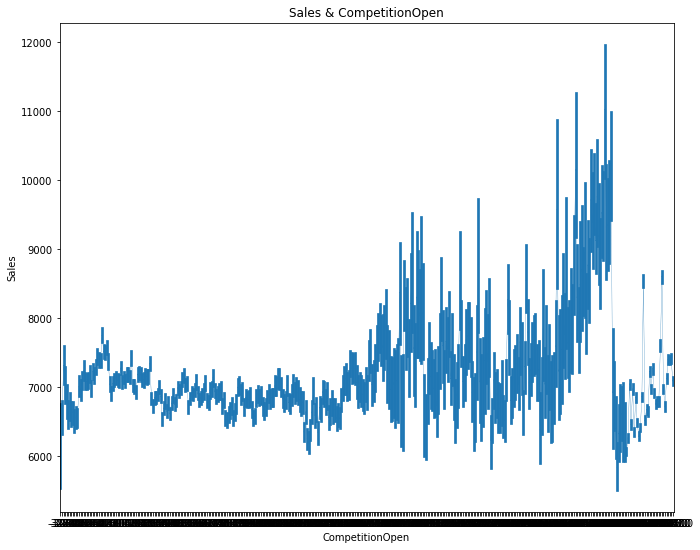

In [94]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='CompetitionOpen', y='Sales',scale=0.1)
plt.title("Sales & CompetitionOpen")

There is a weak rule between sales and CompetitionOpen.

#### Sales & Promo2

In [95]:
train_store_sales_df.groupby('Promo2').Sales.sum()

Promo2
0    3111542628
1    2761637995
Name: Sales, dtype: int64

Text(0.5, 1.0, 'Sales & Promo2')

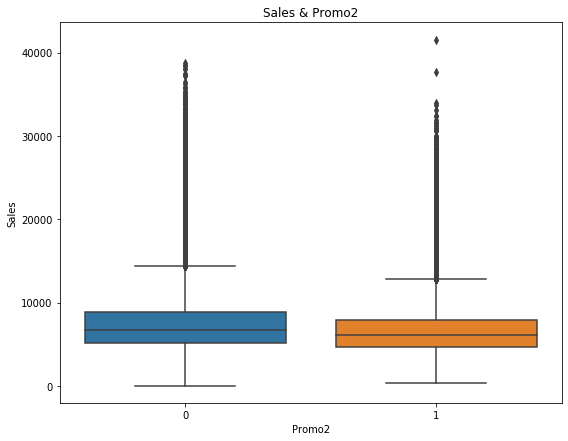

In [96]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo2', y='Sales')
plt.title("Sales & Promo2")

The stores with promos tend to make lower sales. This does not necessary mean that the promos don’t help or are counterproductive. They are possibly measures that are taken mainly by stores with low sales in the first place.

#### Sales & PromoOpen

Text(0.5, 1.0, 'Sales & PromoOpen')

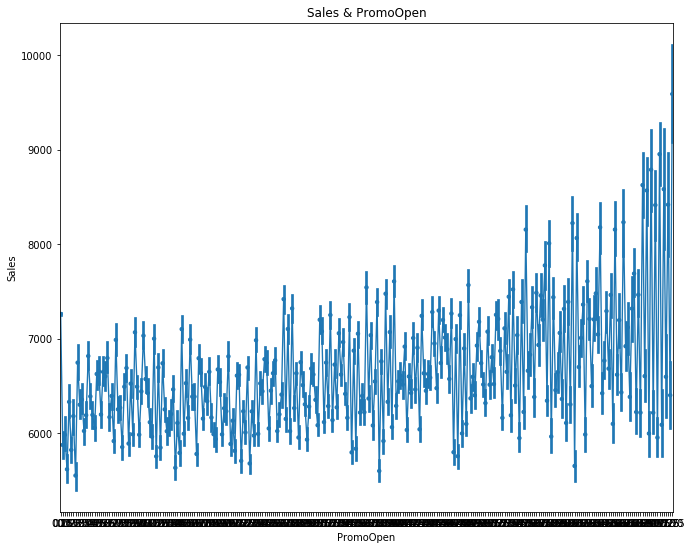

In [97]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='PromoOpen', y='Sales',scale=0.5)
plt.title("Sales & PromoOpen")

It seems that the longer the time is, the bigger the sales are.

There is no correlation between sales and Promo2SinceYear.

#### Sales & PromoInterval

In [98]:
train_store_sales_df.groupby('PromoInterval').Sales.mean()

PromoInterval
0                   7350.818414
Feb,May,Aug,Nov     6427.367069
Jan,Apr,Jul,Oct     6726.367401
Mar,Jun,Sept,Dec    6215.888185
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & PromoInterval')

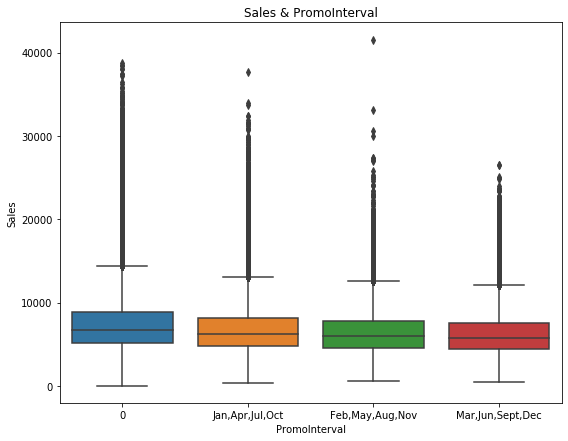

In [99]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='PromoInterval', y='Sales')
plt.title("Sales & PromoInterval")

There is no correlation between sales and PromoInterval.

#### Brief Summary

From above bivariate analysis, we can see that there is a strong positive correlation between sales and customer.
There is a certain relationship between variables Sales and  Day, DayofWeek, WeekofYear, CompetitionOpen, PromoOpen.

### Multivariate Analysis

#### Sales & DayOfWeek & StoreType & Promo 

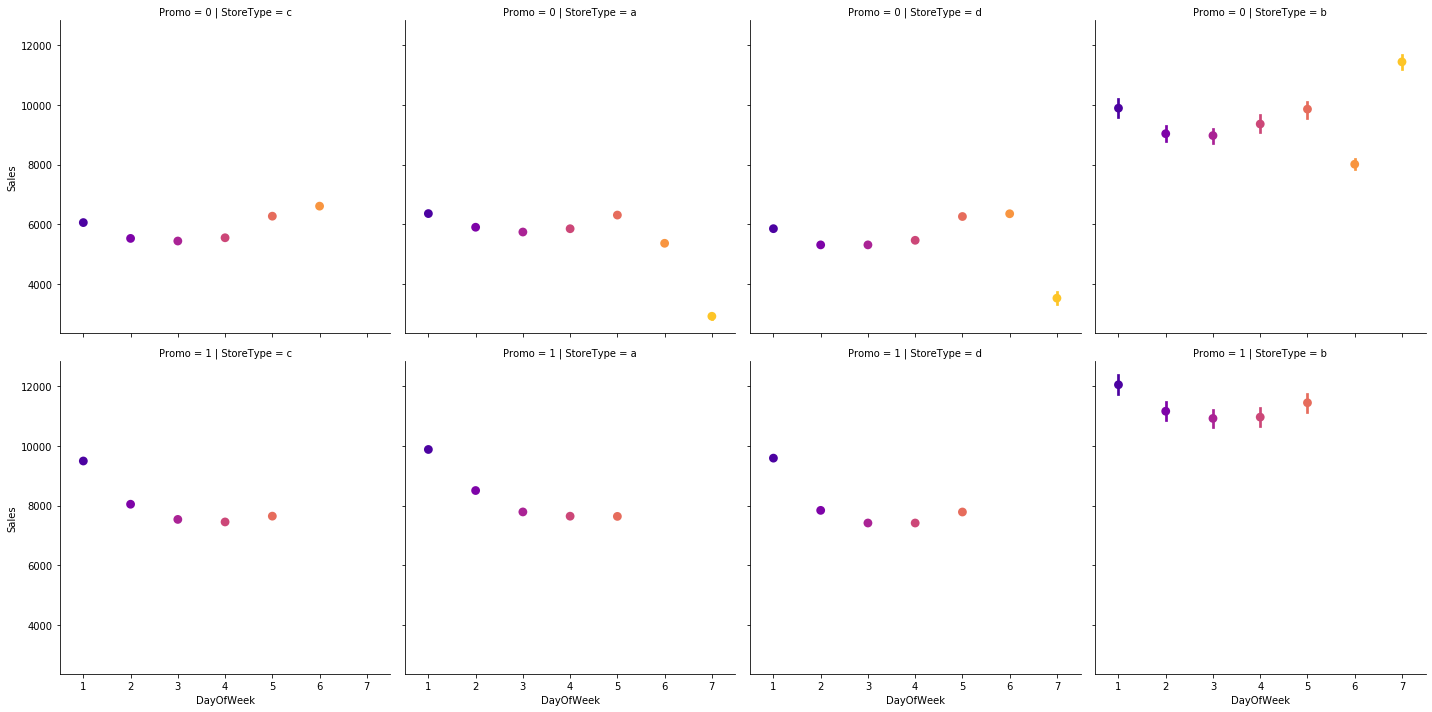

In [100]:
sns.catplot(data = train_store_sales_df, 
               x = "DayOfWeek", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Promo')

We can see that stores are never promoted at the weekend.

#### Sales & WeekOfYear & StoreType & Promo 

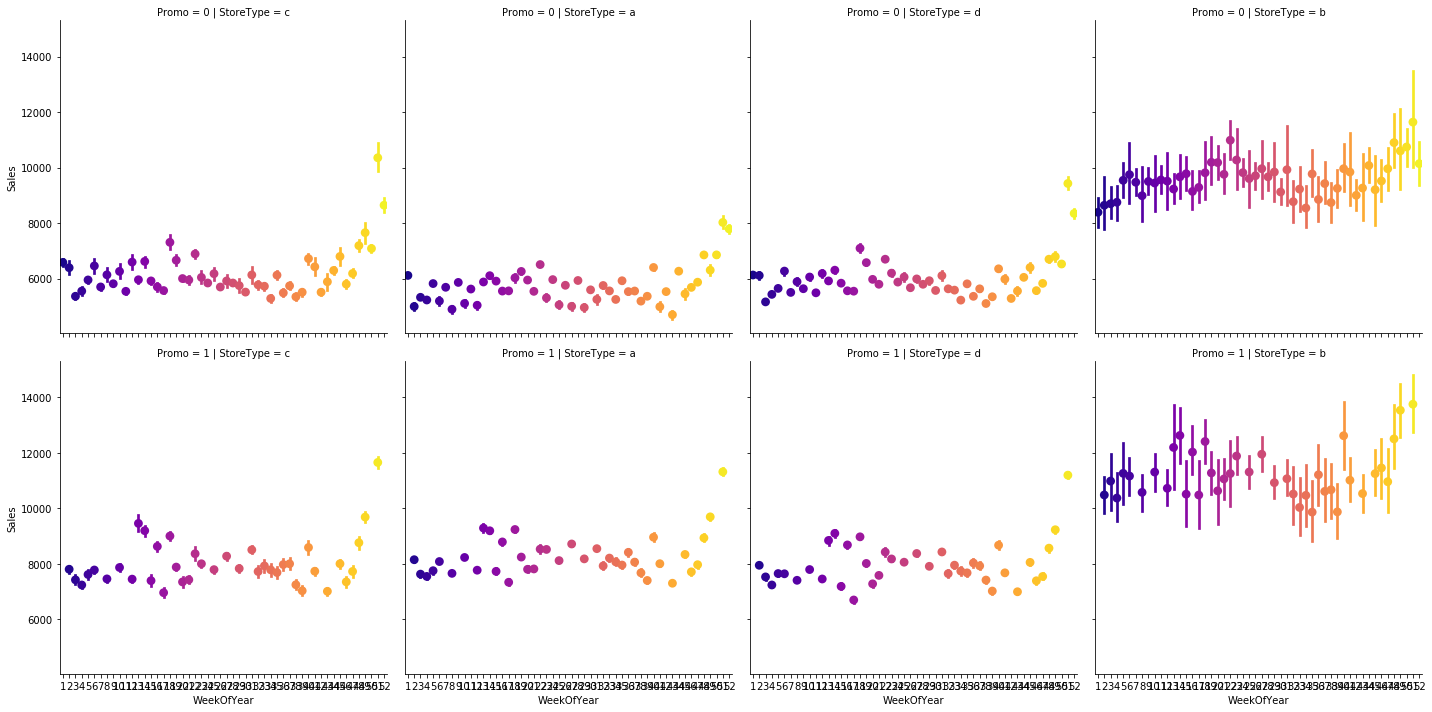

In [101]:
sns.catplot(data = train_store_sales_df, 
               x = "WeekOfYear", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Promo')

#### Sales & Month & StoreType & Promo 

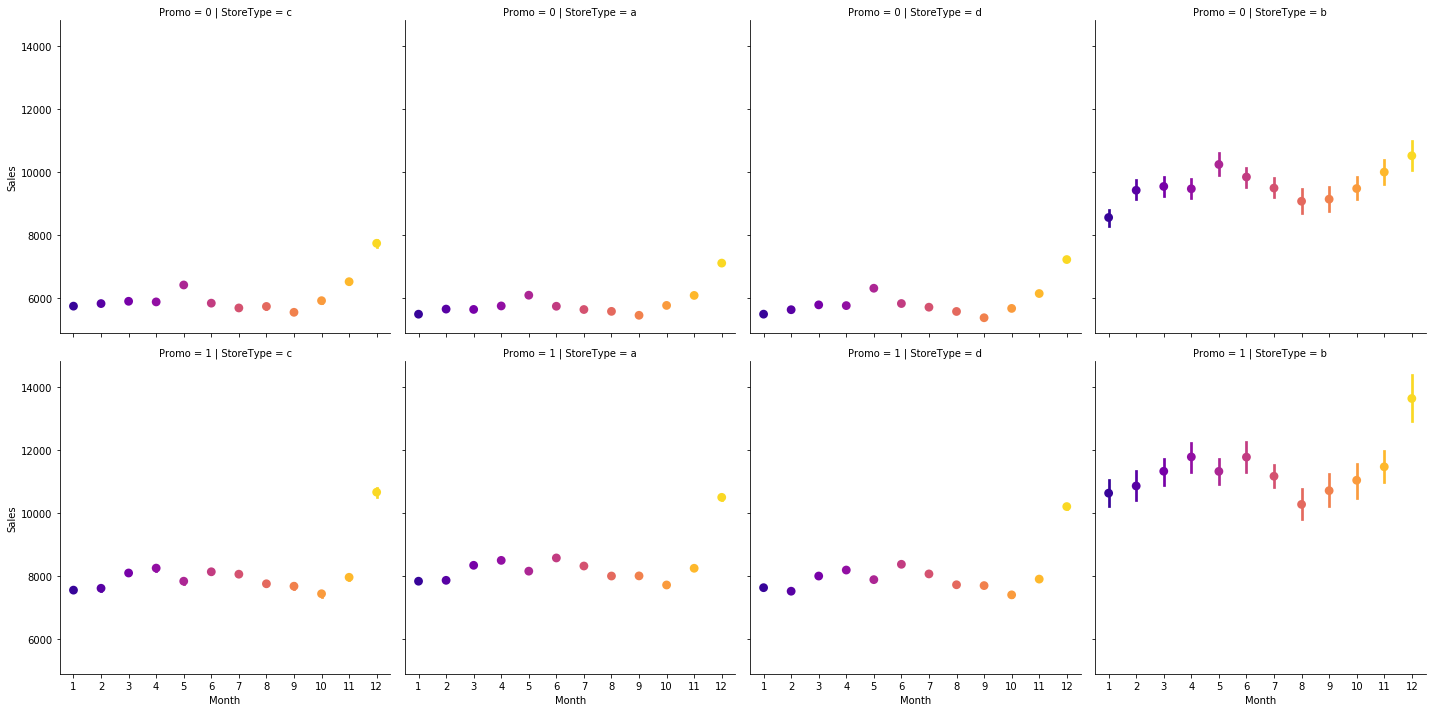

In [102]:
sns.catplot(data = train_store_sales_df, 
               x = "Month", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Promo')

Sales promotion can improve sales to a certain extent. There is a distinct increase in sales in the fourth quarter.

#### Sales & Month & Assortment	 & StoreType

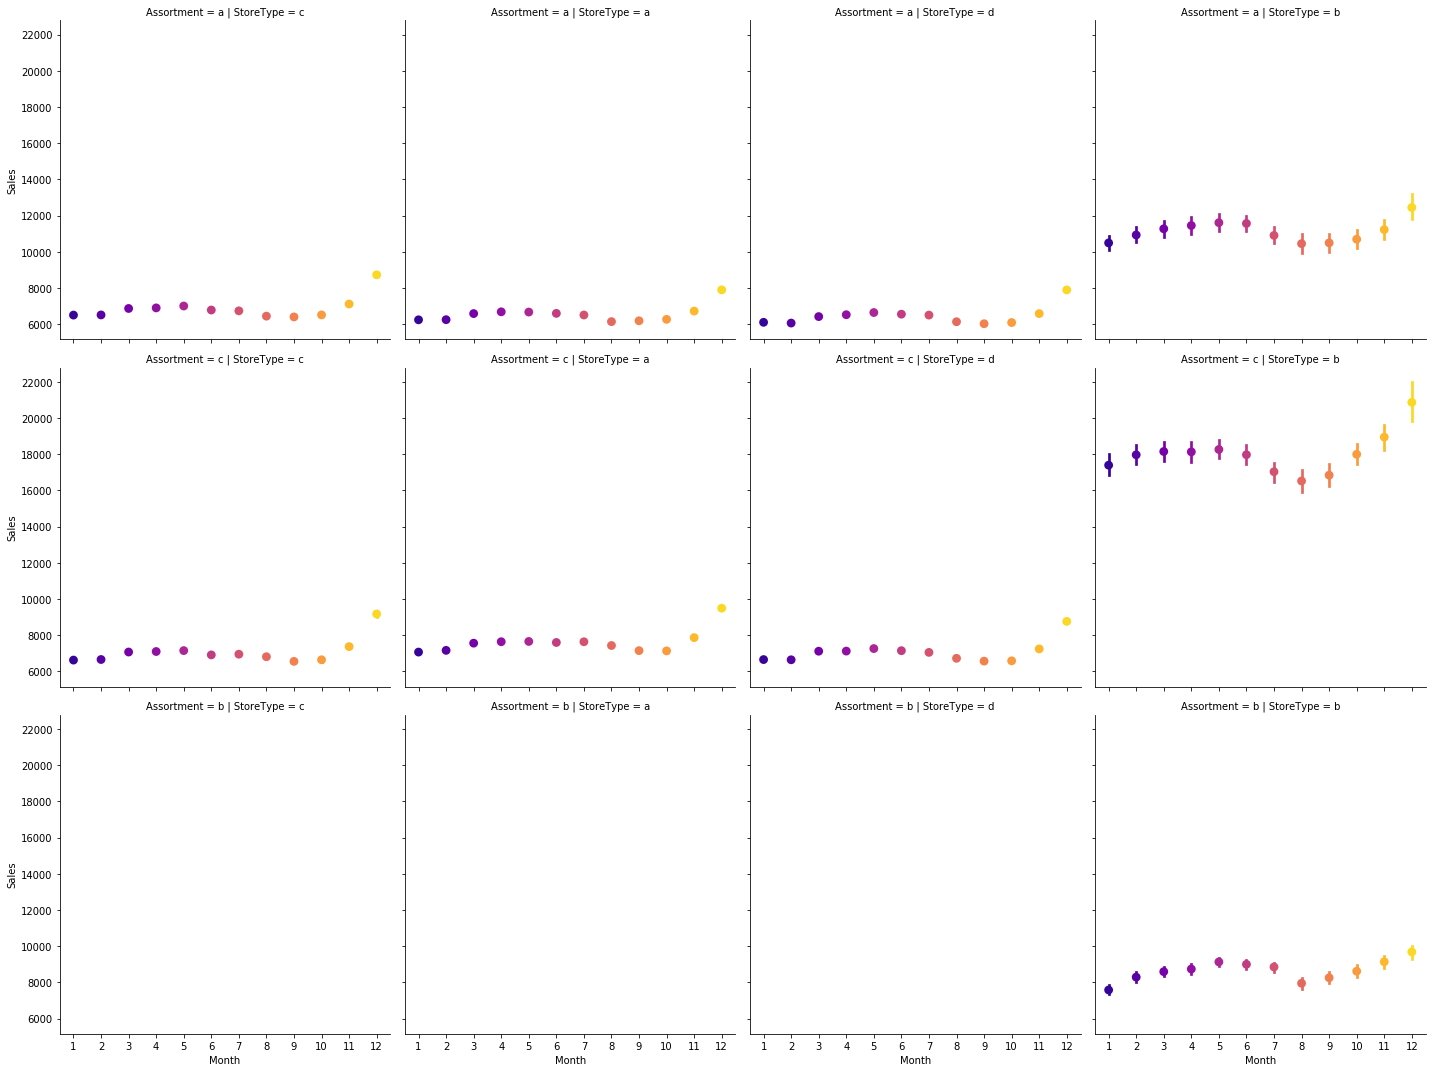

In [103]:
sns.catplot(data = train_store_sales_df, 
               x = "Month", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Assortment')

Only 'b' type stores have 'b' assortment level.

#### Sales & Day & StoreType & Promo 

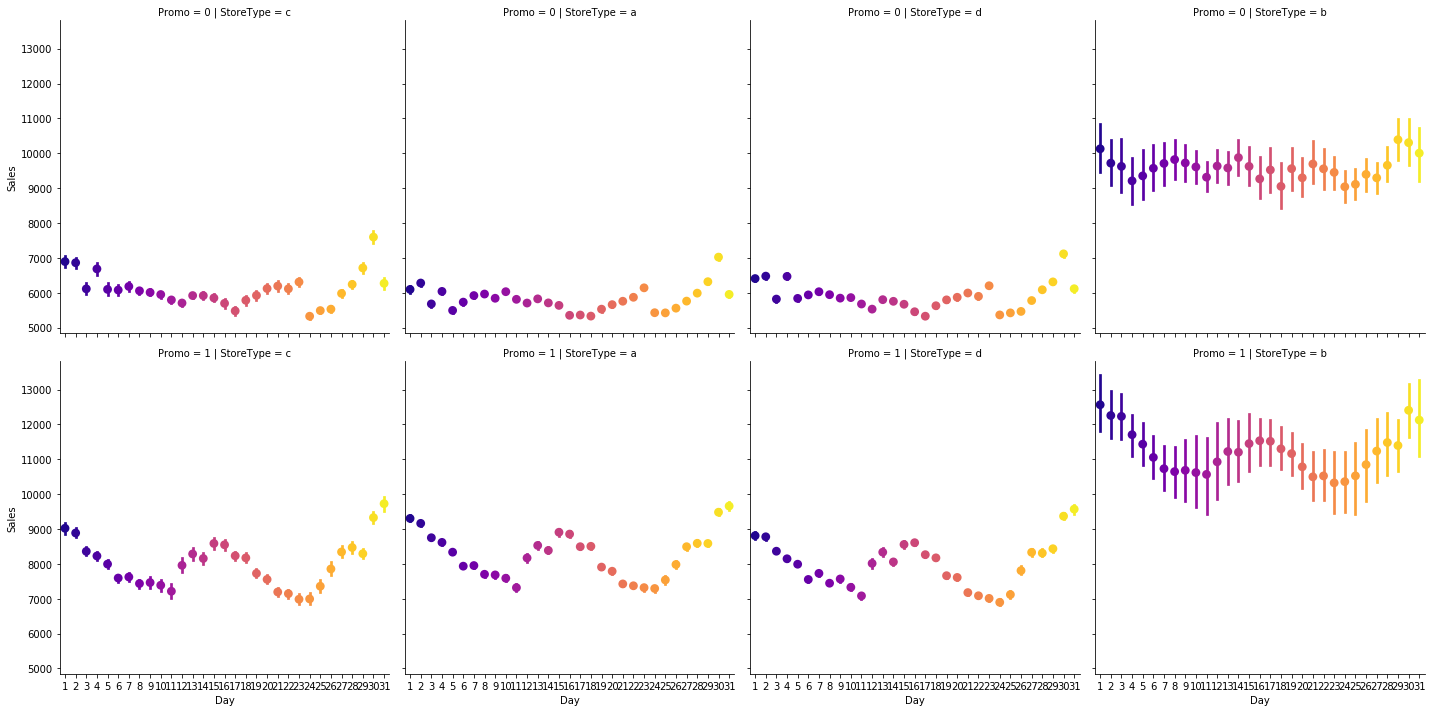

In [104]:
sns.catplot(data = train_store_sales_df, 
               x = "Day", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Promo')

All types of stores have a similar trend, and sales are the most at the beginning of the month, the monthly, and the end of the month.

#### Sales & Month & DayOfWeek & StoreType

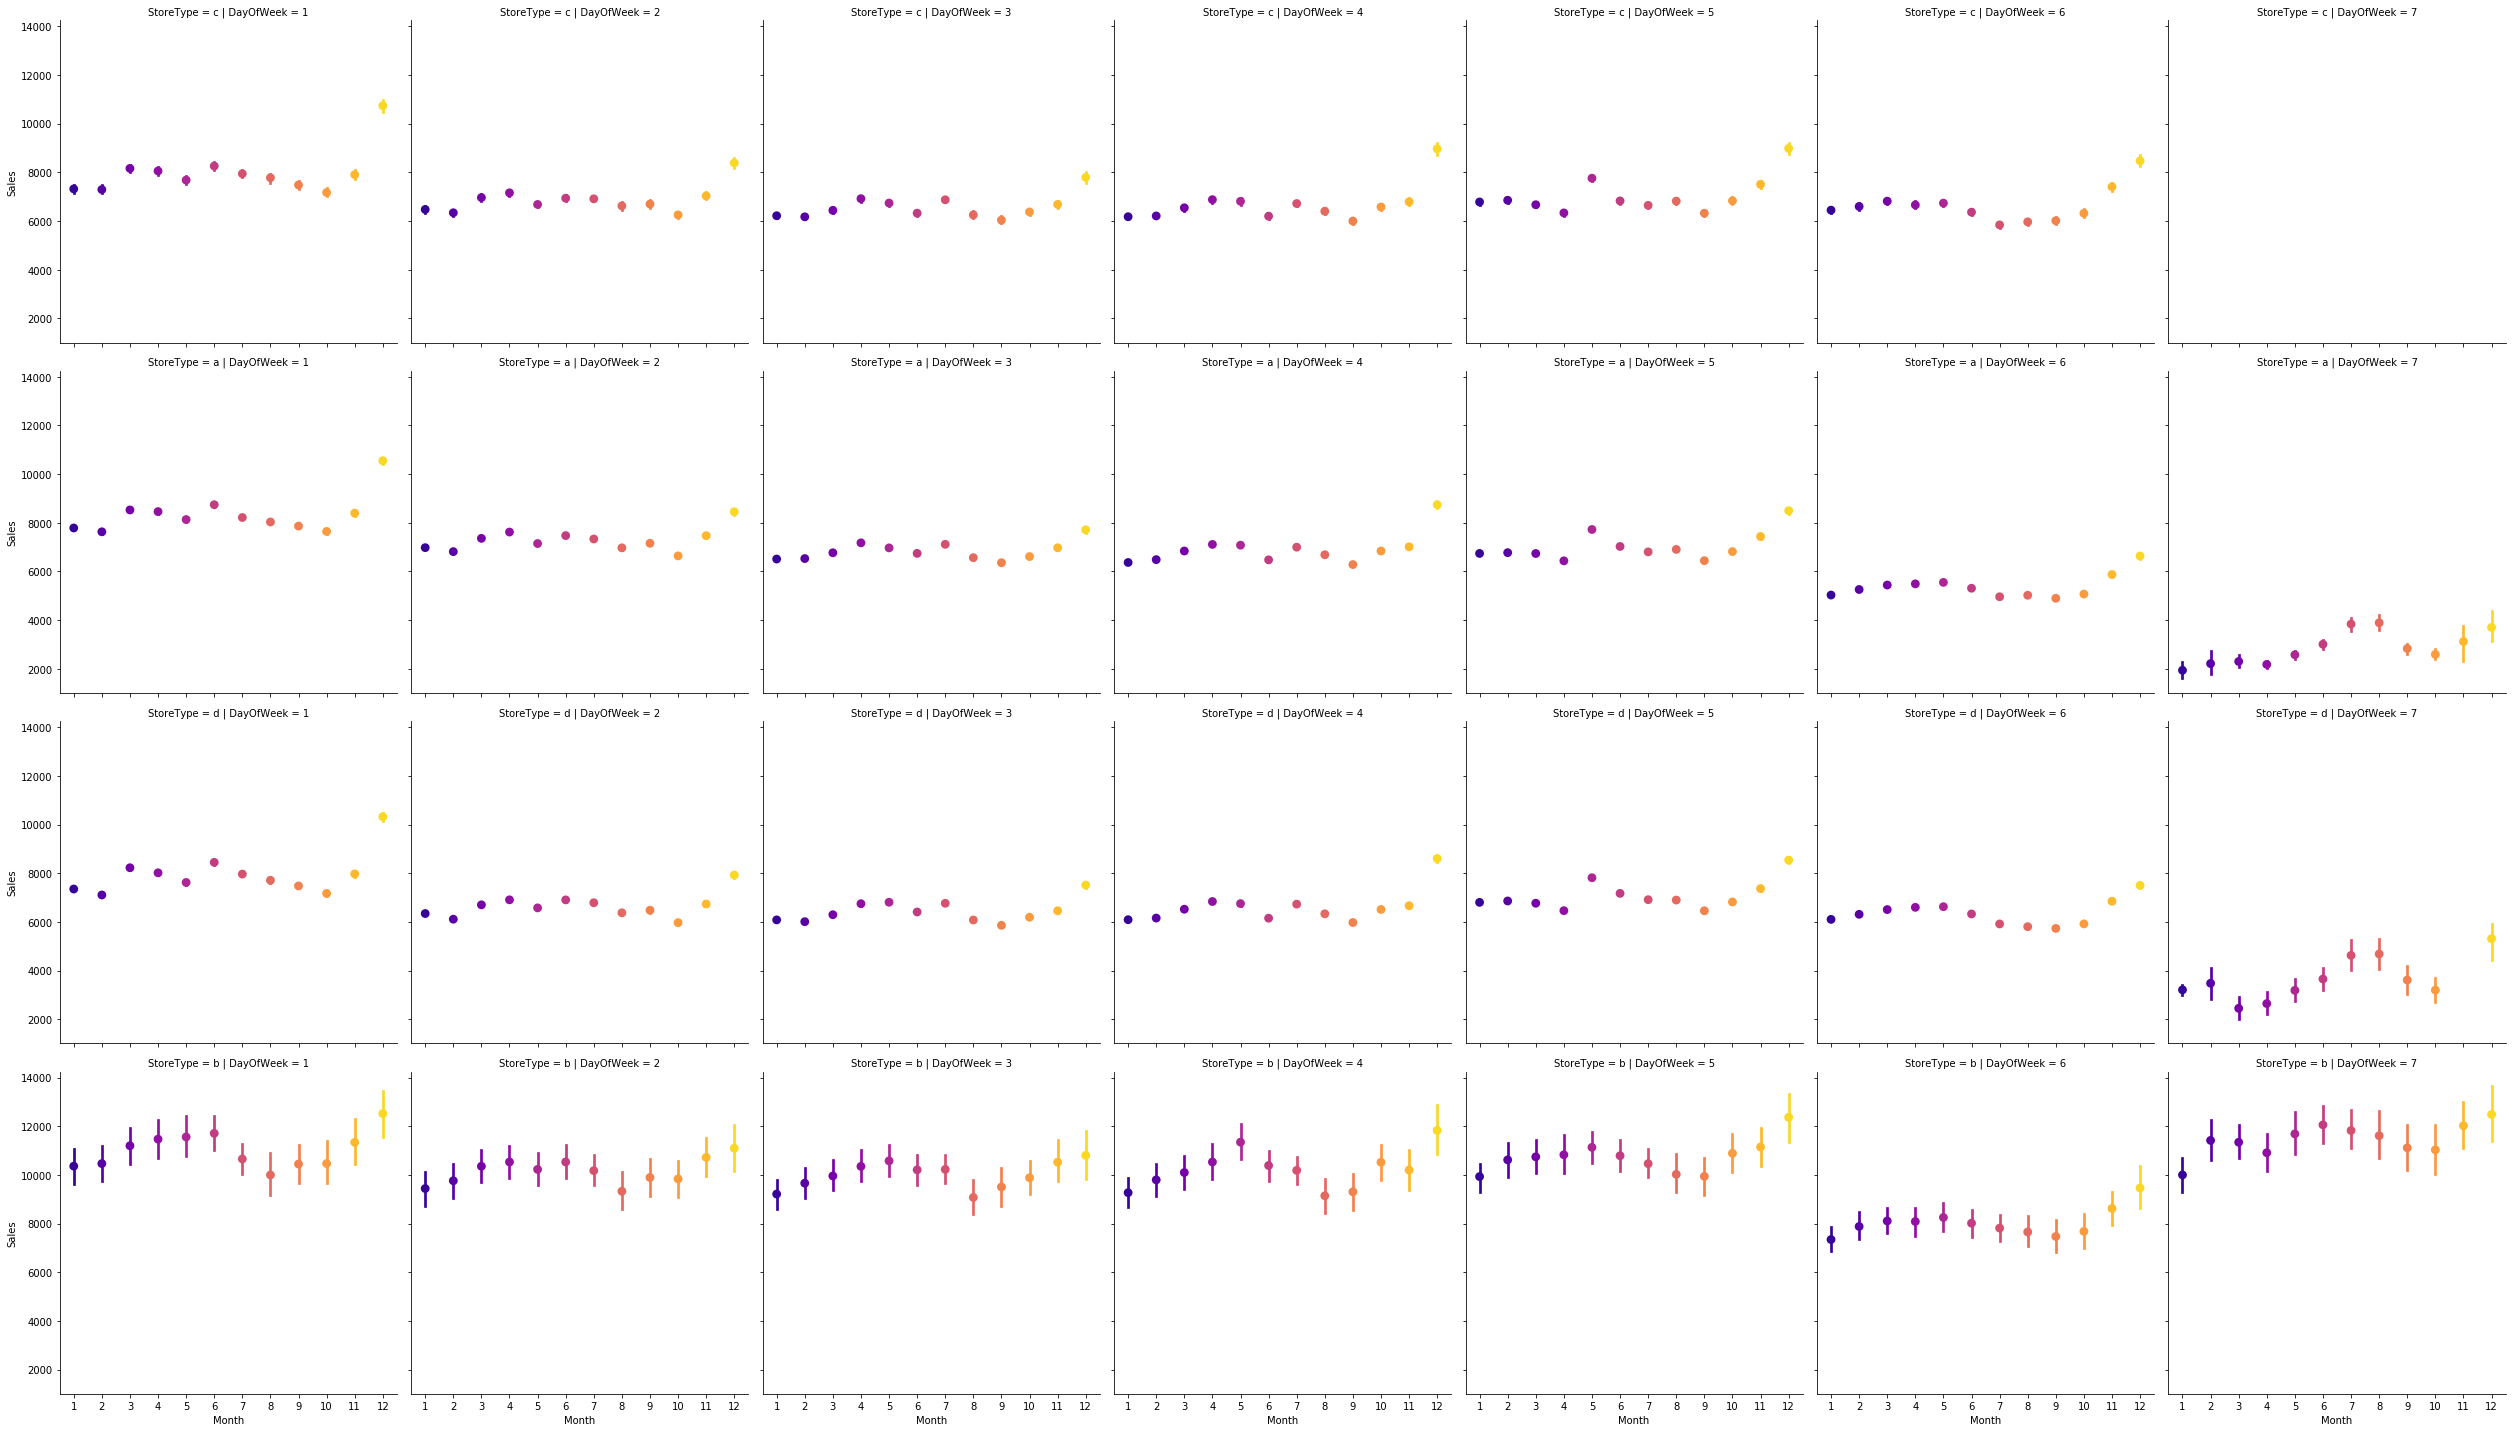

In [105]:
sns.catplot(data = train_store_sales_df, 
               x = "Month", 
               y = "Sales", 
               col = "DayOfWeek",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'StoreType')

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

#### Sales & StateHoliday & Promo & StoreType

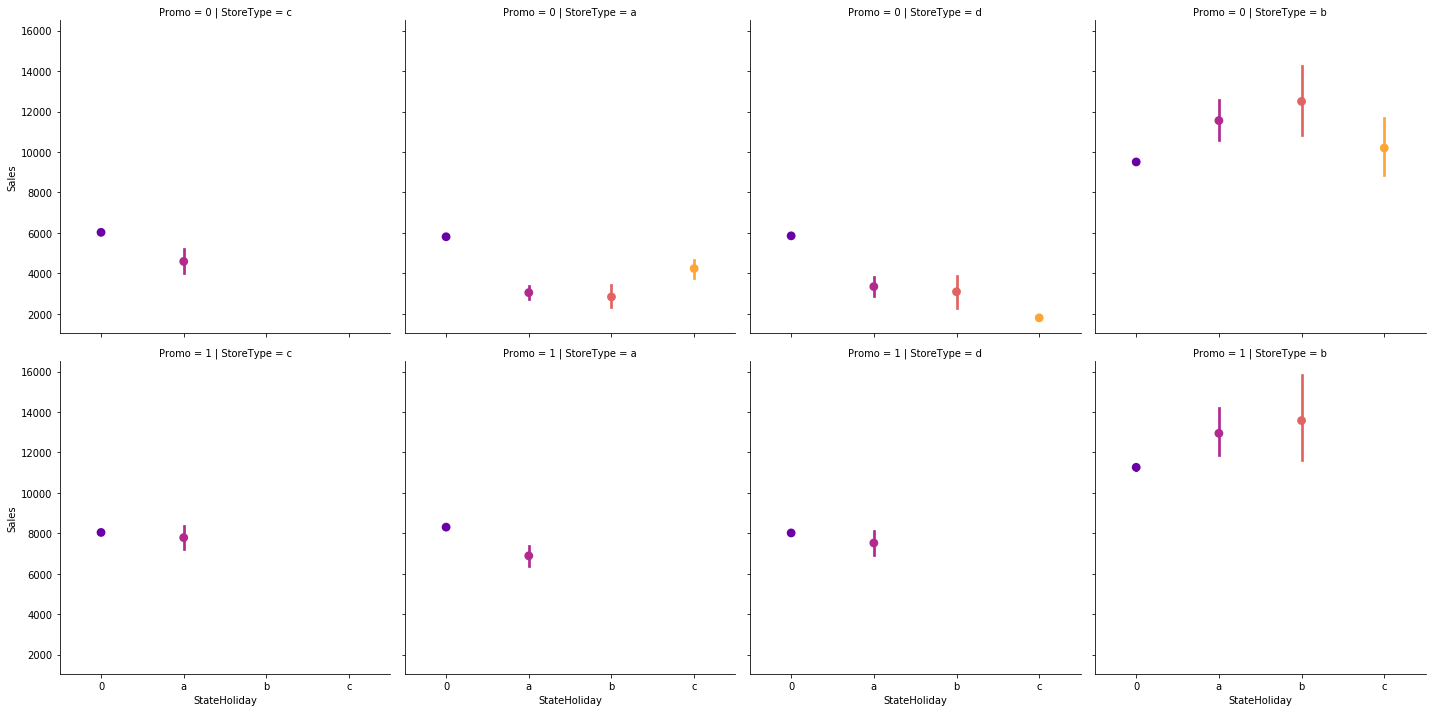

In [106]:
sns.catplot(data = train_store_sales_df, 
               x = "StateHoliday", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Promo')

Only B type stores will be promoted on Easter, and there is no promotion on Christmas.

#### Sales & SchoolHoliday & Promo & StoreType

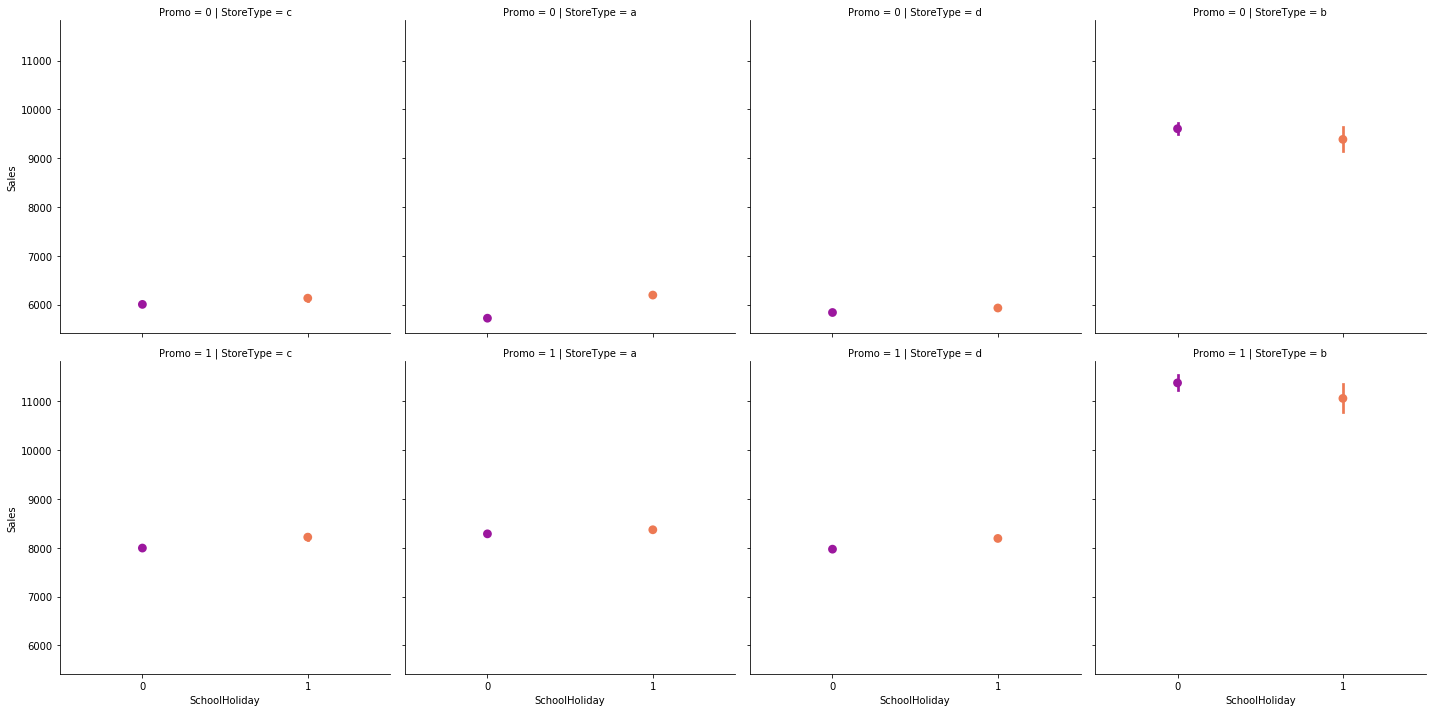

In [107]:
sns.catplot(data = train_store_sales_df, 
               x = "SchoolHoliday", 
               y = "Sales", 
               col = "StoreType",
               palette = "plasma",#hue = "StoreType",
               kind="point",
               row = 'Promo')

## Feature Engineering

In [108]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 non-null float64
PromoInterval                1017209 non-n

In [109]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 22 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
Year                         41088 non-null int64
Month                    

#### Encoding

In [110]:
#train
mappings = {'0':0,'a':1, 'b':2, 'c':3, 'd':4}
train_store_df.StateHoliday.replace(mappings, inplace=True)
train_store_df.StoreType.replace(mappings, inplace=True)
train_store_df.Assortment.replace(mappings, inplace=True)

#test
test_store_df.StateHoliday.replace(mappings, inplace=True)
test_store_df.StoreType.replace(mappings, inplace=True)
test_store_df.Assortment.replace(mappings, inplace=True)

#### Add IsPromoMonth attr to train

In [111]:
def check(row):
    if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
        return 1
    else:
        return 0  
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
#add IsPromoMonth attr to train and test
train_store_df['month_str'] = train_store_df.Month.map(month2str)
train_store_df.head()
train_store_df['IsPromoMonth'] =  train_store_df.apply(lambda row: check(row),axis=1)
train_store_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,month_str,IsPromoMonth
0,1,5,5263,555,1,1,0,1,3,1,...,0.0,0,2015,7,31,31,82.0,0.0,Jul,0
1,1,4,5020,546,1,1,0,1,3,1,...,0.0,0,2015,7,30,31,82.0,0.0,Jul,0
2,1,3,4782,523,1,1,0,1,3,1,...,0.0,0,2015,7,29,31,82.0,0.0,Jul,0
3,1,2,5011,560,1,1,0,1,3,1,...,0.0,0,2015,7,28,31,82.0,0.0,Jul,0
4,1,1,6102,612,1,1,0,1,3,1,...,0.0,0,2015,7,27,31,82.0,0.0,Jul,0


#### Add IsPromoMonth attr to test

In [112]:
test_store_df['month_str'] = test_store_df.Month.map(month2str)
test_store_df.head()      
test_store_df['IsPromoMonth'] =  test_store_df.apply(lambda row: check(row),axis=1)
test_store_df.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,month_str,IsPromoMonth
0,1,1,4,1.0,1,0,0,3,1,1270.0,...,0.0,0,2015,9,17,38,84.0,0.0,Sept,0
1,857,1,3,1.0,1,0,0,3,1,1270.0,...,0.0,0,2015,9,16,38,84.0,0.0,Sept,0
2,1713,1,2,1.0,1,0,0,3,1,1270.0,...,0.0,0,2015,9,15,38,84.0,0.0,Sept,0
3,2569,1,1,1.0,1,0,0,3,1,1270.0,...,0.0,0,2015,9,14,38,84.0,0.0,Sept,0
4,3425,1,7,0.0,0,0,0,3,1,1270.0,...,0.0,0,2015,9,13,37,84.0,0.0,Sept,0


#### Choose X,y for training

In [113]:
# Consider only open stores which Sales bigger then zero for training.
train_drop_features = ['Customers', 'Sales','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                       'Promo2SinceWeek','Promo2SinceYear','PromoInterval','month_str']
X = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)].drop(train_drop_features, axis=1)
y = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)].Sales
y = np.log1p(y)
#print(X)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=23)

In [114]:
test_drop_features = ['Id','CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
                      'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval','month_str']
X_test = test_store_df.drop(test_drop_features, axis=1)
#print(X_test)

## Model

In [115]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

#xgboost
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

#lightgbm
def rmspe_lgb(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat), False

#sklearn interface
def rmspe_gscv(y, yhat):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return rmspe(y, yhat)

rmspe_score = make_scorer(rmspe_gscv)
kfold = KFold(n_splits=5, random_state=23)

### xgboost

In [116]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
#将提示的包含错误数据类型这一列进行转换
X_train['StateHoliday'] = lbl.fit_transform(X_train['StateHoliday'].astype(str))
X_train['Assortment'] = lbl.fit_transform(X_train['Assortment'].astype(str))
X_valid['StateHoliday'] = lbl.fit_transform(X_valid['StateHoliday'].astype(str))
X_valid['Assortment'] = lbl.fit_transform(X_valid['Assortment'].astype(str))

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

/home/z1yuan/anaconda3/envs/robot-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/z1yuan/anaconda3/envs/robot-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/z1yuan/anaconda3/envs/robot-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

#### Tuning Paramters

In [117]:
xgb_best_params = {}
params = {'booster': 'gbtree',
          'objective': 'reg:linear',
          'max_depth': 6, 
          'learning_rate': 1,
          'gamma': 0, 
          'min_child_weight': 1, 
          'subsample': 1, 
          'colsample_bytree': 1, 
          'reg_alpha': 0, 
          'reg_lambda ': 1,
          'random_state': 23,
          'gpu_id': 0,
          'max_bin': 16,
          'tree_method': 'auto'
         }

#### n_estimators

In [134]:
min_merror = np.inf
for n_estimators in range(10,100,10):
    params['n_estimators'] = n_estimators
    cv_results = xgb.cv(params, dtrain, nfold=3, num_boost_round=1000, early_stopping_rounds=30, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["n_estimators"] = n_estimators
  
params["n_estimators"] = xgb_best_params["n_estimators"]
xgb_best_params,min_merror

[16:49:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/z1yuan/anaconda3/envs/robot-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


[16:52:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:00:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:00:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:00:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

KeyboardInterrupt: 

#### max_depth & min_child_weight

In [183]:
min_merror = np.inf
for max_depth in range(6, 11, 1):
    for min_child_weight in range(1, 6, 1):
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        cv_results = xgb.cv(params, dtrain, nfold=3,num_boost_round=1000, early_stopping_rounds=50, feval=rmspe_xg, seed=23)
        mean_error = min(cv_results['test-rmspe-mean'])
        boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
        if mean_error < min_merror:
            min_merror = mean_error
            xgb_best_params["max_depth"] = max_depth
            xgb_best_params["min_child_weight"] = min_child_weight
  
params["max_depth"] = xgb_best_params["max_depth"]
params["min_child_weight"] = xgb_best_params["min_child_weight"]
xgb_best_params,min_merror

[0]	train-rmse:0.358468+0.00025745	train-rmspe:0.441136+0.00728245	test-rmse:0.358629+0.000378013	test-rmspe:0.441386+0.0137289
[1]	train-rmse:0.348474+0.000846398	train-rmspe:0.42985+0.00634537	test-rmse:0.348758+0.00120105	test-rmspe:0.430976+0.0127648
[2]	train-rmse:0.33991+0.00457617	train-rmspe:0.413501+0.00911821	test-rmse:0.340302+0.00427877	test-rmspe:0.424219+0.0229319
[3]	train-rmse:0.330418+0.00553642	train-rmspe:0.407148+0.0137657	test-rmse:0.330949+0.00505963	test-rmspe:0.410927+0.0246698
[4]	train-rmse:0.321351+0.00235177	train-rmspe:0.393227+0.00207555	test-rmse:0.321981+0.00176384	test-rmspe:0.40198+0.0242136
[5]	train-rmse:0.311365+0.00303316	train-rmspe:0.381829+0.00495372	test-rmse:0.312049+0.00290536	test-rmspe:0.38474+0.0100107
[6]	train-rmse:0.301211+0.000720246	train-rmspe:0.370261+0.00566271	test-rmse:0.302073+0.000985461	test-rmspe:0.373701+0.0095558
[7]	train-rmse:0.292055+0.00305402	train-rmspe:0.362406+0.00113993	test-rmse:0.292893+0.00247325	test-rmspe:0.36

[65]	train-rmse:0.143616+0.0029613	train-rmspe:0.197369+0.014218	test-rmse:0.146786+0.00209917	test-rmspe:0.216183+0.0389002
[66]	train-rmse:0.143016+0.0028017	train-rmspe:0.196324+0.0147364	test-rmse:0.146232+0.00192515	test-rmspe:0.215831+0.0389028
[67]	train-rmse:0.14235+0.00294338	train-rmspe:0.195277+0.014371	test-rmse:0.14561+0.00203943	test-rmspe:0.213937+0.0380095
[68]	train-rmse:0.141796+0.0029559	train-rmspe:0.195281+0.0146493	test-rmse:0.145098+0.00209101	test-rmspe:0.214205+0.0381159
[69]	train-rmse:0.141386+0.00296124	train-rmspe:0.195025+0.0147448	test-rmse:0.144718+0.00209965	test-rmspe:0.213882+0.038223
[70]	train-rmse:0.140794+0.00268462	train-rmspe:0.194558+0.0147786	test-rmse:0.144148+0.0018862	test-rmspe:0.218056+0.043546
[71]	train-rmse:0.140124+0.00271636	train-rmspe:0.193908+0.0149703	test-rmse:0.14348+0.00193167	test-rmspe:0.217461+0.0438384
[72]	train-rmse:0.139571+0.00253961	train-rmspe:0.192798+0.0143894	test-rmse:0.142953+0.00174166	test-rmspe:0.216851+0.043

[130]	train-rmse:0.120883+0.0020339	train-rmspe:0.165663+0.0231895	test-rmse:0.126268+0.0013704	test-rmspe:0.203839+0.0477665
[131]	train-rmse:0.120604+0.00203761	train-rmspe:0.165263+0.0231025	test-rmse:0.126025+0.00138739	test-rmspe:0.203661+0.0477505
[132]	train-rmse:0.120395+0.00197238	train-rmspe:0.164766+0.0235296	test-rmse:0.125886+0.00135972	test-rmspe:0.203578+0.0476198
[133]	train-rmse:0.120136+0.00190207	train-rmspe:0.16445+0.0235218	test-rmse:0.125664+0.00132938	test-rmspe:0.201087+0.0449363
[134]	train-rmse:0.11993+0.00187993	train-rmspe:0.164275+0.0236865	test-rmse:0.125496+0.00129327	test-rmspe:0.200895+0.0447886
[135]	train-rmse:0.119671+0.00187237	train-rmspe:0.164043+0.0237436	test-rmse:0.125262+0.00128865	test-rmspe:0.200897+0.0449942
[136]	train-rmse:0.119541+0.00185234	train-rmspe:0.163994+0.0239149	test-rmse:0.125159+0.00125884	test-rmspe:0.200733+0.0449465
[137]	train-rmse:0.119309+0.00181299	train-rmspe:0.163841+0.0238481	test-rmse:0.124972+0.00125704	test-rmspe

[194]	train-rmse:0.11077+0.0011734	train-rmspe:0.151127+0.0203233	test-rmse:0.118055+0.000567819	test-rmspe:0.193669+0.0442223
[195]	train-rmse:0.110627+0.00116209	train-rmspe:0.150964+0.020367	test-rmse:0.11794+0.000559572	test-rmspe:0.192647+0.0432835
[196]	train-rmse:0.110417+0.00104597	train-rmspe:0.150795+0.0204995	test-rmse:0.117752+0.000451355	test-rmspe:0.192533+0.0433145
[197]	train-rmse:0.110344+0.00105984	train-rmspe:0.150741+0.0205097	test-rmse:0.117707+0.000459139	test-rmspe:0.192503+0.0433299
[198]	train-rmse:0.110229+0.00104232	train-rmspe:0.150944+0.0207356	test-rmse:0.117616+0.000441362	test-rmspe:0.192295+0.0432025
[199]	train-rmse:0.110135+0.00103666	train-rmspe:0.150869+0.0207593	test-rmse:0.117564+0.000449177	test-rmspe:0.191759+0.0432166
[200]	train-rmse:0.11005+0.00103909	train-rmspe:0.150842+0.0207485	test-rmse:0.117507+0.000449418	test-rmspe:0.191605+0.0431137
[201]	train-rmse:0.109905+0.000979501	train-rmspe:0.150673+0.0211237	test-rmse:0.117414+0.000382608	te

[258]	train-rmse:0.104354+0.000855081	train-rmspe:0.143654+0.021419	test-rmse:0.113573+0.000504841	test-rmspe:0.185267+0.0404844
[259]	train-rmse:0.104279+0.000862046	train-rmspe:0.143588+0.021401	test-rmse:0.113523+0.000523822	test-rmspe:0.185095+0.0404583
[260]	train-rmse:0.104193+0.000878916	train-rmspe:0.143479+0.0213721	test-rmse:0.113475+0.00052747	test-rmspe:0.185241+0.0407401
[261]	train-rmse:0.104113+0.000894165	train-rmspe:0.143281+0.0213969	test-rmse:0.113404+0.000546653	test-rmspe:0.184567+0.0402077
[262]	train-rmse:0.104019+0.000879335	train-rmspe:0.14278+0.0215786	test-rmse:0.113339+0.000516966	test-rmspe:0.184544+0.0402173
[263]	train-rmse:0.103938+0.000895494	train-rmspe:0.142522+0.0215655	test-rmse:0.113296+0.000509969	test-rmspe:0.184591+0.0402915
[264]	train-rmse:0.103877+0.000910836	train-rmspe:0.142422+0.0215621	test-rmse:0.113257+0.0005277	test-rmspe:0.184602+0.04028
[265]	train-rmse:0.103794+0.000899577	train-rmspe:0.14201+0.0220379	test-rmse:0.113236+0.000549842

[322]	train-rmse:0.0999757+0.000891401	train-rmspe:0.122497+0.0157394	test-rmse:0.110959+0.000493073	test-rmspe:0.181191+0.0395019
[323]	train-rmse:0.099902+0.00086178	train-rmspe:0.122412+0.0157309	test-rmse:0.110902+0.000468797	test-rmspe:0.181236+0.0396036
[324]	train-rmse:0.0998567+0.000873423	train-rmspe:0.122372+0.0157456	test-rmse:0.110885+0.000471941	test-rmspe:0.181231+0.0396135
[325]	train-rmse:0.0998053+0.000871508	train-rmspe:0.122372+0.0158175	test-rmse:0.11086+0.000480602	test-rmspe:0.18121+0.0396171
[326]	train-rmse:0.0997297+0.000897853	train-rmspe:0.122312+0.0158263	test-rmse:0.110813+0.000481346	test-rmspe:0.181099+0.039575
[327]	train-rmse:0.099665+0.000888388	train-rmspe:0.122226+0.015813	test-rmse:0.110774+0.000461095	test-rmspe:0.181384+0.0399289
[328]	train-rmse:0.0995927+0.000904453	train-rmspe:0.12216+0.0158092	test-rmse:0.110734+0.000461069	test-rmspe:0.181318+0.0398523
[329]	train-rmse:0.0995493+0.000897241	train-rmspe:0.122122+0.015827	test-rmse:0.11071+0.00

[386]	train-rmse:0.0965307+0.000789946	train-rmspe:0.118827+0.0156029	test-rmse:0.108964+0.000506646	test-rmspe:0.180719+0.0400834
[387]	train-rmse:0.096489+0.000794109	train-rmspe:0.118782+0.0156197	test-rmse:0.108951+0.00050218	test-rmspe:0.180734+0.0399847
[388]	train-rmse:0.096448+0.000793636	train-rmspe:0.118758+0.0156608	test-rmse:0.10893+0.000509642	test-rmspe:0.180705+0.0400098
[389]	train-rmse:0.0964057+0.000777132	train-rmspe:0.118695+0.0156756	test-rmse:0.108911+0.000508087	test-rmspe:0.180755+0.0400064
[390]	train-rmse:0.0963587+0.000765636	train-rmspe:0.11868+0.0156924	test-rmse:0.10888+0.000503279	test-rmspe:0.180708+0.0399916
[391]	train-rmse:0.0963213+0.000769683	train-rmspe:0.118646+0.0156861	test-rmse:0.108876+0.000494342	test-rmspe:0.180664+0.0399625
[392]	train-rmse:0.0962747+0.000764737	train-rmspe:0.118591+0.0157098	test-rmse:0.10885+0.000503079	test-rmspe:0.181067+0.0400468
[393]	train-rmse:0.0962243+0.000762804	train-rmspe:0.118535+0.0156679	test-rmse:0.108825+0

[19]	train-rmse:0.213886+0.00373346	train-rmspe:0.274896+0.0122412	test-rmse:0.215158+0.00342587	test-rmspe:0.281196+0.0207548
[20]	train-rmse:0.211093+0.00382435	train-rmspe:0.271086+0.0124113	test-rmse:0.212344+0.00344657	test-rmspe:0.278269+0.0220596
[21]	train-rmse:0.208666+0.00423118	train-rmspe:0.266029+0.0136419	test-rmse:0.209965+0.00386779	test-rmspe:0.276169+0.0215495
[22]	train-rmse:0.205883+0.0044046	train-rmspe:0.263745+0.0138148	test-rmse:0.207237+0.00409862	test-rmspe:0.2742+0.0227189
[23]	train-rmse:0.202653+0.00509675	train-rmspe:0.260148+0.0149616	test-rmse:0.204211+0.00485054	test-rmspe:0.270925+0.0226025
[24]	train-rmse:0.198693+0.00624554	train-rmspe:0.255721+0.0157202	test-rmse:0.200331+0.00582605	test-rmspe:0.27129+0.0288432
[25]	train-rmse:0.196776+0.00578369	train-rmspe:0.253154+0.0154751	test-rmse:0.198498+0.00531654	test-rmspe:0.269245+0.0291971
[26]	train-rmse:0.194592+0.00533544	train-rmspe:0.250495+0.0155089	test-rmse:0.196496+0.00495644	test-rmspe:0.26692

[84]	train-rmse:0.134715+0.00193094	train-rmspe:0.187374+0.0113752	test-rmse:0.138597+0.00145545	test-rmspe:0.211495+0.0440269
[85]	train-rmse:0.134206+0.00191251	train-rmspe:0.186872+0.0116493	test-rmse:0.138137+0.00136728	test-rmspe:0.211514+0.0443076
[86]	train-rmse:0.133923+0.00192816	train-rmspe:0.186054+0.0115301	test-rmse:0.137895+0.00138506	test-rmspe:0.211279+0.044439
[87]	train-rmse:0.133357+0.00171945	train-rmspe:0.18597+0.0119045	test-rmse:0.137409+0.00124452	test-rmspe:0.210662+0.044148
[88]	train-rmse:0.133041+0.00177174	train-rmspe:0.185663+0.0117974	test-rmse:0.137123+0.00132453	test-rmspe:0.210807+0.0446688
[89]	train-rmse:0.132856+0.00176768	train-rmspe:0.185437+0.0118757	test-rmse:0.136992+0.00129419	test-rmspe:0.211654+0.0457111
[90]	train-rmse:0.132458+0.00181661	train-rmspe:0.184693+0.0114227	test-rmse:0.136636+0.00127282	test-rmspe:0.211438+0.0457585
[91]	train-rmse:0.132168+0.00175175	train-rmspe:0.184192+0.0118144	test-rmse:0.136384+0.00123081	test-rmspe:0.2112

[149]	train-rmse:0.11752+0.00136206	train-rmspe:0.168221+0.0119148	test-rmse:0.123643+0.000954748	test-rmspe:0.198642+0.0437292
[150]	train-rmse:0.117309+0.00142325	train-rmspe:0.168222+0.0117464	test-rmse:0.123461+0.00100109	test-rmspe:0.198632+0.0438026
[151]	train-rmse:0.117135+0.00143499	train-rmspe:0.168107+0.0118287	test-rmse:0.123301+0.00102939	test-rmspe:0.198325+0.0438303
[152]	train-rmse:0.11691+0.00129329	train-rmspe:0.167879+0.0119309	test-rmse:0.123118+0.000911226	test-rmspe:0.195102+0.0404425
[153]	train-rmse:0.116662+0.00132748	train-rmspe:0.167644+0.0117295	test-rmse:0.122866+0.000954287	test-rmspe:0.19495+0.0405449
[154]	train-rmse:0.116465+0.00132526	train-rmspe:0.167531+0.0117174	test-rmse:0.122697+0.000946167	test-rmspe:0.194893+0.0406293
[155]	train-rmse:0.116309+0.00133308	train-rmspe:0.167003+0.0112292	test-rmse:0.122587+0.000982152	test-rmspe:0.194515+0.0404396
[156]	train-rmse:0.116142+0.00128649	train-rmspe:0.166849+0.0113796	test-rmse:0.122455+0.000976983	tes

[3]	train-rmse:0.33042+0.00553545	train-rmspe:0.407152+0.0137628	test-rmse:0.33095+0.00505851	test-rmspe:0.410928+0.0246686
[4]	train-rmse:0.321352+0.0023528	train-rmspe:0.39323+0.00207418	test-rmse:0.321984+0.00176085	test-rmspe:0.401982+0.0242121
[5]	train-rmse:0.311366+0.00303359	train-rmspe:0.381831+0.00495076	test-rmse:0.312051+0.00290347	test-rmspe:0.384743+0.0100095
[6]	train-rmse:0.301212+0.000720242	train-rmspe:0.370265+0.00565915	test-rmse:0.302075+0.000986395	test-rmspe:0.373712+0.00954574
[7]	train-rmse:0.292057+0.00305617	train-rmspe:0.362411+0.00114399	test-rmse:0.292896+0.00247184	test-rmspe:0.366358+0.0162819
[8]	train-rmse:0.280779+0.00251045	train-rmspe:0.34888+0.00265104	test-rmse:0.281728+0.00202868	test-rmspe:0.354888+0.0208441
[9]	train-rmse:0.268845+0.0040242	train-rmspe:0.338778+0.00213701	test-rmse:0.269877+0.00356014	test-rmspe:0.342847+0.0207154
[10]	train-rmse:0.261437+0.00568806	train-rmspe:0.331808+0.00459113	test-rmse:0.262301+0.00528513	test-rmspe:0.3328

[68]	train-rmse:0.142551+0.00262615	train-rmspe:0.194861+0.00829494	test-rmse:0.14572+0.00233087	test-rmspe:0.231848+0.0590827
[69]	train-rmse:0.14189+0.00257083	train-rmspe:0.194287+0.0084787	test-rmse:0.145107+0.00229925	test-rmspe:0.231254+0.0575101
[70]	train-rmse:0.141253+0.00269879	train-rmspe:0.193887+0.00862559	test-rmse:0.144477+0.00239834	test-rmspe:0.222588+0.0478868
[71]	train-rmse:0.140619+0.00244916	train-rmspe:0.19353+0.00874655	test-rmse:0.143908+0.00215441	test-rmspe:0.221552+0.0475827
[72]	train-rmse:0.140106+0.00228539	train-rmspe:0.193416+0.0100641	test-rmse:0.143439+0.00200075	test-rmspe:0.221352+0.0473891
[73]	train-rmse:0.139295+0.00214784	train-rmspe:0.192664+0.010065	test-rmse:0.142685+0.00181877	test-rmspe:0.220708+0.0474505
[74]	train-rmse:0.138943+0.00218326	train-rmspe:0.192338+0.0100874	test-rmse:0.14236+0.0018576	test-rmspe:0.220791+0.0479906
[75]	train-rmse:0.138537+0.00219858	train-rmspe:0.192231+0.0108747	test-rmse:0.142023+0.00189972	test-rmspe:0.2201

[133]	train-rmse:0.119991+0.00138171	train-rmspe:0.174914+0.0100941	test-rmse:0.125427+0.00123187	test-rmspe:0.202223+0.0474824
[134]	train-rmse:0.119759+0.00140924	train-rmspe:0.17506+0.0104999	test-rmse:0.12521+0.00126629	test-rmspe:0.20188+0.0473284
[135]	train-rmse:0.11953+0.00140327	train-rmspe:0.174903+0.0104174	test-rmse:0.124999+0.00125097	test-rmspe:0.201683+0.047481
[136]	train-rmse:0.119395+0.00138046	train-rmspe:0.17478+0.0104236	test-rmse:0.124915+0.00123339	test-rmspe:0.202024+0.0475507
[137]	train-rmse:0.119114+0.00140301	train-rmspe:0.174549+0.0104903	test-rmse:0.124658+0.00118972	test-rmspe:0.201755+0.0472929
[138]	train-rmse:0.118897+0.00135209	train-rmspe:0.174515+0.0103991	test-rmse:0.124448+0.00111067	test-rmspe:0.201793+0.047222
[139]	train-rmse:0.118762+0.00142044	train-rmspe:0.174482+0.0104996	test-rmse:0.124324+0.00116445	test-rmspe:0.20175+0.0473211
[140]	train-rmse:0.118542+0.00149073	train-rmspe:0.174521+0.0107136	test-rmse:0.124127+0.00128021	test-rmspe:0.2

[198]	train-rmse:0.109913+0.000979531	train-rmspe:0.161718+0.0170029	test-rmse:0.117332+0.0009893	test-rmspe:0.198705+0.0496604
[199]	train-rmse:0.109784+0.000987174	train-rmspe:0.160677+0.0167561	test-rmse:0.117246+0.000996265	test-rmspe:0.198537+0.0495711
[200]	train-rmse:0.109633+0.000952726	train-rmspe:0.160551+0.0167816	test-rmse:0.117103+0.00099383	test-rmspe:0.198371+0.0494998
[201]	train-rmse:0.109542+0.00094847	train-rmspe:0.160536+0.0167329	test-rmse:0.117044+0.000998156	test-rmspe:0.198334+0.0495605
[202]	train-rmse:0.109437+0.000928846	train-rmspe:0.160372+0.0167469	test-rmse:0.116993+0.000982034	test-rmspe:0.19794+0.0492149
[203]	train-rmse:0.109302+0.000950389	train-rmspe:0.160178+0.0167118	test-rmse:0.116891+0.0010156	test-rmspe:0.197858+0.0492682
[204]	train-rmse:0.109204+0.000975543	train-rmspe:0.160258+0.0168615	test-rmse:0.116838+0.00101191	test-rmspe:0.197998+0.0494276
[205]	train-rmse:0.109066+0.0010003	train-rmspe:0.160064+0.0167959	test-rmse:0.116736+0.00102913	t

[262]	train-rmse:0.103821+0.000886691	train-rmspe:0.153141+0.0149469	test-rmse:0.113116+0.000776937	test-rmspe:0.195457+0.0506077
[263]	train-rmse:0.103763+0.000880205	train-rmspe:0.15191+0.013589	test-rmse:0.113091+0.000773517	test-rmspe:0.195401+0.0505779
[264]	train-rmse:0.10371+0.000884734	train-rmspe:0.151854+0.0135996	test-rmse:0.113062+0.000767207	test-rmspe:0.195583+0.0507046
[265]	train-rmse:0.103628+0.000911636	train-rmspe:0.151796+0.0135783	test-rmse:0.11301+0.000784461	test-rmspe:0.19551+0.0507202
[266]	train-rmse:0.10356+0.000929468	train-rmspe:0.151725+0.0135616	test-rmse:0.112968+0.000798262	test-rmspe:0.195455+0.0507688
[267]	train-rmse:0.10348+0.000938368	train-rmspe:0.151516+0.013578	test-rmse:0.112925+0.000807204	test-rmspe:0.195413+0.0507875
[268]	train-rmse:0.103407+0.000930093	train-rmspe:0.151482+0.0135988	test-rmse:0.112876+0.000799686	test-rmspe:0.19536+0.0507771
[269]	train-rmse:0.103301+0.000918903	train-rmspe:0.151451+0.0137041	test-rmse:0.11279+0.000777887	

[326]	train-rmse:0.0996723+0.000776516	train-rmspe:0.132405+0.010104	test-rmse:0.110625+0.000606564	test-rmspe:0.188917+0.0466569
[327]	train-rmse:0.0995833+0.00076757	train-rmspe:0.132291+0.0101248	test-rmse:0.110573+0.000583493	test-rmspe:0.188994+0.0466837
[328]	train-rmse:0.0995183+0.000771069	train-rmspe:0.131453+0.0107849	test-rmse:0.110527+0.000570205	test-rmspe:0.189077+0.0467049
[329]	train-rmse:0.099458+0.000791898	train-rmspe:0.131345+0.0106913	test-rmse:0.11049+0.000577753	test-rmspe:0.188033+0.0455723
[330]	train-rmse:0.0994+0.000797216	train-rmspe:0.131281+0.0106815	test-rmse:0.110455+0.000570899	test-rmspe:0.188214+0.0457338
[331]	train-rmse:0.0993557+0.000809079	train-rmspe:0.131294+0.010763	test-rmse:0.110431+0.000584661	test-rmspe:0.188211+0.0457469
[332]	train-rmse:0.0993083+0.000821466	train-rmspe:0.131278+0.0107585	test-rmse:0.110405+0.000593688	test-rmspe:0.188123+0.0457036
[333]	train-rmse:0.0992753+0.000825932	train-rmspe:0.131239+0.0107649	test-rmse:0.110395+0.

[390]	train-rmse:0.096414+0.00065014	train-rmspe:0.126894+0.0117008	test-rmse:0.108871+0.00042341	test-rmspe:0.186232+0.0453296
[391]	train-rmse:0.0963683+0.000632384	train-rmspe:0.124602+0.00866131	test-rmse:0.108852+0.000413981	test-rmspe:0.186196+0.0453079
[392]	train-rmse:0.0963183+0.000626479	train-rmspe:0.124542+0.00868166	test-rmse:0.108821+0.000421031	test-rmspe:0.186511+0.0456924
[393]	train-rmse:0.0962757+0.000639848	train-rmspe:0.124521+0.00869241	test-rmse:0.108799+0.000434674	test-rmspe:0.186546+0.045749
[394]	train-rmse:0.0962177+0.000632209	train-rmspe:0.124462+0.00871028	test-rmse:0.108768+0.000436127	test-rmspe:0.186503+0.0457181
[395]	train-rmse:0.0961787+0.000618248	train-rmspe:0.123753+0.00938323	test-rmse:0.108757+0.000435656	test-rmspe:0.1875+0.0467709
[396]	train-rmse:0.096135+0.000614389	train-rmspe:0.123721+0.00937324	test-rmse:0.108737+0.000436361	test-rmspe:0.187292+0.0465146
[397]	train-rmse:0.0960907+0.000612545	train-rmspe:0.12367+0.00938476	test-rmse:0.10

[453]	train-rmse:0.0938213+0.000580801	train-rmspe:0.117488+0.0072259	test-rmse:0.107595+0.000413723	test-rmspe:0.184639+0.0442714
[454]	train-rmse:0.0937837+0.000585971	train-rmspe:0.117447+0.00721407	test-rmse:0.107581+0.000409771	test-rmspe:0.184614+0.0442532
[455]	train-rmse:0.093756+0.000587287	train-rmspe:0.117399+0.00723901	test-rmse:0.107576+0.000414139	test-rmspe:0.184624+0.0442834
[456]	train-rmse:0.0937253+0.000583955	train-rmspe:0.117367+0.0072258	test-rmse:0.107563+0.000414922	test-rmspe:0.184563+0.0442332
[457]	train-rmse:0.093691+0.000586961	train-rmspe:0.11737+0.00727235	test-rmse:0.107543+0.000407178	test-rmspe:0.18449+0.0441473
[458]	train-rmse:0.0936517+0.000591925	train-rmspe:0.117356+0.00732928	test-rmse:0.10752+0.000407848	test-rmspe:0.184429+0.0441338
[459]	train-rmse:0.093606+0.0006003	train-rmspe:0.117317+0.0073381	test-rmse:0.107511+0.000395314	test-rmspe:0.18439+0.0440907
[460]	train-rmse:0.093569+0.000585041	train-rmspe:0.117298+0.00738715	test-rmse:0.107491

[516]	train-rmse:0.0915133+0.00062353	train-rmspe:0.111784+0.00715677	test-rmse:0.106673+0.000314774	test-rmspe:0.184477+0.0449085
[517]	train-rmse:0.091482+0.000613715	train-rmspe:0.111709+0.00721566	test-rmse:0.106664+0.000313417	test-rmspe:0.184422+0.0449343
[518]	train-rmse:0.091443+0.000603815	train-rmspe:0.111702+0.00727727	test-rmse:0.106636+0.000311558	test-rmspe:0.184114+0.0448475
[519]	train-rmse:0.0914083+0.000597128	train-rmspe:0.11167+0.00728632	test-rmse:0.106622+0.000306751	test-rmspe:0.183968+0.0448091
[520]	train-rmse:0.0913737+0.000581221	train-rmspe:0.111641+0.00730308	test-rmse:0.106617+0.000297592	test-rmspe:0.183898+0.044724
[521]	train-rmse:0.0913477+0.000569985	train-rmspe:0.11162+0.00730489	test-rmse:0.106603+0.00028777	test-rmspe:0.183847+0.0446549
[522]	train-rmse:0.0913087+0.000560967	train-rmspe:0.111549+0.00727229	test-rmse:0.106585+0.000277909	test-rmspe:0.183887+0.0447156
[523]	train-rmse:0.0912833+0.000559077	train-rmspe:0.111524+0.00726967	test-rmse:0.

[1]	train-rmse:0.348475+0.000845617	train-rmspe:0.429853+0.00634095	test-rmse:0.348759+0.00120194	test-rmspe:0.430976+0.0127649
[2]	train-rmse:0.339912+0.00457518	train-rmspe:0.413506+0.00911691	test-rmse:0.340303+0.00427641	test-rmspe:0.424219+0.0229313
[3]	train-rmse:0.330419+0.00553495	train-rmspe:0.407155+0.0137658	test-rmse:0.330949+0.00505617	test-rmspe:0.410925+0.0246704
[4]	train-rmse:0.321351+0.00235203	train-rmspe:0.393232+0.00207586	test-rmse:0.321982+0.00175948	test-rmspe:0.401979+0.0242144
[5]	train-rmse:0.311366+0.00303238	train-rmspe:0.381832+0.00495406	test-rmse:0.31205+0.00290037	test-rmspe:0.384739+0.0100137
[6]	train-rmse:0.301212+0.000718883	train-rmspe:0.370266+0.00566266	test-rmse:0.302074+0.000983227	test-rmspe:0.373709+0.00954873
[7]	train-rmse:0.292057+0.00305627	train-rmspe:0.362412+0.00113951	test-rmse:0.292894+0.0024738	test-rmspe:0.366353+0.0162835
[8]	train-rmse:0.280779+0.00251072	train-rmspe:0.348881+0.00264743	test-rmse:0.281726+0.00203145	test-rmspe:0.

[66]	train-rmse:0.143963+0.00222762	train-rmspe:0.205094+0.0221023	test-rmse:0.147342+0.00137792	test-rmspe:0.224957+0.0386275
[67]	train-rmse:0.143425+0.0022232	train-rmspe:0.204746+0.0220791	test-rmse:0.146828+0.00134479	test-rmspe:0.223854+0.0383037
[68]	train-rmse:0.142668+0.0021984	train-rmspe:0.203832+0.022063	test-rmse:0.146119+0.00137838	test-rmspe:0.220034+0.0347737
[69]	train-rmse:0.142199+0.00203959	train-rmspe:0.203384+0.0219454	test-rmse:0.145659+0.00126022	test-rmspe:0.21907+0.0343161
[70]	train-rmse:0.141789+0.0020465	train-rmspe:0.202844+0.0219729	test-rmse:0.145238+0.00127799	test-rmspe:0.218749+0.0346882
[71]	train-rmse:0.141388+0.00215088	train-rmspe:0.202249+0.0216396	test-rmse:0.144893+0.00138986	test-rmspe:0.21842+0.034872
[72]	train-rmse:0.140909+0.00200169	train-rmspe:0.201203+0.0218789	test-rmse:0.144467+0.00127582	test-rmspe:0.217648+0.0352428
[73]	train-rmse:0.140573+0.00188027	train-rmspe:0.20099+0.0219377	test-rmse:0.144191+0.00115833	test-rmspe:0.218445+0.

[131]	train-rmse:0.121138+0.00153161	train-rmspe:0.185074+0.028474	test-rmse:0.126506+0.0010731	test-rmspe:0.199978+0.0416461
[132]	train-rmse:0.120955+0.00157298	train-rmspe:0.184896+0.02851	test-rmse:0.12637+0.00108486	test-rmspe:0.19986+0.0416354
[133]	train-rmse:0.120728+0.00158998	train-rmspe:0.183903+0.0273743	test-rmse:0.126179+0.00111508	test-rmspe:0.199255+0.0414511
[134]	train-rmse:0.120474+0.00162582	train-rmspe:0.183823+0.0273917	test-rmse:0.125973+0.00112102	test-rmspe:0.19919+0.0415255
[135]	train-rmse:0.120285+0.00159255	train-rmspe:0.183741+0.0274374	test-rmse:0.125836+0.00107137	test-rmspe:0.199623+0.0420182
[136]	train-rmse:0.120158+0.00161872	train-rmspe:0.183772+0.0274021	test-rmse:0.125747+0.00109372	test-rmspe:0.198937+0.0419176
[137]	train-rmse:0.120037+0.00161604	train-rmspe:0.183604+0.0272993	test-rmse:0.125652+0.00110157	test-rmspe:0.198899+0.0419566
[138]	train-rmse:0.119866+0.00155655	train-rmspe:0.183528+0.0273367	test-rmse:0.125519+0.00106015	test-rmspe:0.

[196]	train-rmse:0.11086+0.00103532	train-rmspe:0.160107+0.0130167	test-rmse:0.118217+0.000221722	test-rmspe:0.191633+0.0410169
[197]	train-rmse:0.110733+0.00103049	train-rmspe:0.153375+0.00958874	test-rmse:0.118145+0.000211191	test-rmspe:0.191918+0.0414186
[198]	train-rmse:0.110596+0.000999032	train-rmspe:0.153168+0.0096509	test-rmse:0.118041+0.000214223	test-rmspe:0.191794+0.0414352
[199]	train-rmse:0.110501+0.000994071	train-rmspe:0.153134+0.00964091	test-rmse:0.117971+0.00020366	test-rmspe:0.191709+0.0412652
[200]	train-rmse:0.110432+0.000975571	train-rmspe:0.15306+0.00968455	test-rmse:0.117923+0.000194056	test-rmspe:0.191654+0.0412895
[201]	train-rmse:0.110334+0.00100006	train-rmspe:0.152987+0.00969061	test-rmse:0.117838+0.000230082	test-rmspe:0.191593+0.041329
[202]	train-rmse:0.110198+0.00103154	train-rmspe:0.152904+0.00960946	test-rmse:0.117728+0.000276034	test-rmspe:0.191374+0.0413747
[203]	train-rmse:0.110001+0.00104006	train-rmspe:0.152661+0.00964948	test-rmse:0.117559+0.000

[260]	train-rmse:0.104666+0.000965876	train-rmspe:0.13331+0.0133767	test-rmse:0.113951+0.000418666	test-rmspe:0.188628+0.0414692
[261]	train-rmse:0.104609+0.000960707	train-rmspe:0.133226+0.0133461	test-rmse:0.113921+0.000407539	test-rmspe:0.188614+0.0414844
[262]	train-rmse:0.10453+0.000964139	train-rmspe:0.133277+0.0135306	test-rmse:0.113858+0.000429257	test-rmspe:0.18856+0.0415051
[263]	train-rmse:0.104461+0.000964863	train-rmspe:0.133239+0.0135285	test-rmse:0.113816+0.000413399	test-rmspe:0.188493+0.0415212
[264]	train-rmse:0.104392+0.000968912	train-rmspe:0.133164+0.0135214	test-rmse:0.113774+0.000428649	test-rmspe:0.188421+0.0414894
[265]	train-rmse:0.104309+0.000967943	train-rmspe:0.133094+0.0135243	test-rmse:0.113725+0.00040007	test-rmspe:0.188417+0.0414717
[266]	train-rmse:0.10425+0.000962632	train-rmspe:0.133127+0.013623	test-rmse:0.113689+0.000401943	test-rmspe:0.188273+0.041403
[267]	train-rmse:0.10417+0.000974875	train-rmspe:0.132942+0.0136499	test-rmse:0.113638+0.00041236

[324]	train-rmse:0.100476+0.000969675	train-rmspe:0.127994+0.0149299	test-rmse:0.111285+0.000543631	test-rmspe:0.190435+0.0454541
[325]	train-rmse:0.100411+0.000979209	train-rmspe:0.127909+0.0148979	test-rmse:0.111244+0.00054931	test-rmspe:0.190422+0.0454593
[326]	train-rmse:0.100345+0.000968102	train-rmspe:0.127795+0.0148968	test-rmse:0.111204+0.000526852	test-rmspe:0.190338+0.0454349
[327]	train-rmse:0.100286+0.000959654	train-rmspe:0.127748+0.0148368	test-rmse:0.111165+0.000529771	test-rmspe:0.190269+0.0453803
[328]	train-rmse:0.100217+0.000944919	train-rmspe:0.127633+0.0148571	test-rmse:0.111129+0.000522213	test-rmspe:0.190297+0.0454457
[329]	train-rmse:0.100155+0.000939679	train-rmspe:0.127578+0.0148785	test-rmse:0.11108+0.000516421	test-rmspe:0.189921+0.0450874
[330]	train-rmse:0.100108+0.000936849	train-rmspe:0.127549+0.0148983	test-rmse:0.111052+0.000523599	test-rmspe:0.18981+0.0450337
[331]	train-rmse:0.100026+0.000950757	train-rmspe:0.118634+0.00286333	test-rmse:0.110992+0.00

[387]	train-rmse:0.097072+0.00073819	train-rmspe:0.114785+0.00257728	test-rmse:0.109386+0.000325774	test-rmspe:0.180969+0.0387209
[388]	train-rmse:0.097034+0.000733063	train-rmspe:0.114754+0.00258716	test-rmse:0.109369+0.000319421	test-rmspe:0.180915+0.0387044
[389]	train-rmse:0.0969693+0.000718124	train-rmspe:0.114683+0.00261871	test-rmse:0.109329+0.000338879	test-rmspe:0.180945+0.0388005
[390]	train-rmse:0.0969183+0.000708712	train-rmspe:0.114635+0.00262674	test-rmse:0.109305+0.000333426	test-rmspe:0.180769+0.0387111
[391]	train-rmse:0.0968703+0.000704324	train-rmspe:0.114569+0.0026493	test-rmse:0.109285+0.000325381	test-rmspe:0.180783+0.0387463
[392]	train-rmse:0.0968383+0.000713882	train-rmspe:0.114534+0.00264658	test-rmse:0.10927+0.000335719	test-rmspe:0.180749+0.0387784
[393]	train-rmse:0.0968+0.000698622	train-rmspe:0.114487+0.00267686	test-rmse:0.109247+0.000314138	test-rmspe:0.180737+0.0387622
[394]	train-rmse:0.0967427+0.00069405	train-rmspe:0.11444+0.00268664	test-rmse:0.109

[6]	train-rmse:0.301212+0.000718769	train-rmspe:0.370266+0.00566219	test-rmse:0.302074+0.000984839	test-rmspe:0.373709+0.00954829
[7]	train-rmse:0.292058+0.0030572	train-rmspe:0.362412+0.00114028	test-rmse:0.292894+0.00247259	test-rmspe:0.366353+0.0162827
[8]	train-rmse:0.280779+0.00251161	train-rmspe:0.348882+0.00264868	test-rmse:0.281725+0.00203059	test-rmspe:0.354882+0.0208449
[9]	train-rmse:0.268846+0.0040259	train-rmspe:0.338779+0.00213711	test-rmse:0.269875+0.0035616	test-rmspe:0.34284+0.0207158
[10]	train-rmse:0.261436+0.00568542	train-rmspe:0.331806+0.00458949	test-rmse:0.262297+0.00528859	test-rmspe:0.332884+0.0219283
[11]	train-rmse:0.252868+0.0050521	train-rmspe:0.318431+0.0101132	test-rmse:0.253724+0.00454762	test-rmspe:0.324444+0.0232543
[12]	train-rmse:0.247969+0.00544713	train-rmspe:0.313144+0.013596	test-rmse:0.248877+0.0049233	test-rmspe:0.319585+0.0212984
[13]	train-rmse:0.244119+0.00473036	train-rmspe:0.309575+0.0135278	test-rmse:0.245175+0.00416273	test-rmspe:0.3169

[71]	train-rmse:0.141961+0.00281595	train-rmspe:0.213038+0.0154809	test-rmse:0.145432+0.00191858	test-rmspe:0.225868+0.0517718
[72]	train-rmse:0.141553+0.00284396	train-rmspe:0.212405+0.0150743	test-rmse:0.145064+0.00195345	test-rmspe:0.225447+0.0519561
[73]	train-rmse:0.141233+0.00275339	train-rmspe:0.212803+0.0147773	test-rmse:0.144783+0.00188144	test-rmspe:0.225162+0.0518036
[74]	train-rmse:0.140865+0.00270825	train-rmspe:0.211593+0.0152242	test-rmse:0.144464+0.00183728	test-rmspe:0.221917+0.0480146
[75]	train-rmse:0.140289+0.00267297	train-rmspe:0.210707+0.0150166	test-rmse:0.143908+0.00184317	test-rmspe:0.221342+0.0482692
[76]	train-rmse:0.139771+0.0028032	train-rmspe:0.21038+0.0149508	test-rmse:0.143414+0.00197373	test-rmspe:0.220909+0.0483581
[77]	train-rmse:0.139287+0.00262523	train-rmspe:0.210157+0.014911	test-rmse:0.142921+0.00180702	test-rmspe:0.220434+0.0484082
[78]	train-rmse:0.138888+0.0027062	train-rmspe:0.209748+0.014649	test-rmse:0.142557+0.0019139	test-rmspe:0.220254+

[136]	train-rmse:0.120692+0.00161074	train-rmspe:0.17968+0.011724	test-rmse:0.126403+0.00108727	test-rmspe:0.209299+0.049944
[137]	train-rmse:0.120517+0.00164325	train-rmspe:0.178644+0.0112254	test-rmse:0.126267+0.00108568	test-rmspe:0.209329+0.0500158
[138]	train-rmse:0.120284+0.00159267	train-rmspe:0.174929+0.00932577	test-rmse:0.126081+0.00107517	test-rmspe:0.209032+0.0498359
[139]	train-rmse:0.120133+0.00158709	train-rmspe:0.174675+0.00964051	test-rmse:0.125958+0.00111923	test-rmspe:0.208907+0.0499869
[140]	train-rmse:0.11991+0.00161758	train-rmspe:0.174665+0.00969785	test-rmse:0.125752+0.00117476	test-rmspe:0.208804+0.0501539
[141]	train-rmse:0.119757+0.00161841	train-rmspe:0.174944+0.0100928	test-rmse:0.125637+0.00115864	test-rmspe:0.209092+0.0508497
[142]	train-rmse:0.119523+0.00159168	train-rmspe:0.174767+0.0101161	test-rmse:0.125432+0.00115708	test-rmspe:0.208959+0.0509458
[143]	train-rmse:0.119406+0.00160727	train-rmspe:0.174124+0.0105158	test-rmse:0.125375+0.00117473	test-rm

[200]	train-rmse:0.110683+0.000846707	train-rmspe:0.161788+0.0126319	test-rmse:0.118502+0.000505926	test-rmspe:0.206163+0.055153
[201]	train-rmse:0.110583+0.000840656	train-rmspe:0.162013+0.0126729	test-rmse:0.118415+0.000496261	test-rmspe:0.206159+0.055245
[202]	train-rmse:0.110492+0.000850447	train-rmspe:0.161909+0.0126863	test-rmse:0.118358+0.000492825	test-rmspe:0.206211+0.0553028
[203]	train-rmse:0.110359+0.000831314	train-rmspe:0.162074+0.0130791	test-rmse:0.118248+0.000502607	test-rmspe:0.206043+0.0552885
[204]	train-rmse:0.110242+0.000854784	train-rmspe:0.162+0.0131074	test-rmse:0.118159+0.000546298	test-rmspe:0.205983+0.0553577
[205]	train-rmse:0.110132+0.000855414	train-rmspe:0.161376+0.0129578	test-rmse:0.118097+0.000540595	test-rmspe:0.205691+0.0553362
[206]	train-rmse:0.109973+0.000787217	train-rmspe:0.161275+0.0130818	test-rmse:0.11797+0.00053817	test-rmspe:0.205626+0.0553828
[0]	train-rmse:0.351979+0.000687477	train-rmspe:0.426536+0.00802359	test-rmse:0.352173+0.00049583

[58]	train-rmse:0.132369+0.00255391	train-rmspe:0.172581+0.0191788	test-rmse:0.137886+0.00336336	test-rmspe:0.20075+0.0334796
[59]	train-rmse:0.131753+0.00243989	train-rmspe:0.17198+0.019317	test-rmse:0.137378+0.00324856	test-rmspe:0.199793+0.0333204
[60]	train-rmse:0.131062+0.00221898	train-rmspe:0.171239+0.0192034	test-rmse:0.136732+0.0030102	test-rmspe:0.199169+0.0333489
[61]	train-rmse:0.13065+0.002334	train-rmspe:0.170897+0.0192334	test-rmse:0.13642+0.00310156	test-rmspe:0.198794+0.0335388
[62]	train-rmse:0.130222+0.00233866	train-rmspe:0.170416+0.0190622	test-rmse:0.136041+0.00314239	test-rmspe:0.198643+0.0338382
[63]	train-rmse:0.129636+0.00224612	train-rmspe:0.16977+0.0189143	test-rmse:0.135521+0.00305186	test-rmspe:0.198221+0.0339054
[64]	train-rmse:0.129241+0.00225989	train-rmspe:0.16903+0.0186058	test-rmse:0.135188+0.00307379	test-rmspe:0.198035+0.0339193
[65]	train-rmse:0.128874+0.00226864	train-rmspe:0.157862+0.0104651	test-rmse:0.134918+0.00305624	test-rmspe:0.198037+0.03

[123]	train-rmse:0.110392+0.00175905	train-rmspe:0.133215+0.00766688	test-rmse:0.120699+0.00252159	test-rmspe:0.191145+0.0406582
[124]	train-rmse:0.110255+0.00176358	train-rmspe:0.133077+0.00763892	test-rmse:0.120609+0.00253287	test-rmspe:0.191091+0.040703
[125]	train-rmse:0.110082+0.00175647	train-rmspe:0.133011+0.00770756	test-rmse:0.120515+0.00255778	test-rmspe:0.191069+0.0408162
[126]	train-rmse:0.109895+0.00181241	train-rmspe:0.132836+0.00775617	test-rmse:0.120368+0.00260488	test-rmspe:0.190804+0.0405584
[127]	train-rmse:0.109727+0.00176128	train-rmspe:0.132666+0.00776272	test-rmse:0.120266+0.00255483	test-rmspe:0.190078+0.0403905
[128]	train-rmse:0.109521+0.00178525	train-rmspe:0.132441+0.00772692	test-rmse:0.120136+0.00259614	test-rmspe:0.189993+0.0404696
[129]	train-rmse:0.109241+0.00180758	train-rmspe:0.132141+0.00776082	test-rmse:0.1199+0.00261149	test-rmspe:0.189779+0.0404712
[130]	train-rmse:0.109029+0.00182844	train-rmspe:0.13201+0.00776555	test-rmse:0.119735+0.00263751	te

[187]	train-rmse:0.100686+0.00124121	train-rmspe:0.115742+0.00272162	test-rmse:0.114618+0.00211337	test-rmspe:0.186376+0.0431091
[188]	train-rmse:0.100604+0.00122887	train-rmspe:0.115651+0.00274507	test-rmse:0.114584+0.00210334	test-rmspe:0.186417+0.0431088
[189]	train-rmse:0.1005+0.00121132	train-rmspe:0.115424+0.00289776	test-rmse:0.114551+0.00208952	test-rmspe:0.186413+0.0430587
[190]	train-rmse:0.100412+0.00118958	train-rmspe:0.115303+0.00292307	test-rmse:0.114513+0.00207748	test-rmspe:0.186425+0.043097
[191]	train-rmse:0.100306+0.00117599	train-rmspe:0.115206+0.00287573	test-rmse:0.114462+0.00206519	test-rmspe:0.186401+0.0431056
[192]	train-rmse:0.10018+0.0011519	train-rmspe:0.115087+0.00285198	test-rmse:0.114393+0.0020303	test-rmspe:0.186651+0.0433114
[193]	train-rmse:0.100062+0.0011881	train-rmspe:0.114932+0.00292052	test-rmse:0.114334+0.00205344	test-rmspe:0.186368+0.043276
[194]	train-rmse:0.0999333+0.00119705	train-rmspe:0.114811+0.00292233	test-rmse:0.114252+0.00206729	test-

[251]	train-rmse:0.0946797+0.00125519	train-rmspe:0.108098+0.00293845	test-rmse:0.112125+0.00223909	test-rmspe:0.183565+0.0420167
[252]	train-rmse:0.0946037+0.00123081	train-rmspe:0.108003+0.00291709	test-rmse:0.112092+0.0022242	test-rmspe:0.183528+0.0419997
[253]	train-rmse:0.0945317+0.00124828	train-rmspe:0.107949+0.00295966	test-rmse:0.112071+0.00223185	test-rmspe:0.183437+0.0419597
[254]	train-rmse:0.0944383+0.00124286	train-rmspe:0.107825+0.00297503	test-rmse:0.112023+0.00222185	test-rmspe:0.183376+0.0420097
[255]	train-rmse:0.0943553+0.00125065	train-rmspe:0.10774+0.00296612	test-rmse:0.111994+0.00223925	test-rmspe:0.183309+0.0420116
[256]	train-rmse:0.0942783+0.001257	train-rmspe:0.107632+0.00294778	test-rmse:0.111988+0.0022273	test-rmspe:0.183231+0.0419235
[257]	train-rmse:0.0942033+0.00124599	train-rmspe:0.107546+0.00292603	test-rmse:0.111965+0.00222567	test-rmspe:0.183169+0.0419109
[258]	train-rmse:0.0941583+0.00125445	train-rmspe:0.107503+0.0029364	test-rmse:0.111946+0.00223

[46]	train-rmse:0.141485+0.00268899	train-rmspe:0.202134+0.017388	test-rmse:0.146003+0.0033968	test-rmspe:0.215352+0.0385118
[47]	train-rmse:0.140508+0.00262257	train-rmspe:0.200458+0.0171872	test-rmse:0.145145+0.00332839	test-rmspe:0.214697+0.0385807
[48]	train-rmse:0.139498+0.00235	train-rmspe:0.197185+0.0150704	test-rmse:0.144217+0.00299999	test-rmspe:0.213487+0.0388583
[49]	train-rmse:0.138939+0.00238867	train-rmspe:0.196894+0.0151367	test-rmse:0.143719+0.00312963	test-rmspe:0.213003+0.0389481
[50]	train-rmse:0.138144+0.00265376	train-rmspe:0.196324+0.0151642	test-rmse:0.142997+0.0033647	test-rmspe:0.211981+0.0393931
[51]	train-rmse:0.137364+0.00247652	train-rmspe:0.195369+0.0150564	test-rmse:0.142284+0.00319607	test-rmspe:0.211279+0.0392469
[52]	train-rmse:0.136845+0.00255855	train-rmspe:0.195065+0.0152191	test-rmse:0.141863+0.0032359	test-rmspe:0.210747+0.0396011
[53]	train-rmse:0.135919+0.00262495	train-rmspe:0.193873+0.0158404	test-rmse:0.14103+0.00342444	test-rmspe:0.2096+0.03

[111]	train-rmse:0.11297+0.00167458	train-rmspe:0.146013+0.0123034	test-rmse:0.122348+0.00255571	test-rmspe:0.195081+0.0426355
[112]	train-rmse:0.112715+0.00162817	train-rmspe:0.145827+0.0122778	test-rmse:0.122158+0.00254483	test-rmspe:0.194944+0.0426279
[113]	train-rmse:0.112521+0.00159439	train-rmspe:0.145688+0.012325	test-rmse:0.122068+0.00254044	test-rmspe:0.194534+0.0423268
[114]	train-rmse:0.112268+0.0016961	train-rmspe:0.145422+0.0124205	test-rmse:0.121867+0.00265029	test-rmspe:0.194535+0.0425697
[115]	train-rmse:0.112033+0.00176023	train-rmspe:0.14526+0.0125312	test-rmse:0.121713+0.0027305	test-rmspe:0.194242+0.0422998
[116]	train-rmse:0.111773+0.00176337	train-rmspe:0.14499+0.01256	test-rmse:0.121527+0.00274517	test-rmspe:0.193994+0.0422915
[117]	train-rmse:0.111475+0.00174579	train-rmspe:0.144768+0.0127769	test-rmse:0.121293+0.00274817	test-rmspe:0.196928+0.0456137
[118]	train-rmse:0.11126+0.00172671	train-rmspe:0.144548+0.0127371	test-rmse:0.121153+0.00273554	test-rmspe:0.19

[176]	train-rmse:0.1018+0.00145724	train-rmspe:0.125778+0.0146298	test-rmse:0.115378+0.00250783	test-rmspe:0.191552+0.0467456
[177]	train-rmse:0.10165+0.00142888	train-rmspe:0.122885+0.0107594	test-rmse:0.115285+0.00248057	test-rmspe:0.191442+0.0466403
[178]	train-rmse:0.101521+0.00142548	train-rmspe:0.122797+0.0107711	test-rmse:0.115228+0.00246512	test-rmspe:0.191428+0.0466898
[179]	train-rmse:0.101374+0.00137767	train-rmspe:0.113857+0.00166401	test-rmse:0.11514+0.00243795	test-rmspe:0.191515+0.0468603
[180]	train-rmse:0.101264+0.00139412	train-rmspe:0.113729+0.00163864	test-rmse:0.115081+0.00245698	test-rmspe:0.191466+0.0467253
[181]	train-rmse:0.101157+0.00136065	train-rmspe:0.113636+0.00166771	test-rmse:0.11502+0.00244076	test-rmspe:0.19146+0.0467169
[182]	train-rmse:0.10103+0.00138468	train-rmspe:0.11346+0.00161488	test-rmse:0.114938+0.00245648	test-rmspe:0.191585+0.0469474
[183]	train-rmse:0.100907+0.00140799	train-rmspe:0.113273+0.00150853	test-rmse:0.114864+0.00248858	test-rmsp

[240]	train-rmse:0.0954037+0.00124913	train-rmspe:0.10625+0.0014054	test-rmse:0.112321+0.00224351	test-rmspe:0.191492+0.0499675
[241]	train-rmse:0.095315+0.00124788	train-rmspe:0.106159+0.00139049	test-rmse:0.112275+0.00225019	test-rmspe:0.191481+0.0499495
[242]	train-rmse:0.0952177+0.00122481	train-rmspe:0.106047+0.00140895	test-rmse:0.112231+0.00222449	test-rmspe:0.190679+0.0492266
[243]	train-rmse:0.095131+0.00121602	train-rmspe:0.105926+0.0013782	test-rmse:0.112208+0.00221352	test-rmspe:0.190626+0.0491717
[244]	train-rmse:0.0950597+0.00122456	train-rmspe:0.105845+0.00137752	test-rmse:0.112188+0.00221303	test-rmspe:0.190599+0.0491649
[245]	train-rmse:0.0949943+0.00122317	train-rmspe:0.105824+0.00143373	test-rmse:0.112166+0.00222268	test-rmspe:0.190606+0.0491822
[246]	train-rmse:0.094913+0.0012103	train-rmspe:0.105707+0.0015017	test-rmse:0.112156+0.00222784	test-rmspe:0.190578+0.0491824
[0]	train-rmse:0.351979+0.000687477	train-rmspe:0.426536+0.00802359	test-rmse:0.352173+0.000495834

[58]	train-rmse:0.131847+0.0029171	train-rmspe:0.177728+0.0187523	test-rmse:0.137067+0.00377079	test-rmspe:0.205557+0.0404117
[59]	train-rmse:0.131386+0.00286455	train-rmspe:0.176995+0.0185437	test-rmse:0.136684+0.00375522	test-rmspe:0.204971+0.0404097
[60]	train-rmse:0.130875+0.00276142	train-rmspe:0.176313+0.0188918	test-rmse:0.136277+0.00365237	test-rmspe:0.204399+0.0406083
[61]	train-rmse:0.13027+0.00301956	train-rmspe:0.175685+0.0190703	test-rmse:0.135759+0.00386814	test-rmspe:0.203535+0.0406436
[62]	train-rmse:0.129622+0.00304971	train-rmspe:0.175144+0.0192291	test-rmse:0.135176+0.00393324	test-rmspe:0.204516+0.0410028
[63]	train-rmse:0.129077+0.00296463	train-rmspe:0.174632+0.0190138	test-rmse:0.134747+0.00383734	test-rmspe:0.204454+0.0409246
[64]	train-rmse:0.12867+0.00300962	train-rmspe:0.174251+0.0191922	test-rmse:0.134421+0.00387199	test-rmspe:0.204183+0.0408987
[65]	train-rmse:0.128126+0.003058	train-rmspe:0.173736+0.0194333	test-rmse:0.133934+0.00393197	test-rmspe:0.203907

[123]	train-rmse:0.10977+0.00218669	train-rmspe:0.133571+0.00643491	test-rmse:0.119678+0.00306545	test-rmspe:0.19046+0.0409151
[124]	train-rmse:0.109587+0.00222936	train-rmspe:0.133374+0.00645642	test-rmse:0.119547+0.00312728	test-rmspe:0.19006+0.0406372
[125]	train-rmse:0.109359+0.00220455	train-rmspe:0.133139+0.00645816	test-rmse:0.119357+0.00310522	test-rmspe:0.189782+0.0405994
[126]	train-rmse:0.109137+0.00219294	train-rmspe:0.13293+0.00645391	test-rmse:0.119186+0.00310761	test-rmspe:0.18978+0.0407478
[127]	train-rmse:0.108991+0.00217609	train-rmspe:0.132784+0.0064532	test-rmse:0.119083+0.00308714	test-rmspe:0.189701+0.0407553
[128]	train-rmse:0.108802+0.00210214	train-rmspe:0.134079+0.00765496	test-rmse:0.118943+0.00299967	test-rmspe:0.190755+0.0421402
[129]	train-rmse:0.108625+0.00213685	train-rmspe:0.132898+0.00670761	test-rmse:0.118819+0.00302667	test-rmspe:0.190677+0.0422076
[130]	train-rmse:0.108471+0.00212255	train-rmspe:0.13272+0.00667704	test-rmse:0.118722+0.00301752	test-

[187]	train-rmse:0.100278+0.00186599	train-rmspe:0.118474+0.00797743	test-rmse:0.11403+0.00272954	test-rmspe:0.185386+0.0451215
[188]	train-rmse:0.10016+0.00184523	train-rmspe:0.118362+0.00795809	test-rmse:0.113983+0.00270833	test-rmspe:0.185413+0.0451264
[189]	train-rmse:0.100031+0.00187854	train-rmspe:0.118206+0.00798874	test-rmse:0.113904+0.00273206	test-rmspe:0.185383+0.0451357
[190]	train-rmse:0.099899+0.00187284	train-rmspe:0.118107+0.00803107	test-rmse:0.113828+0.00273212	test-rmspe:0.185352+0.0452365
[191]	train-rmse:0.0998083+0.00186217	train-rmspe:0.11802+0.00803062	test-rmse:0.113777+0.00273023	test-rmspe:0.18545+0.0453638
[192]	train-rmse:0.099711+0.00188238	train-rmspe:0.117919+0.00803598	test-rmse:0.113723+0.00274316	test-rmspe:0.185405+0.0454127
[193]	train-rmse:0.099594+0.00189775	train-rmspe:0.117799+0.00805955	test-rmse:0.113669+0.00275131	test-rmspe:0.18538+0.0454289
[194]	train-rmse:0.09949+0.00193278	train-rmspe:0.117655+0.00813207	test-rmse:0.113606+0.00277974	tes

[251]	train-rmse:0.0943573+0.00170505	train-rmspe:0.105964+0.00364915	test-rmse:0.111355+0.00255548	test-rmspe:0.183532+0.0463834
[252]	train-rmse:0.0942763+0.00167904	train-rmspe:0.10581+0.00357286	test-rmse:0.111307+0.00254591	test-rmspe:0.183467+0.0463968
[253]	train-rmse:0.0941973+0.00165822	train-rmspe:0.105711+0.0035719	test-rmse:0.111277+0.00253172	test-rmspe:0.183349+0.0462894
[254]	train-rmse:0.0941247+0.00163037	train-rmspe:0.105626+0.0035675	test-rmse:0.111254+0.00251251	test-rmspe:0.183408+0.046314
[255]	train-rmse:0.0940403+0.0016209	train-rmspe:0.105511+0.00350449	test-rmse:0.111218+0.00250234	test-rmspe:0.183578+0.0462773
[256]	train-rmse:0.0939557+0.00161342	train-rmspe:0.105429+0.00351654	test-rmse:0.111184+0.00250177	test-rmspe:0.183573+0.0463374
[257]	train-rmse:0.0938703+0.00160657	train-rmspe:0.105346+0.00350543	test-rmse:0.111152+0.00248898	test-rmspe:0.183467+0.0463187
[258]	train-rmse:0.0937903+0.00159573	train-rmspe:0.105265+0.003507	test-rmse:0.111128+0.002482

[315]	train-rmse:0.089927+0.00139553	train-rmspe:0.100143+0.00310228	test-rmse:0.109696+0.002228	test-rmspe:0.183014+0.0483982
[316]	train-rmse:0.0898633+0.00139085	train-rmspe:0.100096+0.00310813	test-rmse:0.109675+0.00221498	test-rmspe:0.182926+0.0482876
[317]	train-rmse:0.0897963+0.00135926	train-rmspe:0.0999847+0.00304501	test-rmse:0.109641+0.00219079	test-rmspe:0.182886+0.0482587
[318]	train-rmse:0.0897317+0.00134167	train-rmspe:0.0999177+0.00304062	test-rmse:0.109622+0.00217414	test-rmspe:0.182858+0.0482416
[319]	train-rmse:0.089675+0.00135386	train-rmspe:0.0994733+0.0030668	test-rmse:0.10962+0.00216083	test-rmspe:0.182885+0.04827
[320]	train-rmse:0.0896103+0.00133488	train-rmspe:0.0993923+0.00302798	test-rmse:0.109613+0.00216977	test-rmspe:0.182836+0.0482009
[321]	train-rmse:0.089553+0.00133102	train-rmspe:0.099228+0.0029005	test-rmse:0.109599+0.0021732	test-rmspe:0.182804+0.048141
[322]	train-rmse:0.089488+0.00131129	train-rmspe:0.0991387+0.00288239	test-rmse:0.109588+0.0021613

[25]	train-rmse:0.171732+0.0016006	train-rmspe:0.216725+0.0123224	test-rmse:0.174788+0.00228815	test-rmspe:0.23228+0.0259357
[26]	train-rmse:0.169711+0.00218673	train-rmspe:0.214811+0.0125051	test-rmse:0.172866+0.00282939	test-rmspe:0.230279+0.0262507
[27]	train-rmse:0.168269+0.00156031	train-rmspe:0.213488+0.0127294	test-rmse:0.171482+0.00221189	test-rmspe:0.229083+0.0258195
[28]	train-rmse:0.165232+0.00188808	train-rmspe:0.209938+0.0129133	test-rmse:0.168517+0.00260117	test-rmspe:0.226319+0.0263656
[29]	train-rmse:0.162916+0.00144796	train-rmspe:0.207653+0.0123819	test-rmse:0.166186+0.00202589	test-rmspe:0.224586+0.0275555
[30]	train-rmse:0.160602+0.00188126	train-rmspe:0.205708+0.0133422	test-rmse:0.163901+0.0026197	test-rmspe:0.221861+0.0278666
[31]	train-rmse:0.158806+0.00277618	train-rmspe:0.203549+0.013564	test-rmse:0.162219+0.00347403	test-rmspe:0.220294+0.0287916
[32]	train-rmse:0.157112+0.00294139	train-rmspe:0.201935+0.01388	test-rmse:0.160574+0.00370393	test-rmspe:0.219684+

[91]	train-rmse:0.117354+0.00150231	train-rmspe:0.150091+0.0141791	test-rmse:0.124779+0.00260756	test-rmspe:0.192284+0.0362001
[92]	train-rmse:0.117158+0.00156448	train-rmspe:0.150103+0.0143293	test-rmse:0.12463+0.00268043	test-rmspe:0.192128+0.03631
[93]	train-rmse:0.116916+0.00157951	train-rmspe:0.149859+0.0142834	test-rmse:0.124453+0.00270565	test-rmspe:0.192558+0.0365819
[94]	train-rmse:0.116612+0.0015967	train-rmspe:0.149554+0.0143376	test-rmse:0.124241+0.00272312	test-rmspe:0.192633+0.036697
[95]	train-rmse:0.116389+0.00154058	train-rmspe:0.149369+0.0143568	test-rmse:0.124058+0.00264827	test-rmspe:0.192362+0.0367374
[96]	train-rmse:0.115984+0.00163226	train-rmspe:0.148848+0.0145644	test-rmse:0.123678+0.00271358	test-rmspe:0.192684+0.0372398
[97]	train-rmse:0.115727+0.00155972	train-rmspe:0.148583+0.0144675	test-rmse:0.123469+0.00263215	test-rmspe:0.192611+0.037291
[98]	train-rmse:0.115488+0.00149722	train-rmspe:0.148411+0.0144213	test-rmse:0.123281+0.00256944	test-rmspe:0.192419+

[156]	train-rmse:0.104136+0.00141353	train-rmspe:0.1228+0.00808484	test-rmse:0.11565+0.0024374	test-rmspe:0.187761+0.0428156
[157]	train-rmse:0.104015+0.00136834	train-rmspe:0.120663+0.00564212	test-rmse:0.115611+0.00236674	test-rmspe:0.18773+0.0428088
[158]	train-rmse:0.103867+0.00139526	train-rmspe:0.120508+0.00566707	test-rmse:0.11551+0.00238224	test-rmspe:0.187734+0.0428747
[159]	train-rmse:0.103726+0.00140369	train-rmspe:0.120143+0.00561117	test-rmse:0.115441+0.00239101	test-rmspe:0.187672+0.042879
[160]	train-rmse:0.103618+0.00138972	train-rmspe:0.120013+0.0056348	test-rmse:0.115383+0.0024011	test-rmspe:0.187496+0.0428347
[161]	train-rmse:0.103524+0.00139248	train-rmspe:0.119891+0.00559119	test-rmse:0.115339+0.00240754	test-rmspe:0.187521+0.0427837
[162]	train-rmse:0.103329+0.00142884	train-rmspe:0.119648+0.00558336	test-rmse:0.115196+0.00245424	test-rmspe:0.18742+0.042869
[163]	train-rmse:0.1032+0.00141819	train-rmspe:0.119535+0.00558317	test-rmse:0.115126+0.00242859	test-rmspe:

[220]	train-rmse:0.09697+0.00107174	train-rmspe:0.109904+0.00495122	test-rmse:0.111935+0.0020389	test-rmspe:0.186339+0.0444047
[221]	train-rmse:0.0969107+0.00107696	train-rmspe:0.109833+0.00499498	test-rmse:0.111918+0.00203287	test-rmspe:0.186407+0.0444922
[222]	train-rmse:0.0968413+0.00107083	train-rmspe:0.109785+0.00501988	test-rmse:0.111877+0.00200903	test-rmspe:0.186411+0.044495
[223]	train-rmse:0.096756+0.00108389	train-rmspe:0.109696+0.00502137	test-rmse:0.111843+0.00202618	test-rmspe:0.186375+0.0444187
[224]	train-rmse:0.0966563+0.00110085	train-rmspe:0.109553+0.00506517	test-rmse:0.111791+0.00204929	test-rmspe:0.186488+0.0444839
[225]	train-rmse:0.096574+0.00110387	train-rmspe:0.109468+0.00507964	test-rmse:0.111755+0.00204208	test-rmspe:0.186418+0.0445469
[226]	train-rmse:0.096481+0.00109536	train-rmspe:0.109345+0.00512442	test-rmse:0.111717+0.00204353	test-rmspe:0.186455+0.0446184
[227]	train-rmse:0.0963953+0.00106634	train-rmspe:0.109161+0.00515966	test-rmse:0.11168+0.0020237

[284]	train-rmse:0.0918563+0.000974847	train-rmspe:0.103499+0.00452824	test-rmse:0.109909+0.00192807	test-rmspe:0.184052+0.0442989
[285]	train-rmse:0.0918073+0.000984727	train-rmspe:0.103451+0.00453495	test-rmse:0.109892+0.00193207	test-rmspe:0.184038+0.0443234
[286]	train-rmse:0.091751+0.000990474	train-rmspe:0.103393+0.00452877	test-rmse:0.10988+0.00193158	test-rmspe:0.184003+0.0443065
[287]	train-rmse:0.0916697+0.000991937	train-rmspe:0.10331+0.00453122	test-rmse:0.109869+0.00191909	test-rmspe:0.183969+0.0442604
[288]	train-rmse:0.0916083+0.000985454	train-rmspe:0.10324+0.0045289	test-rmse:0.109846+0.00191537	test-rmspe:0.183942+0.0443058
[289]	train-rmse:0.091547+0.000991103	train-rmspe:0.103162+0.00453053	test-rmse:0.109831+0.00193185	test-rmspe:0.183949+0.0443396
[290]	train-rmse:0.0914823+0.000983959	train-rmspe:0.103091+0.00450531	test-rmse:0.10979+0.00192799	test-rmspe:0.184058+0.0445406
[291]	train-rmse:0.0914103+0.000999342	train-rmspe:0.102999+0.00450227	test-rmse:0.109758+

[348]	train-rmse:0.087867+0.000917184	train-rmspe:0.0959597+0.00104161	test-rmse:0.108748+0.00189633	test-rmspe:0.1849+0.0455344
[349]	train-rmse:0.087795+0.000910755	train-rmspe:0.0957623+0.00092867	test-rmse:0.108727+0.00188212	test-rmspe:0.185007+0.0455533
[0]	train-rmse:0.351979+0.000687477	train-rmspe:0.426536+0.00802359	test-rmse:0.352173+0.000495834	test-rmspe:0.430409+0.013133
[1]	train-rmse:0.339764+0.000734994	train-rmspe:0.413242+0.00926804	test-rmse:0.340248+0.000930126	test-rmspe:0.41665+0.0121895
[2]	train-rmse:0.328858+0.00190379	train-rmspe:0.400934+0.0113134	test-rmse:0.329377+0.00202218	test-rmspe:0.401014+0.0125257
[3]	train-rmse:0.311274+0.00505334	train-rmspe:0.379701+0.019124	test-rmse:0.311935+0.0046033	test-rmspe:0.381435+0.00824356
[4]	train-rmse:0.293825+0.00563323	train-rmspe:0.358701+0.018802	test-rmse:0.294288+0.00513297	test-rmspe:0.359646+0.0125402
[5]	train-rmse:0.283834+0.00611656	train-rmspe:0.34321+0.0146654	test-rmse:0.284534+0.00571945	test-rmspe:0.

[63]	train-rmse:0.129964+0.00353627	train-rmspe:0.181288+0.01436	test-rmse:0.135631+0.00470277	test-rmspe:0.204917+0.0364364
[64]	train-rmse:0.129351+0.00339804	train-rmspe:0.180737+0.0143528	test-rmse:0.135092+0.00457023	test-rmspe:0.204729+0.0366863
[65]	train-rmse:0.128871+0.00327275	train-rmspe:0.180353+0.0141723	test-rmse:0.13467+0.00442592	test-rmspe:0.204493+0.0367699
[66]	train-rmse:0.128345+0.00333396	train-rmspe:0.179973+0.0143421	test-rmse:0.134191+0.00448522	test-rmspe:0.203595+0.0367525
[67]	train-rmse:0.127715+0.00337078	train-rmspe:0.179595+0.0145823	test-rmse:0.133647+0.00455013	test-rmspe:0.203174+0.0368167
[68]	train-rmse:0.127191+0.00323054	train-rmspe:0.179097+0.0147989	test-rmse:0.133208+0.00443121	test-rmspe:0.20266+0.0366983
[69]	train-rmse:0.126693+0.00334282	train-rmspe:0.178689+0.0150101	test-rmse:0.132781+0.00453829	test-rmspe:0.202242+0.0369564
[70]	train-rmse:0.126009+0.00349121	train-rmspe:0.178535+0.0148828	test-rmse:0.132163+0.00469904	test-rmspe:0.20164

[128]	train-rmse:0.10852+0.00223418	train-rmspe:0.147462+0.0214147	test-rmse:0.118672+0.00343905	test-rmspe:0.195349+0.0423851
[129]	train-rmse:0.108341+0.00221646	train-rmspe:0.147185+0.0212871	test-rmse:0.118558+0.00341652	test-rmspe:0.19539+0.0424338
[130]	train-rmse:0.108213+0.00221204	train-rmspe:0.147178+0.0214369	test-rmse:0.1185+0.00342118	test-rmspe:0.195249+0.0423711
[131]	train-rmse:0.108021+0.00214292	train-rmspe:0.147+0.0214461	test-rmse:0.118365+0.00332889	test-rmspe:0.195035+0.0423421
[132]	train-rmse:0.107869+0.00210124	train-rmspe:0.145343+0.0225633	test-rmse:0.118283+0.00327988	test-rmspe:0.195043+0.0423949
[133]	train-rmse:0.107684+0.00209487	train-rmspe:0.144211+0.021393	test-rmse:0.118158+0.00327277	test-rmspe:0.195026+0.0425329
[134]	train-rmse:0.107539+0.00208924	train-rmspe:0.14406+0.0213718	test-rmse:0.118065+0.00325283	test-rmspe:0.195056+0.0426696
[135]	train-rmse:0.107376+0.0021248	train-rmspe:0.143864+0.021432	test-rmse:0.117966+0.00329028	test-rmspe:0.1949

[193]	train-rmse:0.0998763+0.00147868	train-rmspe:0.131141+0.0218242	test-rmse:0.113656+0.00249866	test-rmspe:0.194263+0.0442856
[194]	train-rmse:0.0997837+0.00144257	train-rmspe:0.130691+0.0214957	test-rmse:0.113604+0.00247041	test-rmspe:0.194405+0.0444072
[195]	train-rmse:0.0996973+0.00143595	train-rmspe:0.1306+0.021472	test-rmse:0.113564+0.00245578	test-rmspe:0.194311+0.0444932
[196]	train-rmse:0.0996023+0.0014403	train-rmspe:0.130489+0.021509	test-rmse:0.113537+0.00245856	test-rmspe:0.19426+0.0444798
[197]	train-rmse:0.0994713+0.00142657	train-rmspe:0.13039+0.0215882	test-rmse:0.113478+0.00244867	test-rmspe:0.194187+0.0444386
[198]	train-rmse:0.099335+0.00144669	train-rmspe:0.129841+0.021896	test-rmse:0.113411+0.00244141	test-rmspe:0.19411+0.0444049
[199]	train-rmse:0.099208+0.00140614	train-rmspe:0.129805+0.0219076	test-rmse:0.11335+0.00239491	test-rmspe:0.194065+0.0444258
[200]	train-rmse:0.099112+0.00139914	train-rmspe:0.12969+0.0218937	test-rmse:0.113308+0.00238383	test-rmspe:0

[55]	train-rmse:0.120369+0.00179631	train-rmspe:0.144471+0.0163505	test-rmse:0.130305+0.00252666	test-rmspe:0.202802+0.0456643
[56]	train-rmse:0.11978+0.0017915	train-rmspe:0.143816+0.0164891	test-rmse:0.12983+0.002542	test-rmspe:0.20246+0.045616
[57]	train-rmse:0.118957+0.00210862	train-rmspe:0.143779+0.0173106	test-rmse:0.129139+0.00284873	test-rmspe:0.200355+0.0442281
[58]	train-rmse:0.118195+0.00223465	train-rmspe:0.143005+0.017161	test-rmse:0.128574+0.00294123	test-rmspe:0.199898+0.0444489
[59]	train-rmse:0.117467+0.00199243	train-rmspe:0.142009+0.0169985	test-rmse:0.128001+0.00270677	test-rmspe:0.199689+0.0446992
[60]	train-rmse:0.117068+0.0019435	train-rmspe:0.141946+0.0175192	test-rmse:0.127704+0.00268476	test-rmspe:0.198677+0.0437586
[61]	train-rmse:0.116647+0.00199394	train-rmspe:0.141254+0.0172317	test-rmse:0.127431+0.00269431	test-rmspe:0.200612+0.0460647
[62]	train-rmse:0.11621+0.00212749	train-rmspe:0.140819+0.017201	test-rmse:0.127127+0.00280335	test-rmspe:0.200346+0.046

[120]	train-rmse:0.0999153+0.00133837	train-rmspe:0.119432+0.014365	test-rmse:0.118044+0.00209927	test-rmspe:0.195643+0.0530278
[121]	train-rmse:0.0996987+0.00135469	train-rmspe:0.119239+0.0144138	test-rmse:0.117941+0.00207514	test-rmspe:0.195643+0.0531598
[122]	train-rmse:0.099466+0.00138384	train-rmspe:0.118991+0.0144196	test-rmse:0.117827+0.00211609	test-rmspe:0.195529+0.053142
[123]	train-rmse:0.099345+0.0013771	train-rmspe:0.118883+0.0144492	test-rmse:0.117787+0.00210621	test-rmspe:0.19544+0.0530899
[124]	train-rmse:0.0992047+0.00137834	train-rmspe:0.118746+0.0144556	test-rmse:0.117742+0.00212096	test-rmspe:0.194903+0.0525112
[125]	train-rmse:0.099037+0.00140799	train-rmspe:0.11862+0.0145113	test-rmse:0.117673+0.00213934	test-rmspe:0.195377+0.0531228
[126]	train-rmse:0.0988513+0.00140463	train-rmspe:0.118403+0.014487	test-rmse:0.117607+0.00211927	test-rmspe:0.19541+0.0531336
[127]	train-rmse:0.0986787+0.00135856	train-rmspe:0.118212+0.014532	test-rmse:0.117533+0.00207313	test-rmsp

[184]	train-rmse:0.090103+0.00126455	train-rmspe:0.097268+0.00136489	test-rmse:0.114751+0.00197993	test-rmspe:0.191153+0.0505352
[185]	train-rmse:0.0899833+0.00127013	train-rmspe:0.0971507+0.00136798	test-rmse:0.114715+0.00198977	test-rmspe:0.190973+0.0504689
[186]	train-rmse:0.0898787+0.00124261	train-rmspe:0.0970417+0.00132856	test-rmse:0.114706+0.00199508	test-rmspe:0.191097+0.050616
[187]	train-rmse:0.0897713+0.0012209	train-rmspe:0.0967797+0.00108768	test-rmse:0.11469+0.00198474	test-rmspe:0.191067+0.0505806
[188]	train-rmse:0.0896337+0.00123823	train-rmspe:0.096539+0.00104502	test-rmse:0.114677+0.00199155	test-rmspe:0.190976+0.0504516
[189]	train-rmse:0.0895367+0.00124748	train-rmspe:0.0964303+0.00102727	test-rmse:0.114653+0.00199959	test-rmspe:0.190758+0.0504798
[190]	train-rmse:0.089408+0.00124905	train-rmspe:0.0956463+0.000177727	test-rmse:0.11462+0.00200091	test-rmspe:0.190764+0.0504268
[191]	train-rmse:0.089296+0.0012937	train-rmspe:0.0955027+0.00025775	test-rmse:0.114587+0.

[5]	train-rmse:0.266743+0.00736096	train-rmspe:0.319201+0.0144223	test-rmse:0.268004+0.00685696	test-rmspe:0.336951+0.0202608
[6]	train-rmse:0.251427+0.00380003	train-rmspe:0.301636+0.0147334	test-rmse:0.252869+0.00350122	test-rmspe:0.321576+0.017517
[7]	train-rmse:0.236811+0.00127695	train-rmspe:0.28691+0.0134566	test-rmse:0.238275+0.00074436	test-rmspe:0.307345+0.0215924
[8]	train-rmse:0.223237+0.00576065	train-rmspe:0.276826+0.0139034	test-rmse:0.224915+0.00580051	test-rmspe:0.3015+0.0241201
[9]	train-rmse:0.214879+0.00725413	train-rmspe:0.267134+0.0124694	test-rmse:0.21674+0.00750615	test-rmspe:0.291203+0.0268283
[10]	train-rmse:0.207976+0.00592209	train-rmspe:0.261631+0.014635	test-rmse:0.209886+0.00619755	test-rmspe:0.287903+0.0304347
[11]	train-rmse:0.198635+0.00490271	train-rmspe:0.249117+0.00932636	test-rmse:0.200983+0.00516152	test-rmspe:0.279627+0.0328167
[12]	train-rmse:0.193109+0.00377524	train-rmspe:0.24656+0.00599645	test-rmse:0.195744+0.00417225	test-rmspe:0.274387+0.03

[70]	train-rmse:0.111814+0.0032713	train-rmspe:0.125984+0.00141795	test-rmse:0.123875+0.0042807	test-rmspe:0.202172+0.0475338
[71]	train-rmse:0.111402+0.0032117	train-rmspe:0.125378+0.00160247	test-rmse:0.123647+0.00424346	test-rmspe:0.203088+0.0487968
[72]	train-rmse:0.111099+0.00315876	train-rmspe:0.125055+0.00156893	test-rmse:0.123452+0.00417059	test-rmspe:0.203274+0.0486658
[73]	train-rmse:0.110808+0.00324448	train-rmspe:0.124666+0.00171948	test-rmse:0.123276+0.00422265	test-rmspe:0.203188+0.048792
[74]	train-rmse:0.110489+0.00313449	train-rmspe:0.124116+0.00129709	test-rmse:0.123081+0.00415075	test-rmspe:0.202988+0.0491055
[75]	train-rmse:0.110106+0.00304696	train-rmspe:0.123583+0.00101085	test-rmse:0.122866+0.00410402	test-rmspe:0.202922+0.0493409
[76]	train-rmse:0.109811+0.00309282	train-rmspe:0.123322+0.00104767	test-rmse:0.122677+0.00415237	test-rmspe:0.202597+0.0493974
[77]	train-rmse:0.109479+0.00302211	train-rmspe:0.122985+0.000953157	test-rmse:0.122506+0.00408706	test-rmsp

[134]	train-rmse:0.0967107+0.00197632	train-rmspe:0.105432+0.0013392	test-rmse:0.116251+0.00292918	test-rmspe:0.200151+0.0534673
[135]	train-rmse:0.096577+0.00197837	train-rmspe:0.105291+0.00134795	test-rmse:0.116191+0.00293854	test-rmspe:0.199512+0.0527737
[136]	train-rmse:0.0964007+0.00191667	train-rmspe:0.105107+0.00131956	test-rmse:0.116133+0.00286563	test-rmspe:0.199363+0.052769
[137]	train-rmse:0.0962063+0.00187995	train-rmspe:0.104917+0.00131201	test-rmse:0.116033+0.00283196	test-rmspe:0.198733+0.0533493
[138]	train-rmse:0.096067+0.00187942	train-rmspe:0.104782+0.0012762	test-rmse:0.115993+0.00283763	test-rmspe:0.198461+0.0531169
[139]	train-rmse:0.0959537+0.00190192	train-rmspe:0.104587+0.00121134	test-rmse:0.115959+0.00284641	test-rmspe:0.198304+0.0529329
[140]	train-rmse:0.0957183+0.00185515	train-rmspe:0.104311+0.00112673	test-rmse:0.115845+0.00279584	test-rmspe:0.198223+0.0528229
[141]	train-rmse:0.095565+0.00182934	train-rmspe:0.104157+0.00111595	test-rmse:0.115789+0.00275

[198]	train-rmse:0.0882837+0.00141423	train-rmspe:0.0951253+0.000338203	test-rmse:0.113716+0.00225946	test-rmspe:0.196846+0.0535882
[199]	train-rmse:0.0881883+0.00141877	train-rmspe:0.0949957+0.000349901	test-rmse:0.113711+0.00225603	test-rmspe:0.196833+0.0535913
[200]	train-rmse:0.0880917+0.00142237	train-rmspe:0.0948963+0.000347718	test-rmse:0.113694+0.00227392	test-rmspe:0.196752+0.0534316
[201]	train-rmse:0.0879777+0.00140854	train-rmspe:0.094776+0.000330999	test-rmse:0.113676+0.00228241	test-rmspe:0.196798+0.0534611
[202]	train-rmse:0.0878623+0.00138446	train-rmspe:0.0946487+0.000299262	test-rmse:0.113647+0.00225515	test-rmspe:0.196886+0.0534084
[203]	train-rmse:0.0877517+0.00139486	train-rmspe:0.094512+0.000310385	test-rmse:0.113603+0.00224594	test-rmspe:0.196782+0.053365
[204]	train-rmse:0.087637+0.00141835	train-rmspe:0.0943893+0.000342444	test-rmse:0.113582+0.00225762	test-rmspe:0.1967+0.053318
[205]	train-rmse:0.087538+0.0014146	train-rmspe:0.094289+0.000335821	test-rmse:0.11

[262]	train-rmse:0.0821503+0.00130034	train-rmspe:0.0868857+0.00132883	test-rmse:0.112835+0.00214056	test-rmspe:0.195683+0.0534066
[263]	train-rmse:0.0820653+0.0012844	train-rmspe:0.0867763+0.0012917	test-rmse:0.112815+0.00211357	test-rmspe:0.195649+0.053456
[264]	train-rmse:0.082+0.0012758	train-rmspe:0.086705+0.00128662	test-rmse:0.112813+0.00211457	test-rmspe:0.195657+0.0534568
[265]	train-rmse:0.0819057+0.00125987	train-rmspe:0.0865787+0.00124675	test-rmse:0.112811+0.00211412	test-rmspe:0.19558+0.0534486
[266]	train-rmse:0.0818237+0.00122875	train-rmspe:0.0864573+0.00119345	test-rmse:0.112808+0.00210446	test-rmspe:0.195607+0.0534505
[267]	train-rmse:0.081729+0.0012293	train-rmspe:0.0863393+0.00117507	test-rmse:0.112791+0.00211446	test-rmspe:0.196153+0.0535678
[268]	train-rmse:0.0816517+0.00120746	train-rmspe:0.08625+0.00114025	test-rmse:0.112788+0.00211216	test-rmspe:0.196169+0.0535856
[269]	train-rmse:0.0815523+0.00120524	train-rmspe:0.086107+0.00113332	test-rmse:0.112773+0.002120

[326]	train-rmse:0.0774037+0.00115284	train-rmspe:0.081059+0.00108642	test-rmse:0.11248+0.00209598	test-rmspe:0.194116+0.0522468
[327]	train-rmse:0.0773423+0.00114701	train-rmspe:0.080989+0.00108915	test-rmse:0.112476+0.00208859	test-rmspe:0.194256+0.0523
[328]	train-rmse:0.0772723+0.00113708	train-rmspe:0.080919+0.00107268	test-rmse:0.112481+0.00208332	test-rmspe:0.194274+0.052287
[329]	train-rmse:0.0772097+0.00114514	train-rmspe:0.0808517+0.0010816	test-rmse:0.112471+0.00208305	test-rmspe:0.194266+0.0522974
[330]	train-rmse:0.077146+0.00113342	train-rmspe:0.0807807+0.00107431	test-rmse:0.112459+0.00207532	test-rmspe:0.194215+0.0522408
[331]	train-rmse:0.0770743+0.00111677	train-rmspe:0.0806987+0.00106062	test-rmse:0.112467+0.00208023	test-rmspe:0.194237+0.0522526
[332]	train-rmse:0.0769933+0.00111671	train-rmspe:0.0806153+0.00106275	test-rmse:0.112461+0.00207611	test-rmspe:0.19418+0.052283
[333]	train-rmse:0.0769213+0.00111568	train-rmspe:0.080532+0.00107791	test-rmse:0.112455+0.0020

[46]	train-rmse:0.1257+0.00264163	train-rmspe:0.164996+0.0204871	test-rmse:0.134227+0.003301	test-rmspe:0.205564+0.043358
[47]	train-rmse:0.124919+0.0027447	train-rmspe:0.164248+0.0203328	test-rmse:0.133553+0.0034153	test-rmspe:0.203999+0.0424361
[48]	train-rmse:0.124106+0.00271123	train-rmspe:0.163856+0.0203368	test-rmse:0.132884+0.00333509	test-rmspe:0.204217+0.0437684
[49]	train-rmse:0.123334+0.00254893	train-rmspe:0.163337+0.0206041	test-rmse:0.132217+0.00315636	test-rmspe:0.203719+0.0437641
[50]	train-rmse:0.122511+0.0023805	train-rmspe:0.16263+0.0209699	test-rmse:0.131589+0.00305952	test-rmspe:0.203559+0.043819
[51]	train-rmse:0.121972+0.00230353	train-rmspe:0.161505+0.0201882	test-rmse:0.131207+0.00302042	test-rmspe:0.20326+0.0441557
[52]	train-rmse:0.121467+0.00234374	train-rmspe:0.15977+0.0184572	test-rmse:0.130802+0.00308842	test-rmspe:0.202988+0.0443707
[53]	train-rmse:0.120848+0.00242061	train-rmspe:0.159167+0.0183542	test-rmse:0.130274+0.00312153	test-rmspe:0.201721+0.0437

[111]	train-rmse:0.101706+0.0013665	train-rmspe:0.111641+0.000540024	test-rmse:0.118642+0.00181247	test-rmspe:0.187876+0.0420173
[112]	train-rmse:0.101482+0.00139616	train-rmspe:0.11141+0.000578211	test-rmse:0.118518+0.00182786	test-rmspe:0.187778+0.0420486
[113]	train-rmse:0.101209+0.00147472	train-rmspe:0.111138+0.000627177	test-rmse:0.118336+0.00189261	test-rmspe:0.187517+0.0420541
[114]	train-rmse:0.100993+0.00150956	train-rmspe:0.110832+0.00064873	test-rmse:0.118247+0.00192208	test-rmspe:0.187438+0.0421348
[115]	train-rmse:0.100774+0.00152505	train-rmspe:0.110494+0.00072301	test-rmse:0.118165+0.0019034	test-rmspe:0.187379+0.0422049
[116]	train-rmse:0.100584+0.00155531	train-rmspe:0.110297+0.000768257	test-rmse:0.118092+0.00191572	test-rmspe:0.187336+0.0422236
[117]	train-rmse:0.100341+0.00151487	train-rmspe:0.10997+0.000689573	test-rmse:0.117973+0.00187682	test-rmspe:0.187229+0.0421665
[118]	train-rmse:0.100134+0.00153556	train-rmspe:0.109714+0.00074392	test-rmse:0.117877+0.001905

[175]	train-rmse:0.091584+0.00129683	train-rmspe:0.0986103+0.0010683	test-rmse:0.11498+0.00171579	test-rmspe:0.18886+0.0437752
[176]	train-rmse:0.0914723+0.00129965	train-rmspe:0.0984723+0.00111888	test-rmse:0.114951+0.00173581	test-rmspe:0.188863+0.043779
[177]	train-rmse:0.0913663+0.0013173	train-rmspe:0.0982537+0.00109052	test-rmse:0.114924+0.00175382	test-rmspe:0.188837+0.0438126
[178]	train-rmse:0.0912037+0.00129507	train-rmspe:0.0980737+0.00105088	test-rmse:0.114871+0.00176619	test-rmspe:0.188715+0.043766
[179]	train-rmse:0.091087+0.00128529	train-rmspe:0.0979177+0.00100765	test-rmse:0.114849+0.00179222	test-rmspe:0.188638+0.0437428
[180]	train-rmse:0.090978+0.00128372	train-rmspe:0.0977993+0.00102896	test-rmse:0.114824+0.00178735	test-rmspe:0.188631+0.0437515
[181]	train-rmse:0.090883+0.00129957	train-rmspe:0.0975707+0.00123201	test-rmse:0.114799+0.00177452	test-rmspe:0.188828+0.0439647
[182]	train-rmse:0.0907727+0.00130288	train-rmspe:0.0974533+0.00125719	test-rmse:0.114787+0.0

[39]	train-rmse:0.132019+0.00233036	train-rmspe:0.181753+0.0109337	test-rmse:0.139291+0.00319077	test-rmspe:0.212151+0.0422131
[40]	train-rmse:0.130826+0.00219315	train-rmspe:0.180693+0.0113276	test-rmse:0.138315+0.00309672	test-rmspe:0.211215+0.042803
[41]	train-rmse:0.129625+0.00243508	train-rmspe:0.179765+0.0108741	test-rmse:0.137218+0.00334448	test-rmspe:0.210512+0.0436101
[42]	train-rmse:0.128823+0.00254725	train-rmspe:0.178034+0.0118237	test-rmse:0.136546+0.00346757	test-rmspe:0.210208+0.0437244
[43]	train-rmse:0.127874+0.0024162	train-rmspe:0.176835+0.0120994	test-rmse:0.135751+0.00335423	test-rmspe:0.209361+0.0437124
[44]	train-rmse:0.127014+0.00248795	train-rmspe:0.181219+0.0189389	test-rmse:0.134995+0.0034609	test-rmspe:0.208801+0.0440684
[45]	train-rmse:0.12626+0.0023893	train-rmspe:0.18041+0.0188654	test-rmse:0.134375+0.00335246	test-rmspe:0.208276+0.0440474
[46]	train-rmse:0.125727+0.0023119	train-rmspe:0.179759+0.0187062	test-rmse:0.133982+0.00326303	test-rmspe:0.208109+0

[104]	train-rmse:0.103402+0.00173299	train-rmspe:0.116362+0.00303838	test-rmse:0.119323+0.00265997	test-rmspe:0.195644+0.0474575
[105]	train-rmse:0.103139+0.00167144	train-rmspe:0.116036+0.00304972	test-rmse:0.119193+0.00261019	test-rmspe:0.195278+0.0471244
[106]	train-rmse:0.10291+0.00167186	train-rmspe:0.115533+0.00272686	test-rmse:0.119066+0.0026067	test-rmspe:0.195012+0.0469588
[107]	train-rmse:0.102666+0.00166633	train-rmspe:0.11528+0.00273018	test-rmse:0.118916+0.00258025	test-rmspe:0.194395+0.0464121
[108]	train-rmse:0.10245+0.00162603	train-rmspe:0.115067+0.00276978	test-rmse:0.118827+0.00252816	test-rmspe:0.194587+0.0462827
[109]	train-rmse:0.102222+0.00162335	train-rmspe:0.114822+0.00273689	test-rmse:0.118737+0.0025292	test-rmspe:0.19473+0.0464456
[110]	train-rmse:0.102067+0.00163382	train-rmspe:0.114627+0.00268115	test-rmse:0.118652+0.00253096	test-rmspe:0.194576+0.0464799
[111]	train-rmse:0.101915+0.00162736	train-rmspe:0.114411+0.00267581	test-rmse:0.118618+0.00253189	test

[168]	train-rmse:0.092956+0.00122619	train-rmspe:0.101892+0.0012891	test-rmse:0.115431+0.00225433	test-rmspe:0.18784+0.0434937
[169]	train-rmse:0.0928457+0.00124226	train-rmspe:0.10179+0.00130201	test-rmse:0.115414+0.00227457	test-rmspe:0.187993+0.0435352
[170]	train-rmse:0.0926793+0.00123235	train-rmspe:0.101603+0.00132791	test-rmse:0.115336+0.00226534	test-rmspe:0.187824+0.0435144
[171]	train-rmse:0.0925383+0.00122079	train-rmspe:0.10143+0.0013855	test-rmse:0.115309+0.00227173	test-rmspe:0.188066+0.0437914
[172]	train-rmse:0.092406+0.00123372	train-rmspe:0.100529+0.00139051	test-rmse:0.115298+0.00225451	test-rmspe:0.187938+0.0436402
[173]	train-rmse:0.0922977+0.00122967	train-rmspe:0.100425+0.00138656	test-rmse:0.115275+0.00225449	test-rmspe:0.187888+0.0436284
[174]	train-rmse:0.0921887+0.00119873	train-rmspe:0.100292+0.00134335	test-rmse:0.115249+0.00223325	test-rmspe:0.187927+0.0436681
[175]	train-rmse:0.092043+0.00116558	train-rmspe:0.100081+0.00137687	test-rmse:0.115206+0.0022061

[232]	train-rmse:0.086029+0.00111552	train-rmspe:0.09238+0.00153074	test-rmse:0.113923+0.00197374	test-rmspe:0.18623+0.0442754
[233]	train-rmse:0.0859523+0.00110497	train-rmspe:0.0922903+0.00149759	test-rmse:0.113922+0.00197762	test-rmspe:0.186301+0.0442819
[234]	train-rmse:0.0858267+0.00108219	train-rmspe:0.092125+0.00146823	test-rmse:0.11391+0.00196063	test-rmspe:0.186267+0.0442458
[235]	train-rmse:0.085711+0.00108281	train-rmspe:0.0920067+0.00149094	test-rmse:0.113887+0.00196123	test-rmspe:0.186336+0.0442455
[236]	train-rmse:0.0856013+0.00106623	train-rmspe:0.091859+0.00149585	test-rmse:0.113881+0.00197027	test-rmspe:0.18634+0.0442767
[237]	train-rmse:0.0855137+0.00106008	train-rmspe:0.091753+0.00150377	test-rmse:0.113876+0.00196353	test-rmspe:0.186221+0.0441544
[238]	train-rmse:0.0854047+0.0010767	train-rmspe:0.0916243+0.00153559	test-rmse:0.113853+0.00196166	test-rmspe:0.186215+0.0441759
[239]	train-rmse:0.0853073+0.0010469	train-rmspe:0.091482+0.00150091	test-rmse:0.113836+0.0019

[6]	train-rmse:0.250486+0.00226829	train-rmspe:0.305575+0.0114477	test-rmse:0.252147+0.00187519	test-rmspe:0.323126+0.0196548
[7]	train-rmse:0.23252+0.00325804	train-rmspe:0.287142+0.0111019	test-rmse:0.23425+0.00304594	test-rmspe:0.305758+0.0228838
[8]	train-rmse:0.22386+0.00455088	train-rmspe:0.278398+0.0120406	test-rmse:0.225766+0.00426252	test-rmspe:0.2989+0.0215044
[9]	train-rmse:0.21586+0.00239558	train-rmspe:0.270268+0.00741913	test-rmse:0.218025+0.00270321	test-rmspe:0.290501+0.0267956
[10]	train-rmse:0.207631+0.00117984	train-rmspe:0.258629+0.00551016	test-rmse:0.209832+0.00134384	test-rmspe:0.282895+0.0263336
[11]	train-rmse:0.20217+0.00237337	train-rmspe:0.255178+0.00256467	test-rmse:0.204417+0.00263484	test-rmspe:0.275911+0.0280826
[12]	train-rmse:0.196484+0.00553443	train-rmspe:0.250198+0.0042731	test-rmse:0.198858+0.00554867	test-rmspe:0.262606+0.0282393
[13]	train-rmse:0.192328+0.00632072	train-rmspe:0.244485+0.00427819	test-rmse:0.195015+0.00631046	test-rmspe:0.258514+0

[71]	train-rmse:0.11411+0.00387328	train-rmspe:0.144988+0.00637514	test-rmse:0.125509+0.00424681	test-rmspe:0.194856+0.0426901
[72]	train-rmse:0.11368+0.00378023	train-rmspe:0.144692+0.00648808	test-rmse:0.125247+0.00415797	test-rmspe:0.194683+0.0427379
[73]	train-rmse:0.113261+0.00369922	train-rmspe:0.14431+0.00651487	test-rmse:0.124972+0.00408739	test-rmspe:0.194787+0.0427985
[74]	train-rmse:0.112936+0.00373135	train-rmspe:0.143501+0.00593963	test-rmse:0.124797+0.00408644	test-rmspe:0.19436+0.0427222
[75]	train-rmse:0.112465+0.0037564	train-rmspe:0.142251+0.00578273	test-rmse:0.12451+0.00410725	test-rmspe:0.195176+0.0440374
[76]	train-rmse:0.112114+0.0037057	train-rmspe:0.141461+0.00577781	test-rmse:0.124307+0.00402628	test-rmspe:0.195027+0.0439978
[77]	train-rmse:0.111802+0.00364265	train-rmspe:0.141144+0.00578108	test-rmse:0.124112+0.00397937	test-rmspe:0.194933+0.0440069
[78]	train-rmse:0.111599+0.00365585	train-rmspe:0.140319+0.00517651	test-rmse:0.124001+0.0040053	test-rmspe:0.1

[136]	train-rmse:0.0980913+0.00247969	train-rmspe:0.112007+0.007958	test-rmse:0.117218+0.00304595	test-rmspe:0.193768+0.0477863
[137]	train-rmse:0.0979127+0.00244226	train-rmspe:0.111633+0.00807664	test-rmse:0.117167+0.00303877	test-rmspe:0.193547+0.0474477
[138]	train-rmse:0.0977563+0.00241679	train-rmspe:0.111453+0.00805773	test-rmse:0.117118+0.00302085	test-rmspe:0.193506+0.0474408
[139]	train-rmse:0.0976363+0.00240055	train-rmspe:0.107512+0.00284869	test-rmse:0.11709+0.00300344	test-rmspe:0.193789+0.0476045
[140]	train-rmse:0.0974867+0.00241512	train-rmspe:0.107346+0.0028777	test-rmse:0.117024+0.00302297	test-rmspe:0.19292+0.0477882
[141]	train-rmse:0.097292+0.00242642	train-rmspe:0.107112+0.0028735	test-rmse:0.116927+0.00303476	test-rmspe:0.192918+0.0478408
[142]	train-rmse:0.0971133+0.00242079	train-rmspe:0.10694+0.00285969	test-rmse:0.116861+0.00301035	test-rmspe:0.193219+0.0481482
[143]	train-rmse:0.096989+0.00243438	train-rmspe:0.10682+0.0029107	test-rmse:0.116819+0.00302072	t

[200]	train-rmse:0.0897023+0.00227242	train-rmspe:0.0969697+0.00244729	test-rmse:0.114636+0.00277224	test-rmspe:0.190291+0.0463353
[201]	train-rmse:0.089583+0.00226341	train-rmspe:0.0968483+0.00243924	test-rmse:0.114601+0.00277567	test-rmspe:0.19015+0.0461909
[202]	train-rmse:0.089484+0.00227166	train-rmspe:0.096733+0.00245712	test-rmse:0.114576+0.00276147	test-rmspe:0.189629+0.046241
[203]	train-rmse:0.0893747+0.00226622	train-rmspe:0.0965893+0.00249502	test-rmse:0.114569+0.00274242	test-rmspe:0.189658+0.0462566
[204]	train-rmse:0.089291+0.00226724	train-rmspe:0.096507+0.00249807	test-rmse:0.114548+0.00274829	test-rmspe:0.189645+0.0463001
[205]	train-rmse:0.089181+0.00227624	train-rmspe:0.0963973+0.00250415	test-rmse:0.114497+0.00273866	test-rmspe:0.189649+0.0463187
[206]	train-rmse:0.089077+0.00228281	train-rmspe:0.0962913+0.00250917	test-rmse:0.114474+0.00271693	test-rmspe:0.189603+0.0463253
[207]	train-rmse:0.0889557+0.00227351	train-rmspe:0.0961373+0.00247668	test-rmse:0.114442+0.

[264]	train-rmse:0.08377+0.00193535	train-rmspe:0.08964+0.00257492	test-rmse:0.113574+0.00246715	test-rmspe:0.18731+0.0450058
[265]	train-rmse:0.083703+0.0019184	train-rmspe:0.0895243+0.00254363	test-rmse:0.113578+0.00245716	test-rmspe:0.187318+0.0449832
[266]	train-rmse:0.0836107+0.00191178	train-rmspe:0.08943+0.00253725	test-rmse:0.113546+0.0024558	test-rmspe:0.187252+0.0449137
[267]	train-rmse:0.083534+0.00188656	train-rmspe:0.089346+0.00251372	test-rmse:0.113524+0.00244131	test-rmspe:0.187083+0.044859
[268]	train-rmse:0.0834367+0.00187502	train-rmspe:0.089233+0.00248295	test-rmse:0.11351+0.00243824	test-rmspe:0.187204+0.0450071
[269]	train-rmse:0.083367+0.0018682	train-rmspe:0.089167+0.00247975	test-rmse:0.113513+0.0024323	test-rmspe:0.187235+0.0449932
[270]	train-rmse:0.0832863+0.00185569	train-rmspe:0.0890813+0.00246698	test-rmse:0.113508+0.00242123	test-rmspe:0.18724+0.0449722
[271]	train-rmse:0.083213+0.00184566	train-rmspe:0.088985+0.00242994	test-rmse:0.1135+0.00241299	test-r

[328]	train-rmse:0.0791583+0.0014828	train-rmspe:0.083572+0.00146944	test-rmse:0.113142+0.00222572	test-rmspe:0.186576+0.0446587
[329]	train-rmse:0.0790767+0.00146752	train-rmspe:0.083336+0.00135604	test-rmse:0.113123+0.00221273	test-rmspe:0.186537+0.0446344
[330]	train-rmse:0.0790057+0.00146182	train-rmspe:0.0832333+0.00133287	test-rmse:0.113117+0.00221719	test-rmspe:0.185533+0.0435169
[331]	train-rmse:0.0789363+0.00146367	train-rmspe:0.0831547+0.0013287	test-rmse:0.113111+0.00220932	test-rmspe:0.185476+0.0434705
[332]	train-rmse:0.0788803+0.00148182	train-rmspe:0.083095+0.00134533	test-rmse:0.11311+0.0022135	test-rmspe:0.18547+0.0434581
[333]	train-rmse:0.0788163+0.00148361	train-rmspe:0.0830253+0.00134503	test-rmse:0.113105+0.00220052	test-rmspe:0.18542+0.0433649
[334]	train-rmse:0.0787663+0.00147942	train-rmspe:0.0829477+0.00132452	test-rmse:0.113101+0.00219774	test-rmspe:0.185379+0.0433608
[335]	train-rmse:0.0786903+0.00146024	train-rmspe:0.082854+0.00129201	test-rmse:0.113088+0.0

[392]	train-rmse:0.0752673+0.00144526	train-rmspe:0.0788133+0.00128168	test-rmse:0.112958+0.00211765	test-rmspe:0.18401+0.0433891
[393]	train-rmse:0.0752053+0.00144231	train-rmspe:0.0787323+0.00129997	test-rmse:0.112956+0.00211884	test-rmspe:0.183992+0.0433836
[394]	train-rmse:0.0751627+0.00144516	train-rmspe:0.0786853+0.00130486	test-rmse:0.112956+0.00211932	test-rmspe:0.183985+0.0433833
[395]	train-rmse:0.0751117+0.00145006	train-rmspe:0.0786347+0.00131006	test-rmse:0.112946+0.00212039	test-rmspe:0.184023+0.0433807
[396]	train-rmse:0.0750657+0.00145853	train-rmspe:0.0785893+0.00131976	test-rmse:0.112945+0.00211985	test-rmspe:0.184064+0.0433954
[397]	train-rmse:0.0749997+0.0014656	train-rmspe:0.0785153+0.00133329	test-rmse:0.112954+0.00210949	test-rmspe:0.184053+0.0433518
[398]	train-rmse:0.0749513+0.0014661	train-rmspe:0.0784607+0.00133624	test-rmse:0.112952+0.00211841	test-rmspe:0.184034+0.0433583
[399]	train-rmse:0.0748863+0.00147469	train-rmspe:0.078358+0.00140928	test-rmse:0.1129

[25]	train-rmse:0.130671+0.00580492	train-rmspe:0.152205+0.0156378	test-rmse:0.139784+0.00663768	test-rmspe:0.203813+0.0305629
[26]	train-rmse:0.129624+0.00576689	train-rmspe:0.151066+0.015807	test-rmse:0.139062+0.00652045	test-rmspe:0.20307+0.0307311
[27]	train-rmse:0.128183+0.00608994	train-rmspe:0.149607+0.0161263	test-rmse:0.137924+0.00682527	test-rmspe:0.202142+0.0308869
[28]	train-rmse:0.126473+0.00560092	train-rmspe:0.147663+0.0156605	test-rmse:0.13648+0.00632068	test-rmspe:0.20144+0.0317229
[29]	train-rmse:0.125427+0.00578761	train-rmspe:0.14632+0.0154522	test-rmse:0.135761+0.00652006	test-rmspe:0.201214+0.031982
[30]	train-rmse:0.124303+0.00583695	train-rmspe:0.14517+0.0153716	test-rmse:0.134928+0.00647456	test-rmspe:0.200387+0.0320693
[31]	train-rmse:0.123468+0.00561275	train-rmspe:0.144433+0.015274	test-rmse:0.134345+0.00631177	test-rmspe:0.199279+0.0315532
[32]	train-rmse:0.122382+0.00565345	train-rmspe:0.143223+0.0154082	test-rmse:0.133629+0.00628943	test-rmspe:0.198567+0.

[90]	train-rmse:0.0938003+0.00262563	train-rmspe:0.100487+0.00203213	test-rmse:0.118812+0.00341957	test-rmspe:0.18523+0.0373952
[91]	train-rmse:0.0935027+0.00261405	train-rmspe:0.0990303+0.00224483	test-rmse:0.118781+0.00340333	test-rmspe:0.184675+0.0369134
[92]	train-rmse:0.0932733+0.00258094	train-rmspe:0.0987903+0.00221728	test-rmse:0.118775+0.00341371	test-rmspe:0.185743+0.0378853
[93]	train-rmse:0.092953+0.00256141	train-rmspe:0.0984693+0.00220958	test-rmse:0.118669+0.00338527	test-rmspe:0.185672+0.0383463
[94]	train-rmse:0.092742+0.00255917	train-rmspe:0.0981803+0.00211923	test-rmse:0.118634+0.00339812	test-rmspe:0.185712+0.0384302
[95]	train-rmse:0.0925023+0.0025523	train-rmspe:0.0979227+0.00212891	test-rmse:0.118591+0.00339867	test-rmspe:0.188624+0.0417748
[96]	train-rmse:0.0921953+0.00249339	train-rmspe:0.0975663+0.00203216	test-rmse:0.11847+0.00333547	test-rmspe:0.188475+0.0417217
[97]	train-rmse:0.092006+0.0024674	train-rmspe:0.0973487+0.00198921	test-rmse:0.118447+0.0033422

[13]	train-rmse:0.165801+0.00630205	train-rmspe:0.198588+0.00636975	test-rmse:0.170859+0.00680033	test-rmspe:0.225817+0.0224262
[14]	train-rmse:0.16186+0.00596516	train-rmspe:0.193988+0.00615421	test-rmse:0.16727+0.006478	test-rmspe:0.222202+0.0223872
[15]	train-rmse:0.157235+0.00603806	train-rmspe:0.189488+0.00713228	test-rmse:0.162925+0.00663615	test-rmspe:0.221625+0.0232115
[16]	train-rmse:0.155342+0.00596472	train-rmspe:0.187598+0.00688394	test-rmse:0.16121+0.00658601	test-rmspe:0.219238+0.0254596
[17]	train-rmse:0.15194+0.00557653	train-rmspe:0.184286+0.0066247	test-rmse:0.158115+0.0061448	test-rmspe:0.216394+0.0257819
[18]	train-rmse:0.149482+0.00480278	train-rmspe:0.181834+0.00615706	test-rmse:0.155937+0.00545123	test-rmspe:0.215222+0.0272667
[19]	train-rmse:0.1473+0.00431882	train-rmspe:0.179209+0.00554519	test-rmse:0.153999+0.0050282	test-rmspe:0.213058+0.0281022
[20]	train-rmse:0.145186+0.00443709	train-rmspe:0.175023+0.00474286	test-rmse:0.152388+0.00497859	test-rmspe:0.2107

[78]	train-rmse:0.098298+0.00171264	train-rmspe:0.105306+0.00147618	test-rmse:0.120286+0.00234726	test-rmspe:0.185964+0.0358764
[79]	train-rmse:0.0979913+0.00169842	train-rmspe:0.104961+0.00147897	test-rmse:0.1202+0.00228753	test-rmspe:0.18574+0.0358454
[80]	train-rmse:0.097593+0.0016698	train-rmspe:0.104545+0.00145307	test-rmse:0.120011+0.00225359	test-rmspe:0.185651+0.0358795
[81]	train-rmse:0.0971953+0.001573	train-rmspe:0.104116+0.00136294	test-rmse:0.119818+0.00214781	test-rmspe:0.185577+0.0359243
[82]	train-rmse:0.0968777+0.00157718	train-rmspe:0.103701+0.00152166	test-rmse:0.119748+0.0021533	test-rmspe:0.186435+0.0346883
[83]	train-rmse:0.096617+0.00159611	train-rmspe:0.102591+0.00128543	test-rmse:0.119682+0.00218863	test-rmspe:0.186403+0.0345663
[84]	train-rmse:0.0963533+0.00163486	train-rmspe:0.102251+0.00123872	test-rmse:0.119599+0.00221297	test-rmspe:0.186298+0.0345445
[85]	train-rmse:0.096107+0.00161771	train-rmspe:0.101963+0.00128409	test-rmse:0.119515+0.00222372	test-rmsp

[142]	train-rmse:0.0840127+0.00118167	train-rmspe:0.0879287+0.000863164	test-rmse:0.116923+0.00197522	test-rmspe:0.184374+0.0355922
[143]	train-rmse:0.0838567+0.00113522	train-rmspe:0.0877053+0.000750215	test-rmse:0.116916+0.0019698	test-rmspe:0.184416+0.0356108
[144]	train-rmse:0.0837+0.00110949	train-rmspe:0.0875237+0.000732263	test-rmse:0.116916+0.00195926	test-rmspe:0.184482+0.0356108
[145]	train-rmse:0.083556+0.00109557	train-rmspe:0.0873597+0.000735426	test-rmse:0.116899+0.00194432	test-rmspe:0.184461+0.0355451
[146]	train-rmse:0.0833827+0.00104885	train-rmspe:0.0871683+0.000674667	test-rmse:0.116862+0.00191777	test-rmspe:0.184749+0.0358684
[147]	train-rmse:0.083234+0.00105602	train-rmspe:0.087009+0.000663677	test-rmse:0.116842+0.00191853	test-rmspe:0.184738+0.035863
[148]	train-rmse:0.083099+0.00103163	train-rmspe:0.086865+0.000630538	test-rmse:0.116812+0.00190876	test-rmspe:0.184724+0.0358351
[149]	train-rmse:0.082961+0.00103939	train-rmspe:0.0867233+0.000631199	test-rmse:0.116

[205]	train-rmse:0.075281+0.00117424	train-rmspe:0.0780877+0.00108277	test-rmse:0.116335+0.00164433	test-rmspe:0.181279+0.0374976
[206]	train-rmse:0.0751537+0.00116868	train-rmspe:0.0779223+0.00105038	test-rmse:0.116348+0.00162754	test-rmspe:0.181105+0.0374643
[0]	train-rmse:0.344024+0.000601642	train-rmspe:0.413694+0.00446248	test-rmse:0.344333+0.000532707	test-rmspe:0.413948+0.0103283
[1]	train-rmse:0.326378+0.000685348	train-rmspe:0.392696+0.00544488	test-rmse:0.327837+0.000310495	test-rmspe:0.393683+0.00945228
[2]	train-rmse:0.301008+0.00998775	train-rmspe:0.368509+0.012565	test-rmse:0.302389+0.0102545	test-rmspe:0.368327+0.0208284
[3]	train-rmse:0.271344+0.0119546	train-rmspe:0.33198+0.0219024	test-rmse:0.272859+0.0123708	test-rmspe:0.334463+0.0239318
[4]	train-rmse:0.245169+0.0184987	train-rmspe:0.296417+0.0224211	test-rmse:0.247262+0.0191742	test-rmspe:0.304091+0.0341979
[5]	train-rmse:0.23022+0.0132314	train-rmspe:0.277515+0.0227381	test-rmse:0.232683+0.0134783	test-rmspe:0.289

[63]	train-rmse:0.102965+0.00176865	train-rmspe:0.116248+0.00125012	test-rmse:0.121493+0.00253938	test-rmspe:0.187603+0.0359162
[64]	train-rmse:0.102595+0.00174032	train-rmspe:0.115714+0.00121661	test-rmse:0.121374+0.00253977	test-rmspe:0.187669+0.0361311
[65]	train-rmse:0.102244+0.00169715	train-rmspe:0.115268+0.00115355	test-rmse:0.121271+0.00252503	test-rmspe:0.187603+0.0361369
[66]	train-rmse:0.101868+0.00161503	train-rmspe:0.114831+0.00109278	test-rmse:0.121122+0.00251019	test-rmspe:0.187632+0.0362716
[67]	train-rmse:0.101489+0.00164139	train-rmspe:0.114418+0.00109041	test-rmse:0.120953+0.00255263	test-rmspe:0.188128+0.0369076
[68]	train-rmse:0.101015+0.00165228	train-rmspe:0.113431+0.000946196	test-rmse:0.120749+0.00256046	test-rmspe:0.188133+0.0366336
[69]	train-rmse:0.10065+0.00170041	train-rmspe:0.113047+0.000913292	test-rmse:0.120623+0.00258249	test-rmspe:0.187274+0.0373627
[70]	train-rmse:0.100287+0.00177306	train-rmspe:0.111606+0.00165628	test-rmse:0.120455+0.00261692	test-

[16]	train-rmse:0.150152+0.00535396	train-rmspe:0.19037+0.0172317	test-rmse:0.156125+0.00636096	test-rmspe:0.213718+0.0293134
[17]	train-rmse:0.147436+0.00451943	train-rmspe:0.179109+0.00398254	test-rmse:0.153648+0.00543193	test-rmspe:0.211369+0.02956
[18]	train-rmse:0.144689+0.00500309	train-rmspe:0.171081+0.00367168	test-rmse:0.151219+0.00582585	test-rmspe:0.207786+0.0295358
[19]	train-rmse:0.141867+0.00406177	train-rmspe:0.167667+0.00366443	test-rmse:0.148759+0.00501372	test-rmspe:0.208598+0.0303892
[20]	train-rmse:0.139713+0.00305516	train-rmspe:0.165443+0.00309377	test-rmse:0.146832+0.00405696	test-rmspe:0.207535+0.0299679
[21]	train-rmse:0.137377+0.00264908	train-rmspe:0.16255+0.00336896	test-rmse:0.144771+0.00359773	test-rmspe:0.205157+0.0296239
[22]	train-rmse:0.135788+0.00271792	train-rmspe:0.160924+0.00337315	test-rmse:0.143471+0.00363089	test-rmspe:0.20369+0.0294366
[23]	train-rmse:0.13375+0.00330983	train-rmspe:0.158833+0.00472039	test-rmse:0.141755+0.00414199	test-rmspe:0.

[81]	train-rmse:0.0965827+0.00180209	train-rmspe:0.106767+0.00429465	test-rmse:0.118713+0.00260265	test-rmspe:0.188013+0.0399009
[82]	train-rmse:0.0962857+0.00182734	train-rmspe:0.104975+0.00226807	test-rmse:0.118626+0.00260125	test-rmspe:0.189099+0.0380524
[83]	train-rmse:0.0959927+0.00193834	train-rmspe:0.104682+0.00237129	test-rmse:0.118505+0.00268736	test-rmspe:0.189161+0.0381752
[84]	train-rmse:0.0956923+0.001907	train-rmspe:0.104349+0.00234299	test-rmse:0.118408+0.00265401	test-rmspe:0.189289+0.0383018
[85]	train-rmse:0.095454+0.00186399	train-rmspe:0.104117+0.00229854	test-rmse:0.118327+0.00263272	test-rmspe:0.188885+0.0381663
[86]	train-rmse:0.0951967+0.0017768	train-rmspe:0.103847+0.00220842	test-rmse:0.118269+0.00261986	test-rmspe:0.18922+0.0382718
[87]	train-rmse:0.09497+0.00177062	train-rmspe:0.103608+0.00219637	test-rmse:0.118208+0.00262889	test-rmspe:0.189127+0.0382505
[88]	train-rmse:0.094793+0.00178151	train-rmspe:0.103252+0.00231243	test-rmse:0.118188+0.00264127	test-r

[37]	train-rmse:0.118983+0.00300178	train-rmspe:0.146618+0.0191488	test-rmse:0.131042+0.00394581	test-rmspe:0.197474+0.0380955
[38]	train-rmse:0.118002+0.00284529	train-rmspe:0.145192+0.0185598	test-rmse:0.130293+0.00378227	test-rmspe:0.197023+0.0385262
[39]	train-rmse:0.117136+0.00266814	train-rmspe:0.144232+0.0186709	test-rmse:0.12961+0.00359897	test-rmspe:0.196045+0.0385488
[40]	train-rmse:0.116199+0.00243206	train-rmspe:0.143209+0.0186938	test-rmse:0.129032+0.00335778	test-rmspe:0.194364+0.0377954
[41]	train-rmse:0.115662+0.0025205	train-rmspe:0.141477+0.0169072	test-rmse:0.128721+0.00340647	test-rmspe:0.194209+0.0379125
[42]	train-rmse:0.115069+0.00261545	train-rmspe:0.140865+0.0168805	test-rmse:0.128317+0.00349202	test-rmspe:0.193236+0.0375947
[43]	train-rmse:0.114545+0.00253994	train-rmspe:0.140213+0.0167246	test-rmse:0.128026+0.00342649	test-rmspe:0.192922+0.0377335
[44]	train-rmse:0.113648+0.0024866	train-rmspe:0.139079+0.0165857	test-rmse:0.127365+0.00331006	test-rmspe:0.1920

[102]	train-rmse:0.0925907+0.00111797	train-rmspe:0.100038+0.00152598	test-rmse:0.118424+0.00186956	test-rmspe:0.182759+0.0367638
[103]	train-rmse:0.0923417+0.00114008	train-rmspe:0.0997677+0.00149508	test-rmse:0.118366+0.00187772	test-rmspe:0.182672+0.0367668
[104]	train-rmse:0.0920813+0.00108665	train-rmspe:0.0995037+0.00154049	test-rmse:0.118268+0.00180936	test-rmspe:0.182351+0.0366699
[105]	train-rmse:0.0918543+0.0011005	train-rmspe:0.0992663+0.00155792	test-rmse:0.118212+0.00183043	test-rmspe:0.182179+0.0365686
[106]	train-rmse:0.0916543+0.00109905	train-rmspe:0.0990423+0.00157699	test-rmse:0.11816+0.0018252	test-rmspe:0.182187+0.0365847
[107]	train-rmse:0.0914907+0.00109901	train-rmspe:0.0988313+0.00158484	test-rmse:0.118134+0.00180847	test-rmspe:0.182197+0.0366135
[108]	train-rmse:0.0912873+0.00109181	train-rmspe:0.098608+0.00160892	test-rmse:0.118069+0.00179914	test-rmspe:0.18205+0.0365204
[109]	train-rmse:0.0910977+0.00104297	train-rmspe:0.0984097+0.00166354	test-rmse:0.118023

[165]	train-rmse:0.081585+0.000670555	train-rmspe:0.086159+0.000396024	test-rmse:0.116685+0.00145423	test-rmspe:0.180356+0.0354421
[166]	train-rmse:0.081464+0.000681886	train-rmspe:0.086032+0.000374941	test-rmse:0.116682+0.00144575	test-rmspe:0.180346+0.035446
[167]	train-rmse:0.0813083+0.00068326	train-rmspe:0.0858727+0.000376629	test-rmse:0.116663+0.00144892	test-rmspe:0.180384+0.0354931
[168]	train-rmse:0.08118+0.000689104	train-rmspe:0.085733+0.000369817	test-rmse:0.116659+0.00144619	test-rmspe:0.180362+0.0354931
[169]	train-rmse:0.0810533+0.000710286	train-rmspe:0.0856057+0.000333452	test-rmse:0.116659+0.00143303	test-rmspe:0.180078+0.0352278
[170]	train-rmse:0.0809073+0.000700276	train-rmspe:0.0854447+0.000341513	test-rmse:0.116634+0.0014162	test-rmspe:0.179996+0.0350552
[171]	train-rmse:0.0807497+0.000706357	train-rmspe:0.085279+0.000330685	test-rmse:0.116623+0.00143599	test-rmspe:0.179905+0.0350497
[172]	train-rmse:0.0806287+0.000703499	train-rmspe:0.0851277+0.000353498	test-rm

[228]	train-rmse:0.0744103+0.000436776	train-rmspe:0.077594+0.000309895	test-rmse:0.116654+0.00125386	test-rmspe:0.178258+0.0338437
[229]	train-rmse:0.0742963+0.000409803	train-rmspe:0.0774653+0.000316639	test-rmse:0.116638+0.0012463	test-rmspe:0.178103+0.0336817
[230]	train-rmse:0.0741983+0.000409219	train-rmspe:0.0773673+0.000313129	test-rmse:0.11663+0.00125478	test-rmspe:0.178029+0.0338896
[231]	train-rmse:0.0740917+0.000422025	train-rmspe:0.077256+0.000299738	test-rmse:0.116633+0.00125954	test-rmspe:0.178019+0.0338849
[232]	train-rmse:0.0739507+0.0004013	train-rmspe:0.077086+0.000309908	test-rmse:0.116649+0.0012425	test-rmspe:0.178075+0.033914
[233]	train-rmse:0.073873+0.00040652	train-rmspe:0.077007+0.000293375	test-rmse:0.116647+0.00125179	test-rmspe:0.177909+0.0338497
[234]	train-rmse:0.0737903+0.000398441	train-rmspe:0.076912+0.000292241	test-rmse:0.116653+0.00124477	test-rmspe:0.177958+0.0338849
[235]	train-rmse:0.0736803+0.000365091	train-rmspe:0.0767877+0.000332149	test-rmse

[291]	train-rmse:0.068537+0.000401787	train-rmspe:0.0707193+0.000237837	test-rmse:0.116805+0.0012538	test-rmspe:0.177422+0.0337738
[292]	train-rmse:0.068465+0.000407841	train-rmspe:0.0706487+0.000246048	test-rmse:0.116812+0.00124779	test-rmspe:0.177454+0.0337324
[293]	train-rmse:0.0683803+0.000412867	train-rmspe:0.0705617+0.000240413	test-rmse:0.11682+0.00125167	test-rmspe:0.177481+0.0337452
[294]	train-rmse:0.068304+0.000425461	train-rmspe:0.0704817+0.000258527	test-rmse:0.116821+0.0012547	test-rmspe:0.17746+0.0337262
[295]	train-rmse:0.0682373+0.000415247	train-rmspe:0.070405+0.000254937	test-rmse:0.116835+0.00126437	test-rmspe:0.177444+0.0337269
[296]	train-rmse:0.068169+0.000397167	train-rmspe:0.070334+0.000242014	test-rmse:0.116839+0.0012625	test-rmspe:0.177427+0.033707
[297]	train-rmse:0.0680837+0.000403235	train-rmspe:0.0702207+0.000219287	test-rmse:0.116844+0.00125734	test-rmspe:0.177407+0.0336966
[298]	train-rmse:0.0679923+0.000400603	train-rmspe:0.070119+0.000223662	test-rmse

[26]	train-rmse:0.118206+0.00314803	train-rmspe:0.129418+0.00486519	test-rmse:0.134535+0.00349262	test-rmspe:0.208504+0.0386905
[27]	train-rmse:0.116928+0.00297116	train-rmspe:0.127993+0.0047421	test-rmse:0.133834+0.00321803	test-rmspe:0.207196+0.0388014
[28]	train-rmse:0.115683+0.00290962	train-rmspe:0.126528+0.00509177	test-rmse:0.133+0.00317421	test-rmspe:0.205975+0.0387388
[29]	train-rmse:0.114505+0.00280124	train-rmspe:0.125413+0.00492439	test-rmse:0.132273+0.00307883	test-rmspe:0.205594+0.0391091
[30]	train-rmse:0.113411+0.00248606	train-rmspe:0.124217+0.00466842	test-rmse:0.131624+0.00275796	test-rmspe:0.205102+0.0394219
[31]	train-rmse:0.112599+0.00233503	train-rmspe:0.123408+0.00470134	test-rmse:0.131169+0.00259592	test-rmspe:0.204365+0.0391078
[32]	train-rmse:0.111645+0.00231212	train-rmspe:0.122292+0.00472208	test-rmse:0.13066+0.00261003	test-rmspe:0.203963+0.0391678
[33]	train-rmse:0.110857+0.00211712	train-rmspe:0.121425+0.00471951	test-rmse:0.130249+0.00242426	test-rmspe:

[91]	train-rmse:0.0826987+0.0014207	train-rmspe:0.0868307+0.00251739	test-rmse:0.122359+0.00207674	test-rmspe:0.193573+0.0381423
[92]	train-rmse:0.0824427+0.00142144	train-rmspe:0.0865093+0.00242859	test-rmse:0.122371+0.00208045	test-rmspe:0.193613+0.0381211
[93]	train-rmse:0.082184+0.0013782	train-rmspe:0.0861987+0.00230761	test-rmse:0.122363+0.0020955	test-rmspe:0.193631+0.03814
[94]	train-rmse:0.0818553+0.00133214	train-rmspe:0.085782+0.00220366	test-rmse:0.122363+0.00212503	test-rmspe:0.193967+0.0384562
[95]	train-rmse:0.0815633+0.00132437	train-rmspe:0.0854787+0.00220304	test-rmse:0.122362+0.00212964	test-rmspe:0.19395+0.0384324
[96]	train-rmse:0.0813067+0.00130899	train-rmspe:0.08521+0.00215974	test-rmse:0.122341+0.00215265	test-rmspe:0.193947+0.0385112
[97]	train-rmse:0.0810153+0.00130421	train-rmspe:0.0848817+0.00221673	test-rmse:0.122362+0.00213362	test-rmspe:0.19387+0.0383637
[98]	train-rmse:0.0807453+0.00129383	train-rmspe:0.0845617+0.0021388	test-rmse:0.122333+0.0021587	tes

[155]	train-rmse:0.0685387+0.00119031	train-rmspe:0.0703813+0.00103194	test-rmse:0.12248+0.001933	test-rmspe:0.192766+0.039316
[156]	train-rmse:0.068409+0.00115952	train-rmspe:0.0702293+0.00101736	test-rmse:0.122488+0.00193243	test-rmspe:0.192761+0.0393156
[157]	train-rmse:0.0681723+0.00117544	train-rmspe:0.069753+0.001271	test-rmse:0.122506+0.00193395	test-rmspe:0.192834+0.0393915
[158]	train-rmse:0.0680053+0.00114305	train-rmspe:0.0695523+0.00120465	test-rmse:0.122514+0.0019433	test-rmspe:0.193294+0.0398659
[159]	train-rmse:0.0678437+0.001094	train-rmspe:0.0693797+0.00114822	test-rmse:0.122516+0.00193475	test-rmspe:0.193236+0.0398254
[160]	train-rmse:0.0676593+0.00109434	train-rmspe:0.0691787+0.0011559	test-rmse:0.122536+0.0019372	test-rmspe:0.193226+0.039797
[161]	train-rmse:0.06748+0.00109612	train-rmspe:0.0689807+0.00114656	test-rmse:0.122549+0.00193318	test-rmspe:0.193388+0.0399133
[162]	train-rmse:0.067331+0.0010551	train-rmspe:0.068829+0.00110431	test-rmse:0.122562+0.00193972	t

[219]	train-rmse:0.058862+0.000915177	train-rmspe:0.0597937+0.000923853	test-rmse:0.123256+0.00188461	test-rmspe:0.19334+0.0395307
[220]	train-rmse:0.0587353+0.000937899	train-rmspe:0.0596637+0.000946681	test-rmse:0.123272+0.00186323	test-rmspe:0.193233+0.039412
[221]	train-rmse:0.0586173+0.000913924	train-rmspe:0.0595357+0.000914718	test-rmse:0.123279+0.00187437	test-rmspe:0.193202+0.0393984
[222]	train-rmse:0.058532+0.000905796	train-rmspe:0.0594453+0.000907166	test-rmse:0.123296+0.00187758	test-rmspe:0.193185+0.0393757
[223]	train-rmse:0.0584213+0.000915463	train-rmspe:0.0593337+0.000917854	test-rmse:0.123303+0.00187773	test-rmspe:0.193166+0.0393972
[224]	train-rmse:0.0582877+0.000898626	train-rmspe:0.059197+0.000901546	test-rmse:0.123331+0.00187359	test-rmspe:0.193156+0.0393726
[225]	train-rmse:0.0581477+0.000906023	train-rmspe:0.0590437+0.000921792	test-rmse:0.123352+0.001878	test-rmspe:0.193169+0.0393725
[226]	train-rmse:0.058049+0.000866113	train-rmspe:0.05894+0.000877841	test-r

[55]	train-rmse:0.0942697+0.00104818	train-rmspe:0.100119+0.00071927	test-rmse:0.122037+0.00268713	test-rmspe:0.187548+0.0360973
[56]	train-rmse:0.093737+0.0010563	train-rmspe:0.099543+0.000707543	test-rmse:0.121919+0.00270028	test-rmspe:0.187425+0.0362272
[57]	train-rmse:0.093287+0.00110087	train-rmspe:0.0985357+0.00110913	test-rmse:0.121852+0.00265973	test-rmspe:0.18706+0.0358243
[58]	train-rmse:0.092917+0.00112944	train-rmspe:0.098131+0.00115592	test-rmse:0.121799+0.00267121	test-rmspe:0.18705+0.0358655
[59]	train-rmse:0.0924877+0.00118676	train-rmspe:0.09767+0.00123708	test-rmse:0.121701+0.00268734	test-rmspe:0.186973+0.0361134
[60]	train-rmse:0.092107+0.00115377	train-rmspe:0.097254+0.00120999	test-rmse:0.121623+0.00270253	test-rmspe:0.187078+0.0361846
[61]	train-rmse:0.0916163+0.00128682	train-rmspe:0.096694+0.00138185	test-rmse:0.12152+0.00274724	test-rmspe:0.186812+0.035994
[62]	train-rmse:0.0911987+0.00119709	train-rmspe:0.0962037+0.00120644	test-rmse:0.121414+0.00273911	test-

[119]	train-rmse:0.0749647+0.000930498	train-rmspe:0.0772623+0.000739207	test-rmse:0.12014+0.00255895	test-rmspe:0.185398+0.0351779
[120]	train-rmse:0.07472+0.000862453	train-rmspe:0.076995+0.00066062	test-rmse:0.120142+0.00254377	test-rmspe:0.186617+0.0365069
[121]	train-rmse:0.0745107+0.000875565	train-rmspe:0.0767523+0.000685114	test-rmse:0.120167+0.00254102	test-rmspe:0.186485+0.0363196
[122]	train-rmse:0.0742333+0.000887577	train-rmspe:0.0764583+0.000701444	test-rmse:0.120154+0.00252904	test-rmspe:0.186576+0.0363816
[123]	train-rmse:0.0740477+0.000872051	train-rmspe:0.0762297+0.000684954	test-rmse:0.120162+0.00251527	test-rmspe:0.186618+0.0363945
[124]	train-rmse:0.0738843+0.000885535	train-rmspe:0.076054+0.000697442	test-rmse:0.120157+0.00251638	test-rmspe:0.186247+0.0360071
[125]	train-rmse:0.0736767+0.000887499	train-rmspe:0.0758137+0.000696358	test-rmse:0.120166+0.0024964	test-rmspe:0.186431+0.0359676
[126]	train-rmse:0.0735337+0.00087932	train-rmspe:0.075662+0.000685551	test-

[15]	train-rmse:0.137858+0.00681806	train-rmspe:0.165382+0.0141703	test-rmse:0.147373+0.00795643	test-rmspe:0.213496+0.0405903
[16]	train-rmse:0.134862+0.0060878	train-rmspe:0.163664+0.016322	test-rmse:0.14483+0.00712098	test-rmspe:0.21083+0.0407126
[17]	train-rmse:0.13277+0.00572139	train-rmspe:0.154159+0.00769651	test-rmse:0.143258+0.00670994	test-rmspe:0.209956+0.0422302
[18]	train-rmse:0.130542+0.00575174	train-rmspe:0.150199+0.00628719	test-rmse:0.141611+0.00662584	test-rmspe:0.208438+0.0426282
[19]	train-rmse:0.127981+0.00532084	train-rmspe:0.146009+0.00833051	test-rmse:0.139719+0.00610304	test-rmspe:0.20703+0.0427856
[20]	train-rmse:0.12617+0.00570957	train-rmspe:0.143677+0.0086985	test-rmse:0.13849+0.00646621	test-rmspe:0.205309+0.0422231
[21]	train-rmse:0.124014+0.00607833	train-rmspe:0.141627+0.00853858	test-rmse:0.136915+0.00683264	test-rmspe:0.204282+0.0432289
[22]	train-rmse:0.122365+0.00571655	train-rmspe:0.139902+0.00821754	test-rmse:0.135802+0.00647596	test-rmspe:0.2038

[80]	train-rmse:0.086684+0.00283194	train-rmspe:0.092016+0.00257046	test-rmse:0.12171+0.00420646	test-rmspe:0.189306+0.0443088
[81]	train-rmse:0.0864307+0.00285629	train-rmspe:0.0917353+0.00259848	test-rmse:0.121722+0.00420786	test-rmspe:0.189363+0.0444016
[82]	train-rmse:0.086099+0.00281843	train-rmspe:0.0913803+0.00257057	test-rmse:0.121677+0.00416406	test-rmspe:0.189274+0.0444668
[83]	train-rmse:0.085788+0.00275688	train-rmspe:0.0910543+0.00246226	test-rmse:0.121639+0.00417468	test-rmspe:0.189277+0.0445189
[84]	train-rmse:0.0855787+0.00277028	train-rmspe:0.0907233+0.00251566	test-rmse:0.121605+0.00420547	test-rmspe:0.189201+0.0445238
[85]	train-rmse:0.085239+0.00268124	train-rmspe:0.0903707+0.00240582	test-rmse:0.121546+0.00414851	test-rmspe:0.188799+0.0439948
[86]	train-rmse:0.08495+0.00270289	train-rmspe:0.089889+0.0025505	test-rmse:0.121533+0.00416317	test-rmspe:0.1883+0.0433332
[87]	train-rmse:0.0846953+0.00279433	train-rmspe:0.0896203+0.00264907	test-rmse:0.121495+0.00415619	te

[144]	train-rmse:0.0719617+0.00239163	train-rmspe:0.0743563+0.00247587	test-rmse:0.1212+0.00386114	test-rmspe:0.187737+0.0438702
[145]	train-rmse:0.0718143+0.00235595	train-rmspe:0.0741257+0.00234178	test-rmse:0.121192+0.00385498	test-rmspe:0.187707+0.0437931
[146]	train-rmse:0.071571+0.00235356	train-rmspe:0.0738463+0.00235373	test-rmse:0.121182+0.00383932	test-rmspe:0.187815+0.0438575
[147]	train-rmse:0.0713863+0.00230381	train-rmspe:0.0736513+0.00229509	test-rmse:0.121183+0.00384693	test-rmspe:0.18777+0.0438506
[148]	train-rmse:0.0712293+0.00227588	train-rmspe:0.0734893+0.00226617	test-rmse:0.121184+0.0038478	test-rmspe:0.187755+0.0438852
[149]	train-rmse:0.0710523+0.00225982	train-rmspe:0.0732957+0.00225379	test-rmse:0.121207+0.00384116	test-rmspe:0.18783+0.0440104
[150]	train-rmse:0.0708803+0.00224584	train-rmspe:0.0731143+0.00223432	test-rmse:0.121213+0.00383455	test-rmspe:0.187759+0.0439946
[151]	train-rmse:0.070745+0.00219892	train-rmspe:0.072978+0.0021818	test-rmse:0.12122+0.0

[44]	train-rmse:0.102907+0.0029141	train-rmspe:0.112321+0.00256705	test-rmse:0.125839+0.00360778	test-rmspe:0.191913+0.0428909
[45]	train-rmse:0.102245+0.00282907	train-rmspe:0.111473+0.0024655	test-rmse:0.125636+0.0035757	test-rmspe:0.191514+0.0429835
[46]	train-rmse:0.10191+0.00271814	train-rmspe:0.110895+0.0023767	test-rmse:0.125512+0.00353099	test-rmspe:0.191112+0.04328
[47]	train-rmse:0.101162+0.00258548	train-rmspe:0.10987+0.00250746	test-rmse:0.12521+0.00330787	test-rmspe:0.190984+0.0436374
[48]	train-rmse:0.100464+0.00251191	train-rmspe:0.108869+0.00223008	test-rmse:0.124996+0.003257	test-rmspe:0.19067+0.0437975
[49]	train-rmse:0.0999403+0.00254718	train-rmspe:0.108204+0.00228227	test-rmse:0.124896+0.00325619	test-rmspe:0.190708+0.0438684
[50]	train-rmse:0.0993633+0.00253622	train-rmspe:0.107545+0.00222377	test-rmse:0.124718+0.00326432	test-rmspe:0.190637+0.0440132
[51]	train-rmse:0.098891+0.00237692	train-rmspe:0.107045+0.00205944	test-rmse:0.124618+0.00321618	test-rmspe:0.190

[108]	train-rmse:0.0799097+0.00136262	train-rmspe:0.083666+0.00152223	test-rmse:0.121626+0.00235635	test-rmspe:0.188838+0.0472184
[109]	train-rmse:0.079723+0.00136753	train-rmspe:0.083435+0.00154106	test-rmse:0.121631+0.00234393	test-rmspe:0.188841+0.0472382
[110]	train-rmse:0.0794833+0.00136346	train-rmspe:0.0831403+0.00146991	test-rmse:0.121616+0.00233767	test-rmspe:0.186759+0.0445982
[111]	train-rmse:0.079192+0.00130583	train-rmspe:0.0827667+0.00137594	test-rmse:0.121566+0.00229254	test-rmspe:0.186752+0.0446045
[112]	train-rmse:0.078951+0.00132076	train-rmspe:0.0825087+0.00139183	test-rmse:0.121555+0.00226954	test-rmspe:0.186911+0.044827
[113]	train-rmse:0.078727+0.00133762	train-rmspe:0.082236+0.00137502	test-rmse:0.121548+0.00226335	test-rmspe:0.186956+0.0448253
[114]	train-rmse:0.078505+0.00136265	train-rmspe:0.0819917+0.00141539	test-rmse:0.121549+0.00225967	test-rmspe:0.187081+0.0450102
[115]	train-rmse:0.0782443+0.00137625	train-rmspe:0.081623+0.00130919	test-rmse:0.121547+0.0

[172]	train-rmse:0.0677857+0.00101632	train-rmspe:0.0697283+0.000904673	test-rmse:0.121902+0.00199728	test-rmspe:0.186056+0.0431815
[173]	train-rmse:0.067631+0.000931275	train-rmspe:0.069553+0.000801405	test-rmse:0.12192+0.00201283	test-rmspe:0.186092+0.0431363
[174]	train-rmse:0.067463+0.000922303	train-rmspe:0.0693823+0.000784249	test-rmse:0.121944+0.00200878	test-rmspe:0.186284+0.0433932
[0]	train-rmse:0.340883+0.000523311	train-rmspe:0.410297+0.00452877	test-rmse:0.341329+0.000407933	test-rmspe:0.410716+0.0102032
[1]	train-rmse:0.319278+0.00121536	train-rmspe:0.383796+0.00663658	test-rmse:0.321784+0.000859817	test-rmspe:0.387068+0.00955201
[2]	train-rmse:0.280047+0.00690702	train-rmspe:0.339118+0.00302859	test-rmse:0.282818+0.00707314	test-rmspe:0.35236+0.0239027
[3]	train-rmse:0.255017+0.00808715	train-rmspe:0.314614+0.0120333	test-rmse:0.258014+0.00871178	test-rmspe:0.329644+0.023434
[4]	train-rmse:0.234403+0.0110102	train-rmspe:0.284709+0.0135725	test-rmse:0.237777+0.0117709	tes

[62]	train-rmse:0.096691+0.00240065	train-rmspe:0.104661+0.00349088	test-rmse:0.125608+0.00365276	test-rmspe:0.19246+0.0406662
[63]	train-rmse:0.0962723+0.00228969	train-rmspe:0.104246+0.00341629	test-rmse:0.12551+0.0035855	test-rmspe:0.191177+0.0393287
[64]	train-rmse:0.095902+0.00222218	train-rmspe:0.103809+0.00342035	test-rmse:0.12542+0.00356772	test-rmspe:0.191291+0.0394489
[65]	train-rmse:0.0954817+0.00222901	train-rmspe:0.103145+0.00357065	test-rmse:0.125351+0.00357295	test-rmspe:0.191282+0.0394925
[66]	train-rmse:0.0949523+0.00218946	train-rmspe:0.102537+0.00358513	test-rmse:0.125156+0.00353443	test-rmspe:0.187809+0.0360653
[67]	train-rmse:0.094583+0.00230835	train-rmspe:0.102105+0.00378442	test-rmse:0.125091+0.00356764	test-rmspe:0.187872+0.0361711
[68]	train-rmse:0.0942137+0.0022714	train-rmspe:0.101651+0.0037808	test-rmse:0.125033+0.00355294	test-rmspe:0.187827+0.0361406
[69]	train-rmse:0.0937313+0.0020478	train-rmspe:0.10111+0.00355573	test-rmse:0.124858+0.00335208	test-rmsp

[126]	train-rmse:0.0785213+0.00157794	train-rmspe:0.081827+0.00177452	test-rmse:0.123467+0.00282176	test-rmspe:0.186706+0.0362616
[127]	train-rmse:0.078343+0.00158374	train-rmspe:0.0816327+0.00177191	test-rmse:0.123474+0.00283413	test-rmspe:0.187148+0.0363749
[128]	train-rmse:0.078167+0.00155555	train-rmspe:0.0814277+0.00174554	test-rmse:0.123467+0.00282269	test-rmspe:0.187153+0.0363794
[129]	train-rmse:0.0779703+0.00154594	train-rmspe:0.0812027+0.00173238	test-rmse:0.123477+0.00281419	test-rmspe:0.187164+0.0363798
[130]	train-rmse:0.0777807+0.00155252	train-rmspe:0.080975+0.00175892	test-rmse:0.123488+0.00281924	test-rmspe:0.187122+0.0362971
[131]	train-rmse:0.077555+0.00157211	train-rmspe:0.080738+0.0017805	test-rmse:0.123475+0.00281966	test-rmspe:0.187087+0.036306
[132]	train-rmse:0.0773947+0.00160969	train-rmspe:0.0805563+0.00182483	test-rmse:0.123478+0.00282343	test-rmspe:0.187153+0.0363126
[133]	train-rmse:0.077196+0.00161463	train-rmspe:0.0803413+0.0018401	test-rmse:0.123478+0.0

({'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 80},
 0.17672866666666667)

#### gamma

In [184]:
min_merror = np.inf
for gamma in [i/10.0 for i in range(0,5)]:
    params['gamma'] = gamma
    cv_results = xgb.cv(params, dtrain, nfold=3, early_stopping_rounds=50, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["gamma"] = gamma
  
params["gamma"] = xgb_best_params["gamma"]
xgb_best_params,min_merror

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in expm1
  
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


({'gamma': 0.0, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 80},
 0.24434866666666666)

#### subsample & colsample_bytree

In [185]:
min_merror = np.inf
for subsample in [i/10.0 for i in range(6,10)]:
    for colsample_bytree in [i/10.0 for i in range(6,10)]:
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        cv_results = xgb.cv(params, dtrain, nfold=3, early_stopping_rounds=50, feval=rmspe_xg, seed=23)
        mean_error = min(cv_results['test-rmspe-mean'])
        boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
        if mean_error < min_merror:
            min_merror = mean_error
            xgb_best_params["subsample"] = subsample
            xgb_best_params["colsample_bytree"] = colsample_bytree
  
params["subsample"] = xgb_best_params["subsample"]
params["colsample_bytree"] = xgb_best_params["colsample_bytree"]
xgb_best_params,min_merror

({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 80,
  'subsample': 0.6},
 0.24434800000000001)

#### reg_alpha

In [186]:
min_merror = np.inf
for reg_alpha in [0.8,0.9,1,1.1,1.2]:
    params['reg_alpha'] = reg_alpha
    cv_results = xgb.cv(params, dtrain, nfold=3,  early_stopping_rounds=50, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["reg_alpha"] = reg_alpha
  
params["reg_alpha"] = xgb_best_params["reg_alpha"]
xgb_best_params,min_merror

({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 80,
  'reg_alpha': 0.8,
  'subsample': 0.6},
 0.2577753333333333)

#### reg_lambda

In [187]:
min_merror = np.inf
for reg_lambda in [0.8,0.9,1,1.1,1.2]:
    params['reg_lambda'] = reg_lambda
    cv_results = xgb.cv(params, dtrain, nfold=3,  early_stopping_rounds=50, feval=rmspe_xg, seed=23)
    mean_error = min(cv_results['test-rmspe-mean'])
    boost_rounds = np.argmin(cv_results['test-rmspe-mean'])
    
    if mean_error < min_merror:
        min_merror = mean_error
        xgb_best_params["reg_lambda"] = reg_lambda
  
params["reg_lambda"] = xgb_best_params["reg_lambda"]
xgb_best_params,min_merror

({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 80,
  'reg_alpha': 0.8,
  'reg_lambda': 1,
  'subsample': 0.6},
 0.2577753333333333)

#### learning_rate

In [151]:
params['eta'] = 0.3
params['n_estimators']= 10
cv_results = xgb.cv(params, dtrain, nfold=3, num_boost_round = 300,early_stopping_rounds=50, feval=rmspe_xg, seed=23)
min(cv_results['test-rmspe-mean'])

0.18905033333333332

In [118]:
bst_params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.08,
              "max_depth": 10,
              'min_child_weight': 20,
              "subsample": 0.9,
              "colsample_bytree": 0.6,
              "alpha": 1,
              "silent": 1,
              "seed": 23,
              "gpu_id": 0,
              "max_bin": 16,
              "tree_method": "auto"
              }

In [175]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(bst_params, dtrain, num_boost_round=3000, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
print("Validating")
yhat = xgb_model.predict(xgb.DMatrix(X_valid))
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[0]	train-rmse:7.6086	eval-rmse:7.60811	train-rmspe:0.999624	eval-rmspe:0.999624
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00138	eval-rmse:7.00082	train-rmspe:0.999169	eval-rmspe:0.999169
[2]	train-rmse:6.44292	eval-rmse:6.4423	train-rmspe:0.998422	eval-rmspe:0.998422
[3]	train-rmse:5.92932	eval-rmse:5.92867	train-rmspe:0.997251	eval-rmspe:0.997251
[4]	train-rmse:5.45669	eval-rmse:5.45605	train-rmspe:0.995499	eval-rmspe:0.995498
[5]	train-rmse:5.02217	eval-rmse:5.02147	train-rmspe:0.992965	eval-rmspe:0.992963
[6]	train-rmse:4.62243	eval-rmse:4.6217	train-rmspe:0.989442	eval-rmspe:0.989439
[7]	train-rmse:4.25459	eval-rmse:4.25381	train-rmspe:0.984717	eval-rmspe:0.984711
[8]	train-rmse:3.9166	eval-rmse:3.91579	train-rmspe:0.978519	eval-rmspe:0.978508
[9]	train-rmse:3.60574	eval-rmse:3.60492	train-rmspe:0.970666	eval-rmspe:0.970649
[10]	train-rmse:3.31973	eval-rmse:3.31

[96]	train-rmse:0.197934	eval-rmse:0.199453	train-rmspe:0.254466	eval-rmspe:0.217754
[97]	train-rmse:0.19571	eval-rmse:0.197251	train-rmspe:0.252678	eval-rmspe:0.215483
[98]	train-rmse:0.193011	eval-rmse:0.194585	train-rmspe:0.249878	eval-rmspe:0.21249
[99]	train-rmse:0.192531	eval-rmse:0.194145	train-rmspe:0.24941	eval-rmspe:0.211997
[100]	train-rmse:0.191808	eval-rmse:0.193431	train-rmspe:0.248788	eval-rmspe:0.211272
[101]	train-rmse:0.191387	eval-rmse:0.193052	train-rmspe:0.248294	eval-rmspe:0.210888
[102]	train-rmse:0.189989	eval-rmse:0.191682	train-rmspe:0.247015	eval-rmspe:0.209353
[103]	train-rmse:0.188276	eval-rmse:0.189955	train-rmspe:0.245457	eval-rmspe:0.20741
[104]	train-rmse:0.188131	eval-rmse:0.189805	train-rmspe:0.245414	eval-rmspe:0.207301
[105]	train-rmse:0.188003	eval-rmse:0.18968	train-rmspe:0.245493	eval-rmspe:0.207195
[106]	train-rmse:0.187608	eval-rmse:0.189277	train-rmspe:0.245127	eval-rmspe:0.206781
[107]	train-rmse:0.185489	eval-rmse:0.187192	train-rmspe:0.2430

[192]	train-rmse:0.140281	eval-rmse:0.142672	train-rmspe:0.203573	eval-rmspe:0.155324
[193]	train-rmse:0.139796	eval-rmse:0.142193	train-rmspe:0.203186	eval-rmspe:0.154808
[194]	train-rmse:0.139254	eval-rmse:0.141694	train-rmspe:0.202754	eval-rmspe:0.15427
[195]	train-rmse:0.139083	eval-rmse:0.141521	train-rmspe:0.202339	eval-rmspe:0.154094
[196]	train-rmse:0.138793	eval-rmse:0.14125	train-rmspe:0.202006	eval-rmspe:0.153818
[197]	train-rmse:0.138533	eval-rmse:0.140995	train-rmspe:0.201817	eval-rmspe:0.153544
[198]	train-rmse:0.138226	eval-rmse:0.140678	train-rmspe:0.201555	eval-rmspe:0.153155
[199]	train-rmse:0.137767	eval-rmse:0.140211	train-rmspe:0.201219	eval-rmspe:0.152674
[200]	train-rmse:0.137135	eval-rmse:0.139586	train-rmspe:0.200711	eval-rmspe:0.15201
[201]	train-rmse:0.136915	eval-rmse:0.139363	train-rmspe:0.200518	eval-rmspe:0.151731
[202]	train-rmse:0.136657	eval-rmse:0.139107	train-rmspe:0.200375	eval-rmspe:0.151465
[203]	train-rmse:0.136005	eval-rmse:0.138458	train-rmspe:

[288]	train-rmse:0.117754	eval-rmse:0.120815	train-rmspe:0.18247	eval-rmspe:0.131262
[289]	train-rmse:0.117446	eval-rmse:0.120508	train-rmspe:0.182234	eval-rmspe:0.130943
[290]	train-rmse:0.117316	eval-rmse:0.120396	train-rmspe:0.182127	eval-rmspe:0.130822
[291]	train-rmse:0.117226	eval-rmse:0.12031	train-rmspe:0.18206	eval-rmspe:0.130725
[292]	train-rmse:0.117189	eval-rmse:0.120277	train-rmspe:0.181842	eval-rmspe:0.130696
[293]	train-rmse:0.117057	eval-rmse:0.12016	train-rmspe:0.181725	eval-rmspe:0.130578
[294]	train-rmse:0.116955	eval-rmse:0.120058	train-rmspe:0.181641	eval-rmspe:0.130466
[295]	train-rmse:0.116726	eval-rmse:0.119835	train-rmspe:0.181476	eval-rmspe:0.130239
[296]	train-rmse:0.116532	eval-rmse:0.119654	train-rmspe:0.181274	eval-rmspe:0.130031
[297]	train-rmse:0.116335	eval-rmse:0.11946	train-rmspe:0.181107	eval-rmspe:0.12982
[298]	train-rmse:0.116306	eval-rmse:0.119433	train-rmspe:0.181085	eval-rmspe:0.129799
[299]	train-rmse:0.116206	eval-rmse:0.119347	train-rmspe:0.1

[384]	train-rmse:0.105266	eval-rmse:0.109031	train-rmspe:0.169138	eval-rmspe:0.118543
[385]	train-rmse:0.105224	eval-rmse:0.108993	train-rmspe:0.169108	eval-rmspe:0.118506
[386]	train-rmse:0.10515	eval-rmse:0.108934	train-rmspe:0.169039	eval-rmspe:0.118442
[387]	train-rmse:0.105001	eval-rmse:0.108805	train-rmspe:0.16884	eval-rmspe:0.118308
[388]	train-rmse:0.104922	eval-rmse:0.108735	train-rmspe:0.168782	eval-rmspe:0.118237
[389]	train-rmse:0.104758	eval-rmse:0.108573	train-rmspe:0.168671	eval-rmspe:0.118073
[390]	train-rmse:0.104723	eval-rmse:0.108538	train-rmspe:0.168648	eval-rmspe:0.118038
[391]	train-rmse:0.104675	eval-rmse:0.108486	train-rmspe:0.168598	eval-rmspe:0.117973
[392]	train-rmse:0.104487	eval-rmse:0.108307	train-rmspe:0.168383	eval-rmspe:0.117775
[393]	train-rmse:0.104411	eval-rmse:0.108245	train-rmspe:0.168327	eval-rmspe:0.117711
[394]	train-rmse:0.104322	eval-rmse:0.108165	train-rmspe:0.168244	eval-rmspe:0.117635
[395]	train-rmse:0.104308	eval-rmse:0.108152	train-rmspe

[480]	train-rmse:0.098678	eval-rmse:0.103105	train-rmspe:0.160012	eval-rmspe:0.112308
[481]	train-rmse:0.098656	eval-rmse:0.103087	train-rmspe:0.159909	eval-rmspe:0.112291
[482]	train-rmse:0.098562	eval-rmse:0.103003	train-rmspe:0.159855	eval-rmspe:0.112203
[483]	train-rmse:0.098476	eval-rmse:0.102921	train-rmspe:0.159503	eval-rmspe:0.112125
[484]	train-rmse:0.098401	eval-rmse:0.102854	train-rmspe:0.159447	eval-rmspe:0.112049
[485]	train-rmse:0.09836	eval-rmse:0.102817	train-rmspe:0.159396	eval-rmspe:0.112015
[486]	train-rmse:0.098333	eval-rmse:0.102796	train-rmspe:0.159362	eval-rmspe:0.111996
[487]	train-rmse:0.098297	eval-rmse:0.102768	train-rmspe:0.159361	eval-rmspe:0.111953
[488]	train-rmse:0.098198	eval-rmse:0.102682	train-rmspe:0.159253	eval-rmspe:0.111866
[489]	train-rmse:0.098159	eval-rmse:0.102654	train-rmspe:0.159027	eval-rmspe:0.111837
[490]	train-rmse:0.09813	eval-rmse:0.102634	train-rmspe:0.159028	eval-rmspe:0.111817
[491]	train-rmse:0.098004	eval-rmse:0.102516	train-rmspe

[576]	train-rmse:0.094647	eval-rmse:0.099775	train-rmspe:0.153824	eval-rmspe:0.108906
[577]	train-rmse:0.094631	eval-rmse:0.099767	train-rmspe:0.153829	eval-rmspe:0.108898
[578]	train-rmse:0.094607	eval-rmse:0.099747	train-rmspe:0.153806	eval-rmspe:0.10888
[579]	train-rmse:0.094585	eval-rmse:0.099725	train-rmspe:0.153778	eval-rmspe:0.108856
[580]	train-rmse:0.094568	eval-rmse:0.099717	train-rmspe:0.153763	eval-rmspe:0.108846
[581]	train-rmse:0.094553	eval-rmse:0.099704	train-rmspe:0.153735	eval-rmspe:0.108838
[582]	train-rmse:0.094518	eval-rmse:0.099678	train-rmspe:0.15371	eval-rmspe:0.108815
[583]	train-rmse:0.094456	eval-rmse:0.099629	train-rmspe:0.153644	eval-rmspe:0.108765
[584]	train-rmse:0.094429	eval-rmse:0.099605	train-rmspe:0.153625	eval-rmspe:0.108744
[585]	train-rmse:0.094413	eval-rmse:0.099597	train-rmspe:0.153605	eval-rmspe:0.108734
[586]	train-rmse:0.094357	eval-rmse:0.099557	train-rmspe:0.153448	eval-rmspe:0.108693
[587]	train-rmse:0.094334	eval-rmse:0.09954	train-rmspe:

[672]	train-rmse:0.091812	eval-rmse:0.09757	train-rmspe:0.148338	eval-rmspe:0.106625
[673]	train-rmse:0.091755	eval-rmse:0.097515	train-rmspe:0.148296	eval-rmspe:0.106568
[674]	train-rmse:0.091706	eval-rmse:0.097472	train-rmspe:0.148259	eval-rmspe:0.106525
[675]	train-rmse:0.091673	eval-rmse:0.097448	train-rmspe:0.148226	eval-rmspe:0.106499
[676]	train-rmse:0.091635	eval-rmse:0.097418	train-rmspe:0.148192	eval-rmspe:0.106469
[677]	train-rmse:0.091587	eval-rmse:0.097375	train-rmspe:0.148165	eval-rmspe:0.106428
[678]	train-rmse:0.091577	eval-rmse:0.097365	train-rmspe:0.148158	eval-rmspe:0.106419
[679]	train-rmse:0.091506	eval-rmse:0.097309	train-rmspe:0.148065	eval-rmspe:0.106362
[680]	train-rmse:0.091482	eval-rmse:0.097296	train-rmspe:0.148042	eval-rmspe:0.106336
[681]	train-rmse:0.091458	eval-rmse:0.097277	train-rmspe:0.148008	eval-rmspe:0.106317
[682]	train-rmse:0.091436	eval-rmse:0.097259	train-rmspe:0.147982	eval-rmspe:0.106298
[683]	train-rmse:0.091415	eval-rmse:0.097245	train-rmsp

[768]	train-rmse:0.0894	eval-rmse:0.095802	train-rmspe:0.144307	eval-rmspe:0.104763
[769]	train-rmse:0.089391	eval-rmse:0.095795	train-rmspe:0.144297	eval-rmspe:0.104755
[770]	train-rmse:0.089371	eval-rmse:0.095784	train-rmspe:0.144271	eval-rmspe:0.104748
[771]	train-rmse:0.08935	eval-rmse:0.095772	train-rmspe:0.144166	eval-rmspe:0.104719
[772]	train-rmse:0.089331	eval-rmse:0.095759	train-rmspe:0.144149	eval-rmspe:0.10471
[773]	train-rmse:0.089314	eval-rmse:0.095745	train-rmspe:0.14413	eval-rmspe:0.104685
[774]	train-rmse:0.089295	eval-rmse:0.095728	train-rmspe:0.144102	eval-rmspe:0.104671
[775]	train-rmse:0.08924	eval-rmse:0.095677	train-rmspe:0.143964	eval-rmspe:0.10462
[776]	train-rmse:0.089235	eval-rmse:0.095674	train-rmspe:0.143937	eval-rmspe:0.104617
[777]	train-rmse:0.089214	eval-rmse:0.095657	train-rmspe:0.143899	eval-rmspe:0.104598
[778]	train-rmse:0.089198	eval-rmse:0.095646	train-rmspe:0.14389	eval-rmspe:0.104591
[779]	train-rmse:0.08918	eval-rmse:0.095633	train-rmspe:0.1438

[864]	train-rmse:0.087443	eval-rmse:0.094433	train-rmspe:0.139664	eval-rmspe:0.103327
[865]	train-rmse:0.087414	eval-rmse:0.094414	train-rmspe:0.139638	eval-rmspe:0.103296
[866]	train-rmse:0.0874	eval-rmse:0.094403	train-rmspe:0.139622	eval-rmspe:0.103282
[867]	train-rmse:0.087387	eval-rmse:0.094398	train-rmspe:0.139474	eval-rmspe:0.103276
[868]	train-rmse:0.08738	eval-rmse:0.094392	train-rmspe:0.139469	eval-rmspe:0.103271
[869]	train-rmse:0.087366	eval-rmse:0.094386	train-rmspe:0.139452	eval-rmspe:0.103264
[870]	train-rmse:0.087346	eval-rmse:0.094376	train-rmspe:0.139106	eval-rmspe:0.103257
[871]	train-rmse:0.087335	eval-rmse:0.094369	train-rmspe:0.139096	eval-rmspe:0.103246
[872]	train-rmse:0.087325	eval-rmse:0.094361	train-rmspe:0.13891	eval-rmspe:0.103241
[873]	train-rmse:0.087305	eval-rmse:0.094346	train-rmspe:0.138892	eval-rmspe:0.103229
[874]	train-rmse:0.087291	eval-rmse:0.094338	train-rmspe:0.138868	eval-rmspe:0.103224
[875]	train-rmse:0.087276	eval-rmse:0.094332	train-rmspe:0

[960]	train-rmse:0.085793	eval-rmse:0.09339	train-rmspe:0.135159	eval-rmspe:0.102278
[961]	train-rmse:0.085771	eval-rmse:0.093375	train-rmspe:0.134715	eval-rmspe:0.102265
[962]	train-rmse:0.085754	eval-rmse:0.09336	train-rmspe:0.134701	eval-rmspe:0.102251
[963]	train-rmse:0.085732	eval-rmse:0.093343	train-rmspe:0.134683	eval-rmspe:0.102237
[964]	train-rmse:0.085714	eval-rmse:0.093337	train-rmspe:0.134661	eval-rmspe:0.102232
[965]	train-rmse:0.085696	eval-rmse:0.09332	train-rmspe:0.134649	eval-rmspe:0.102211
[966]	train-rmse:0.085684	eval-rmse:0.093315	train-rmspe:0.134642	eval-rmspe:0.102207
[967]	train-rmse:0.085668	eval-rmse:0.093307	train-rmspe:0.134626	eval-rmspe:0.102201
[968]	train-rmse:0.085653	eval-rmse:0.093295	train-rmspe:0.134612	eval-rmspe:0.10219
[969]	train-rmse:0.085634	eval-rmse:0.093284	train-rmspe:0.134594	eval-rmspe:0.102184
[970]	train-rmse:0.085621	eval-rmse:0.093275	train-rmspe:0.134719	eval-rmspe:0.102178
[971]	train-rmse:0.085609	eval-rmse:0.09327	train-rmspe:0.

[1056]	train-rmse:0.084269	eval-rmse:0.092439	train-rmspe:0.130215	eval-rmspe:0.101301
[1057]	train-rmse:0.084262	eval-rmse:0.092439	train-rmspe:0.13021	eval-rmspe:0.1013
[1058]	train-rmse:0.084251	eval-rmse:0.092431	train-rmspe:0.130201	eval-rmspe:0.101295
[1059]	train-rmse:0.084234	eval-rmse:0.092421	train-rmspe:0.130272	eval-rmspe:0.101284
[1060]	train-rmse:0.084204	eval-rmse:0.092398	train-rmspe:0.130253	eval-rmspe:0.101263
[1061]	train-rmse:0.084189	eval-rmse:0.092393	train-rmspe:0.130238	eval-rmspe:0.10126
[1062]	train-rmse:0.084177	eval-rmse:0.092387	train-rmspe:0.130222	eval-rmspe:0.101249
[1063]	train-rmse:0.084153	eval-rmse:0.092371	train-rmspe:0.13019	eval-rmspe:0.101237
[1064]	train-rmse:0.084139	eval-rmse:0.092364	train-rmspe:0.130175	eval-rmspe:0.10123
[1065]	train-rmse:0.084123	eval-rmse:0.092356	train-rmspe:0.130091	eval-rmspe:0.101222
[1066]	train-rmse:0.084108	eval-rmse:0.092348	train-rmspe:0.130074	eval-rmspe:0.101215
[1067]	train-rmse:0.084093	eval-rmse:0.09234	trai

[1151]	train-rmse:0.082954	eval-rmse:0.091698	train-rmspe:0.12542	eval-rmspe:0.100574
[1152]	train-rmse:0.08294	eval-rmse:0.091691	train-rmspe:0.125411	eval-rmspe:0.100568
[1153]	train-rmse:0.08293	eval-rmse:0.091683	train-rmspe:0.125402	eval-rmspe:0.10056
[1154]	train-rmse:0.082912	eval-rmse:0.091674	train-rmspe:0.125385	eval-rmspe:0.10055
[1155]	train-rmse:0.082893	eval-rmse:0.091663	train-rmspe:0.125359	eval-rmspe:0.100539
[1156]	train-rmse:0.082882	eval-rmse:0.091662	train-rmspe:0.125352	eval-rmspe:0.10053
[1157]	train-rmse:0.082869	eval-rmse:0.091655	train-rmspe:0.125329	eval-rmspe:0.10052
[1158]	train-rmse:0.082847	eval-rmse:0.091646	train-rmspe:0.12522	eval-rmspe:0.100514
[1159]	train-rmse:0.082836	eval-rmse:0.09164	train-rmspe:0.125204	eval-rmspe:0.100497
[1160]	train-rmse:0.082824	eval-rmse:0.091632	train-rmspe:0.125102	eval-rmspe:0.100488
[1161]	train-rmse:0.082806	eval-rmse:0.091625	train-rmspe:0.125085	eval-rmspe:0.100483
[1162]	train-rmse:0.082796	eval-rmse:0.09162	train-r

[1246]	train-rmse:0.081762	eval-rmse:0.091099	train-rmspe:0.12129	eval-rmspe:0.09997
[1247]	train-rmse:0.08174	eval-rmse:0.091079	train-rmspe:0.121269	eval-rmspe:0.099951
[1248]	train-rmse:0.081728	eval-rmse:0.091074	train-rmspe:0.121259	eval-rmspe:0.099947
[1249]	train-rmse:0.081721	eval-rmse:0.091068	train-rmspe:0.12125	eval-rmspe:0.099943
[1250]	train-rmse:0.081714	eval-rmse:0.091066	train-rmspe:0.12124	eval-rmspe:0.099939
[1251]	train-rmse:0.081704	eval-rmse:0.091061	train-rmspe:0.121328	eval-rmspe:0.099933
[1252]	train-rmse:0.081686	eval-rmse:0.09105	train-rmspe:0.12131	eval-rmspe:0.099916
[1253]	train-rmse:0.081675	eval-rmse:0.091048	train-rmspe:0.121294	eval-rmspe:0.099915
[1254]	train-rmse:0.081662	eval-rmse:0.091038	train-rmspe:0.121489	eval-rmspe:0.099903
[1255]	train-rmse:0.081649	eval-rmse:0.091033	train-rmspe:0.121467	eval-rmspe:0.099896
[1256]	train-rmse:0.081635	eval-rmse:0.09102	train-rmspe:0.121438	eval-rmspe:0.099883
[1257]	train-rmse:0.081622	eval-rmse:0.091015	train

[1341]	train-rmse:0.08062	eval-rmse:0.090548	train-rmspe:0.11798	eval-rmspe:0.099444
[1342]	train-rmse:0.080614	eval-rmse:0.090547	train-rmspe:0.117968	eval-rmspe:0.099443
[1343]	train-rmse:0.080604	eval-rmse:0.090541	train-rmspe:0.117849	eval-rmspe:0.099436
[1344]	train-rmse:0.080595	eval-rmse:0.090539	train-rmspe:0.117837	eval-rmspe:0.099432
[1345]	train-rmse:0.080589	eval-rmse:0.090537	train-rmspe:0.117834	eval-rmspe:0.099432
[1346]	train-rmse:0.080583	eval-rmse:0.090535	train-rmspe:0.117829	eval-rmspe:0.099431
[1347]	train-rmse:0.08057	eval-rmse:0.090526	train-rmspe:0.117814	eval-rmspe:0.09942
[1348]	train-rmse:0.080561	eval-rmse:0.090519	train-rmspe:0.117803	eval-rmspe:0.099417
[1349]	train-rmse:0.080548	eval-rmse:0.090514	train-rmspe:0.11779	eval-rmspe:0.099415
[1350]	train-rmse:0.080538	eval-rmse:0.090511	train-rmspe:0.117766	eval-rmspe:0.099413
[1351]	train-rmse:0.080529	eval-rmse:0.090506	train-rmspe:0.117752	eval-rmspe:0.099409
[1352]	train-rmse:0.080519	eval-rmse:0.090502	tr

[1436]	train-rmse:0.079678	eval-rmse:0.090118	train-rmspe:0.115369	eval-rmspe:0.099054
[1437]	train-rmse:0.079672	eval-rmse:0.090116	train-rmspe:0.115383	eval-rmspe:0.099053
[1438]	train-rmse:0.079667	eval-rmse:0.090113	train-rmspe:0.115378	eval-rmspe:0.09905
[1439]	train-rmse:0.07966	eval-rmse:0.090111	train-rmspe:0.115374	eval-rmspe:0.099052
[1440]	train-rmse:0.079649	eval-rmse:0.090107	train-rmspe:0.115359	eval-rmspe:0.099048
[1441]	train-rmse:0.079638	eval-rmse:0.090106	train-rmspe:0.115346	eval-rmspe:0.09905
[1442]	train-rmse:0.079626	eval-rmse:0.0901	train-rmspe:0.115332	eval-rmspe:0.099042
[1443]	train-rmse:0.079615	eval-rmse:0.090098	train-rmspe:0.115226	eval-rmspe:0.099041
[1444]	train-rmse:0.079607	eval-rmse:0.090095	train-rmspe:0.115212	eval-rmspe:0.09904
[1445]	train-rmse:0.079594	eval-rmse:0.090087	train-rmspe:0.115201	eval-rmspe:0.099028
[1446]	train-rmse:0.079579	eval-rmse:0.090081	train-rmspe:0.115176	eval-rmspe:0.099018
[1447]	train-rmse:0.079568	eval-rmse:0.090076	tra

[1531]	train-rmse:0.078786	eval-rmse:0.089751	train-rmspe:0.112698	eval-rmspe:0.09869
[1532]	train-rmse:0.078778	eval-rmse:0.089749	train-rmspe:0.112686	eval-rmspe:0.098686
[1533]	train-rmse:0.078766	eval-rmse:0.089743	train-rmspe:0.112721	eval-rmspe:0.098681
[1534]	train-rmse:0.07876	eval-rmse:0.089742	train-rmspe:0.112717	eval-rmspe:0.098681
[1535]	train-rmse:0.078752	eval-rmse:0.08974	train-rmspe:0.112705	eval-rmspe:0.09868
[1536]	train-rmse:0.07874	eval-rmse:0.089732	train-rmspe:0.112694	eval-rmspe:0.098674
[1537]	train-rmse:0.078733	eval-rmse:0.089729	train-rmspe:0.112673	eval-rmspe:0.098672
[1538]	train-rmse:0.078725	eval-rmse:0.089726	train-rmspe:0.112653	eval-rmspe:0.09867
[1539]	train-rmse:0.078717	eval-rmse:0.089724	train-rmspe:0.112577	eval-rmspe:0.098668
[1540]	train-rmse:0.078712	eval-rmse:0.089723	train-rmspe:0.11257	eval-rmspe:0.098668
[1541]	train-rmse:0.078703	eval-rmse:0.089719	train-rmspe:0.11256	eval-rmspe:0.098665
[1542]	train-rmse:0.078693	eval-rmse:0.089715	train

[1626]	train-rmse:0.077953	eval-rmse:0.089425	train-rmspe:0.11045	eval-rmspe:0.098409
[1627]	train-rmse:0.077942	eval-rmse:0.089419	train-rmspe:0.110439	eval-rmspe:0.098404
[1628]	train-rmse:0.07794	eval-rmse:0.089418	train-rmspe:0.110489	eval-rmspe:0.098403
[1629]	train-rmse:0.077931	eval-rmse:0.089417	train-rmspe:0.110475	eval-rmspe:0.098402
[1630]	train-rmse:0.077923	eval-rmse:0.089416	train-rmspe:0.110397	eval-rmspe:0.098401
[1631]	train-rmse:0.077915	eval-rmse:0.089412	train-rmspe:0.110356	eval-rmspe:0.098398
[1632]	train-rmse:0.077907	eval-rmse:0.089409	train-rmspe:0.110085	eval-rmspe:0.098393
[1633]	train-rmse:0.077898	eval-rmse:0.089406	train-rmspe:0.110033	eval-rmspe:0.098391
[1634]	train-rmse:0.077891	eval-rmse:0.089401	train-rmspe:0.110023	eval-rmspe:0.098385
[1635]	train-rmse:0.077884	eval-rmse:0.089399	train-rmspe:0.110015	eval-rmspe:0.098384
[1636]	train-rmse:0.07787	eval-rmse:0.089395	train-rmspe:0.10997	eval-rmspe:0.09838
[1637]	train-rmse:0.077864	eval-rmse:0.089393	tr

[1721]	train-rmse:0.077174	eval-rmse:0.089125	train-rmspe:0.107946	eval-rmspe:0.098085
[1722]	train-rmse:0.077171	eval-rmse:0.089125	train-rmspe:0.107943	eval-rmspe:0.098084
[1723]	train-rmse:0.077169	eval-rmse:0.089125	train-rmspe:0.107998	eval-rmspe:0.098085
[1724]	train-rmse:0.077152	eval-rmse:0.089112	train-rmspe:0.107985	eval-rmspe:0.098076
[1725]	train-rmse:0.077148	eval-rmse:0.08911	train-rmspe:0.107981	eval-rmspe:0.098067
[1726]	train-rmse:0.077134	eval-rmse:0.089101	train-rmspe:0.107967	eval-rmspe:0.098058
[1727]	train-rmse:0.077129	eval-rmse:0.089098	train-rmspe:0.107941	eval-rmspe:0.098049
[1728]	train-rmse:0.077122	eval-rmse:0.089097	train-rmspe:0.107928	eval-rmspe:0.098047
[1729]	train-rmse:0.077112	eval-rmse:0.089095	train-rmspe:0.107915	eval-rmspe:0.098045
[1730]	train-rmse:0.077103	eval-rmse:0.089093	train-rmspe:0.107744	eval-rmspe:0.098044
[1731]	train-rmse:0.077091	eval-rmse:0.08909	train-rmspe:0.107726	eval-rmspe:0.098045
[1732]	train-rmse:0.077085	eval-rmse:0.089087

[1816]	train-rmse:0.076438	eval-rmse:0.088894	train-rmspe:0.105108	eval-rmspe:0.097861
[1817]	train-rmse:0.076433	eval-rmse:0.088893	train-rmspe:0.105105	eval-rmspe:0.09786
[1818]	train-rmse:0.076428	eval-rmse:0.088892	train-rmspe:0.105085	eval-rmspe:0.097859
[1819]	train-rmse:0.076422	eval-rmse:0.088889	train-rmspe:0.105077	eval-rmspe:0.097855
[1820]	train-rmse:0.076415	eval-rmse:0.088889	train-rmspe:0.10503	eval-rmspe:0.097856
[1821]	train-rmse:0.076411	eval-rmse:0.088886	train-rmspe:0.105021	eval-rmspe:0.097852
[1822]	train-rmse:0.076404	eval-rmse:0.088884	train-rmspe:0.105018	eval-rmspe:0.09785
[1823]	train-rmse:0.076395	eval-rmse:0.088879	train-rmspe:0.10501	eval-rmspe:0.097847
[1824]	train-rmse:0.076387	eval-rmse:0.088876	train-rmspe:0.104993	eval-rmspe:0.097846
[1825]	train-rmse:0.076383	eval-rmse:0.088874	train-rmspe:0.104987	eval-rmspe:0.097842
[1826]	train-rmse:0.07637	eval-rmse:0.088865	train-rmspe:0.104971	eval-rmspe:0.097835
[1827]	train-rmse:0.076363	eval-rmse:0.088861	tr

[1911]	train-rmse:0.075794	eval-rmse:0.088674	train-rmspe:0.102186	eval-rmspe:0.097682
[1912]	train-rmse:0.075789	eval-rmse:0.088672	train-rmspe:0.102182	eval-rmspe:0.09768
[1913]	train-rmse:0.075783	eval-rmse:0.08867	train-rmspe:0.102175	eval-rmspe:0.097677
[1914]	train-rmse:0.075779	eval-rmse:0.088669	train-rmspe:0.10217	eval-rmspe:0.097676
[1915]	train-rmse:0.075774	eval-rmse:0.088667	train-rmspe:0.102167	eval-rmspe:0.097674
[1916]	train-rmse:0.075768	eval-rmse:0.088666	train-rmspe:0.102153	eval-rmspe:0.097674
[1917]	train-rmse:0.075765	eval-rmse:0.088665	train-rmspe:0.102153	eval-rmspe:0.097671
[1918]	train-rmse:0.07576	eval-rmse:0.088663	train-rmspe:0.102147	eval-rmspe:0.097668
[1919]	train-rmse:0.075752	eval-rmse:0.08866	train-rmspe:0.102133	eval-rmspe:0.097662
[1920]	train-rmse:0.075746	eval-rmse:0.088659	train-rmspe:0.102123	eval-rmspe:0.097661
[1921]	train-rmse:0.07574	eval-rmse:0.088659	train-rmspe:0.102081	eval-rmspe:0.097661
[1922]	train-rmse:0.075731	eval-rmse:0.088657	tra

[2006]	train-rmse:0.075181	eval-rmse:0.088514	train-rmspe:0.099965	eval-rmspe:0.097528
[2007]	train-rmse:0.075173	eval-rmse:0.088512	train-rmspe:0.099756	eval-rmspe:0.097525
[2008]	train-rmse:0.075165	eval-rmse:0.08851	train-rmspe:0.099557	eval-rmspe:0.097524
[2009]	train-rmse:0.075158	eval-rmse:0.088509	train-rmspe:0.099552	eval-rmspe:0.097522
[2010]	train-rmse:0.075151	eval-rmse:0.088506	train-rmspe:0.099546	eval-rmspe:0.09752
[2011]	train-rmse:0.075144	eval-rmse:0.088505	train-rmspe:0.099537	eval-rmspe:0.097519
[2012]	train-rmse:0.075133	eval-rmse:0.088502	train-rmspe:0.099519	eval-rmspe:0.097516
[2013]	train-rmse:0.075126	eval-rmse:0.088501	train-rmspe:0.099363	eval-rmspe:0.097516
[2014]	train-rmse:0.075116	eval-rmse:0.088501	train-rmspe:0.099352	eval-rmspe:0.097516
[2015]	train-rmse:0.075107	eval-rmse:0.088499	train-rmspe:0.099304	eval-rmspe:0.097514
[2016]	train-rmse:0.075098	eval-rmse:0.088497	train-rmspe:0.099288	eval-rmspe:0.097512
[2017]	train-rmse:0.075091	eval-rmse:0.088496

[2101]	train-rmse:0.074543	eval-rmse:0.088363	train-rmspe:0.097215	eval-rmspe:0.097377
[2102]	train-rmse:0.074537	eval-rmse:0.08836	train-rmspe:0.097082	eval-rmspe:0.097374
[2103]	train-rmse:0.074535	eval-rmse:0.088359	train-rmspe:0.097075	eval-rmspe:0.097373
[2104]	train-rmse:0.07453	eval-rmse:0.088358	train-rmspe:0.097066	eval-rmspe:0.097372
[2105]	train-rmse:0.074523	eval-rmse:0.088353	train-rmspe:0.097055	eval-rmspe:0.097368
[2106]	train-rmse:0.074517	eval-rmse:0.088351	train-rmspe:0.097057	eval-rmspe:0.097367
[2107]	train-rmse:0.074509	eval-rmse:0.088349	train-rmspe:0.097047	eval-rmspe:0.097364
[2108]	train-rmse:0.074501	eval-rmse:0.088348	train-rmspe:0.097039	eval-rmspe:0.097361
[2109]	train-rmse:0.074491	eval-rmse:0.088346	train-rmspe:0.097079	eval-rmspe:0.097359
[2110]	train-rmse:0.074484	eval-rmse:0.088347	train-rmspe:0.097067	eval-rmspe:0.097361
[2111]	train-rmse:0.074478	eval-rmse:0.088347	train-rmspe:0.097062	eval-rmspe:0.097361
[2112]	train-rmse:0.074473	eval-rmse:0.088346

[2196]	train-rmse:0.073979	eval-rmse:0.088217	train-rmspe:0.095625	eval-rmspe:0.097225
[2197]	train-rmse:0.07397	eval-rmse:0.088212	train-rmspe:0.095616	eval-rmspe:0.09722
[2198]	train-rmse:0.073961	eval-rmse:0.088208	train-rmspe:0.095571	eval-rmspe:0.097217
[2199]	train-rmse:0.073955	eval-rmse:0.088207	train-rmspe:0.09556	eval-rmspe:0.097216
[2200]	train-rmse:0.073949	eval-rmse:0.088206	train-rmspe:0.095532	eval-rmspe:0.097213
[2201]	train-rmse:0.073944	eval-rmse:0.088208	train-rmspe:0.095526	eval-rmspe:0.097215
[2202]	train-rmse:0.073934	eval-rmse:0.088206	train-rmspe:0.0954	eval-rmspe:0.097212
[2203]	train-rmse:0.073932	eval-rmse:0.088206	train-rmspe:0.095409	eval-rmspe:0.097212
[2204]	train-rmse:0.073927	eval-rmse:0.088204	train-rmspe:0.095395	eval-rmspe:0.09721
[2205]	train-rmse:0.073922	eval-rmse:0.088202	train-rmspe:0.095385	eval-rmspe:0.097208
[2206]	train-rmse:0.073914	eval-rmse:0.088201	train-rmspe:0.095328	eval-rmspe:0.097206
[2207]	train-rmse:0.073909	eval-rmse:0.088198	tra

[2291]	train-rmse:0.073396	eval-rmse:0.088087	train-rmspe:0.093266	eval-rmspe:0.097116
[2292]	train-rmse:0.07339	eval-rmse:0.088086	train-rmspe:0.09326	eval-rmspe:0.097116
[2293]	train-rmse:0.073387	eval-rmse:0.088085	train-rmspe:0.093255	eval-rmspe:0.097115
[2294]	train-rmse:0.073378	eval-rmse:0.088079	train-rmspe:0.093246	eval-rmspe:0.097109
[2295]	train-rmse:0.073373	eval-rmse:0.088079	train-rmspe:0.093243	eval-rmspe:0.097094
[2296]	train-rmse:0.073365	eval-rmse:0.088077	train-rmspe:0.093225	eval-rmspe:0.097094
[2297]	train-rmse:0.073359	eval-rmse:0.088075	train-rmspe:0.093212	eval-rmspe:0.097092
[2298]	train-rmse:0.073352	eval-rmse:0.088074	train-rmspe:0.093201	eval-rmspe:0.097089
[2299]	train-rmse:0.073348	eval-rmse:0.088072	train-rmspe:0.093188	eval-rmspe:0.097087
[2300]	train-rmse:0.073344	eval-rmse:0.088071	train-rmspe:0.093182	eval-rmspe:0.097082
[2301]	train-rmse:0.073338	eval-rmse:0.088072	train-rmspe:0.093175	eval-rmspe:0.097084
[2302]	train-rmse:0.073333	eval-rmse:0.088071

[2386]	train-rmse:0.07286	eval-rmse:0.087975	train-rmspe:0.091773	eval-rmspe:0.097023
[2387]	train-rmse:0.072854	eval-rmse:0.087973	train-rmspe:0.091735	eval-rmspe:0.097022
[2388]	train-rmse:0.07285	eval-rmse:0.087972	train-rmspe:0.09173	eval-rmspe:0.097022
[2389]	train-rmse:0.072845	eval-rmse:0.087971	train-rmspe:0.091577	eval-rmspe:0.097019
[2390]	train-rmse:0.072838	eval-rmse:0.087972	train-rmspe:0.091539	eval-rmspe:0.09702
[2391]	train-rmse:0.072831	eval-rmse:0.08797	train-rmspe:0.091531	eval-rmspe:0.097016
[2392]	train-rmse:0.072825	eval-rmse:0.087969	train-rmspe:0.091532	eval-rmspe:0.097015
[2393]	train-rmse:0.072822	eval-rmse:0.087968	train-rmspe:0.091517	eval-rmspe:0.097015
[2394]	train-rmse:0.072816	eval-rmse:0.087968	train-rmspe:0.09151	eval-rmspe:0.097016
[2395]	train-rmse:0.072808	eval-rmse:0.087965	train-rmspe:0.091498	eval-rmspe:0.097011
[2396]	train-rmse:0.072803	eval-rmse:0.087967	train-rmspe:0.091479	eval-rmspe:0.097012
[2397]	train-rmse:0.072796	eval-rmse:0.087966	tra

[2481]	train-rmse:0.072346	eval-rmse:0.087872	train-rmspe:0.090042	eval-rmspe:0.096915
[2482]	train-rmse:0.072339	eval-rmse:0.087872	train-rmspe:0.090033	eval-rmspe:0.09692
[2483]	train-rmse:0.072335	eval-rmse:0.087871	train-rmspe:0.09003	eval-rmspe:0.096923
[2484]	train-rmse:0.072329	eval-rmse:0.08787	train-rmspe:0.090026	eval-rmspe:0.096924
[2485]	train-rmse:0.072322	eval-rmse:0.087869	train-rmspe:0.090011	eval-rmspe:0.096919
[2486]	train-rmse:0.072317	eval-rmse:0.087868	train-rmspe:0.090009	eval-rmspe:0.096918
[2487]	train-rmse:0.072311	eval-rmse:0.087867	train-rmspe:0.089999	eval-rmspe:0.096916
[2488]	train-rmse:0.072302	eval-rmse:0.087864	train-rmspe:0.090042	eval-rmspe:0.096914
[2489]	train-rmse:0.072296	eval-rmse:0.087862	train-rmspe:0.090035	eval-rmspe:0.096912
[2490]	train-rmse:0.072289	eval-rmse:0.087862	train-rmspe:0.089968	eval-rmspe:0.096912
[2491]	train-rmse:0.072286	eval-rmse:0.087861	train-rmspe:0.089966	eval-rmspe:0.09691
[2492]	train-rmse:0.072282	eval-rmse:0.087859	t

[2576]	train-rmse:0.071882	eval-rmse:0.087779	train-rmspe:0.088924	eval-rmspe:0.096833
[2577]	train-rmse:0.071876	eval-rmse:0.087776	train-rmspe:0.088917	eval-rmspe:0.096831
[2578]	train-rmse:0.071872	eval-rmse:0.087774	train-rmspe:0.088821	eval-rmspe:0.096827
[2579]	train-rmse:0.071867	eval-rmse:0.087772	train-rmspe:0.088814	eval-rmspe:0.096826
[2580]	train-rmse:0.071863	eval-rmse:0.087772	train-rmspe:0.088794	eval-rmspe:0.096826
[2581]	train-rmse:0.071857	eval-rmse:0.08777	train-rmspe:0.088759	eval-rmspe:0.096825
[2582]	train-rmse:0.071854	eval-rmse:0.087769	train-rmspe:0.088755	eval-rmspe:0.096824
[2583]	train-rmse:0.071849	eval-rmse:0.087769	train-rmspe:0.088748	eval-rmspe:0.096826
[2584]	train-rmse:0.071846	eval-rmse:0.087767	train-rmspe:0.088746	eval-rmspe:0.096825
[2585]	train-rmse:0.071841	eval-rmse:0.087766	train-rmspe:0.088682	eval-rmspe:0.096825
[2586]	train-rmse:0.071834	eval-rmse:0.087762	train-rmspe:0.088675	eval-rmspe:0.09682
[2587]	train-rmse:0.071828	eval-rmse:0.08776	

[2671]	train-rmse:0.07142	eval-rmse:0.087681	train-rmspe:0.087733	eval-rmspe:0.096724
[2672]	train-rmse:0.071416	eval-rmse:0.087681	train-rmspe:0.087709	eval-rmspe:0.096721
[2673]	train-rmse:0.071412	eval-rmse:0.08768	train-rmspe:0.087705	eval-rmspe:0.09672
[2674]	train-rmse:0.071403	eval-rmse:0.08768	train-rmspe:0.087602	eval-rmspe:0.09672
[2675]	train-rmse:0.071397	eval-rmse:0.087678	train-rmspe:0.087595	eval-rmspe:0.096721
[2676]	train-rmse:0.07139	eval-rmse:0.087677	train-rmspe:0.087583	eval-rmspe:0.096719
[2677]	train-rmse:0.071387	eval-rmse:0.087677	train-rmspe:0.087573	eval-rmspe:0.09672
[2678]	train-rmse:0.071383	eval-rmse:0.087676	train-rmspe:0.087571	eval-rmspe:0.096719
[2679]	train-rmse:0.071378	eval-rmse:0.087675	train-rmspe:0.087566	eval-rmspe:0.096719
[2680]	train-rmse:0.071375	eval-rmse:0.087674	train-rmspe:0.087562	eval-rmspe:0.096717
[2681]	train-rmse:0.071373	eval-rmse:0.087674	train-rmspe:0.087538	eval-rmspe:0.096717
[2682]	train-rmse:0.071368	eval-rmse:0.087675	trai

[2766]	train-rmse:0.071007	eval-rmse:0.087612	train-rmspe:0.086547	eval-rmspe:0.096659
[2767]	train-rmse:0.071004	eval-rmse:0.087612	train-rmspe:0.086542	eval-rmspe:0.096659
[2768]	train-rmse:0.071	eval-rmse:0.087611	train-rmspe:0.086539	eval-rmspe:0.096659
[2769]	train-rmse:0.070997	eval-rmse:0.087611	train-rmspe:0.086536	eval-rmspe:0.096659
[2770]	train-rmse:0.070992	eval-rmse:0.087611	train-rmspe:0.086508	eval-rmspe:0.096659
[2771]	train-rmse:0.070985	eval-rmse:0.087609	train-rmspe:0.086491	eval-rmspe:0.096658
[2772]	train-rmse:0.070981	eval-rmse:0.087609	train-rmspe:0.086465	eval-rmspe:0.096658
[2773]	train-rmse:0.070976	eval-rmse:0.087609	train-rmspe:0.086394	eval-rmspe:0.096658
[2774]	train-rmse:0.07097	eval-rmse:0.087606	train-rmspe:0.086372	eval-rmspe:0.096657
[2775]	train-rmse:0.070965	eval-rmse:0.087605	train-rmspe:0.086364	eval-rmspe:0.096656
[2776]	train-rmse:0.070959	eval-rmse:0.087602	train-rmspe:0.086357	eval-rmspe:0.096654
[2777]	train-rmse:0.070952	eval-rmse:0.087601	t

[2861]	train-rmse:0.070584	eval-rmse:0.087542	train-rmspe:0.085457	eval-rmspe:0.096605
[2862]	train-rmse:0.070579	eval-rmse:0.087541	train-rmspe:0.08545	eval-rmspe:0.096603
[2863]	train-rmse:0.070578	eval-rmse:0.087541	train-rmspe:0.085444	eval-rmspe:0.096603
[2864]	train-rmse:0.070573	eval-rmse:0.087542	train-rmspe:0.085442	eval-rmspe:0.096605
[2865]	train-rmse:0.07057	eval-rmse:0.087542	train-rmspe:0.085439	eval-rmspe:0.096607
[2866]	train-rmse:0.070565	eval-rmse:0.087541	train-rmspe:0.085424	eval-rmspe:0.096605
[2867]	train-rmse:0.070561	eval-rmse:0.087542	train-rmspe:0.085422	eval-rmspe:0.096608
[2868]	train-rmse:0.070557	eval-rmse:0.087542	train-rmspe:0.085422	eval-rmspe:0.09661
[2869]	train-rmse:0.070553	eval-rmse:0.087541	train-rmspe:0.085416	eval-rmspe:0.096608
[2870]	train-rmse:0.07055	eval-rmse:0.08754	train-rmspe:0.085413	eval-rmspe:0.096611
[2871]	train-rmse:0.070547	eval-rmse:0.087538	train-rmspe:0.085409	eval-rmspe:0.096609
[2872]	train-rmse:0.07054	eval-rmse:0.087535	tra

[2956]	train-rmse:0.070196	eval-rmse:0.087462	train-rmspe:0.084482	eval-rmspe:0.09654
[2957]	train-rmse:0.070191	eval-rmse:0.087462	train-rmspe:0.084471	eval-rmspe:0.096541
[2958]	train-rmse:0.070185	eval-rmse:0.087458	train-rmspe:0.084462	eval-rmspe:0.096535
[2959]	train-rmse:0.07018	eval-rmse:0.087455	train-rmspe:0.084442	eval-rmspe:0.096524
[2960]	train-rmse:0.070174	eval-rmse:0.087455	train-rmspe:0.084439	eval-rmspe:0.096527
[2961]	train-rmse:0.070171	eval-rmse:0.087455	train-rmspe:0.084433	eval-rmspe:0.096527
[2962]	train-rmse:0.070168	eval-rmse:0.087455	train-rmspe:0.084365	eval-rmspe:0.096526
[2963]	train-rmse:0.070164	eval-rmse:0.087456	train-rmspe:0.084358	eval-rmspe:0.096527
[2964]	train-rmse:0.070158	eval-rmse:0.087454	train-rmspe:0.084352	eval-rmspe:0.096524
[2965]	train-rmse:0.070152	eval-rmse:0.087452	train-rmspe:0.084402	eval-rmspe:0.096522
[2966]	train-rmse:0.070144	eval-rmse:0.087451	train-rmspe:0.084373	eval-rmspe:0.096521
[2967]	train-rmse:0.070141	eval-rmse:0.08745	

In [120]:
from sklearn.externals import joblib
xgb_model = joblib.load("yz_xgb_model.joblib")

[11:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [157]:
#获取商店1号的真实数据和预测数据
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=23)
#val_train,val_store,val_test = load_data(Dataset_dir)
#val_train = val_train[val_train['Open'] != 0]
#val_train = pd.merge(val_train, val_store, on='Store')
train_store_df_1 = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)]
test_train = train_store_df_1[train_store_df_1.Store == 1]
#print(test_train)
train_val1 = pd.DataFrame(test_train,columns=['Sales'])
print(train_val1)
train_val1 = np.log1p(train_val1)

     Sales
0     5263
1     5020
2     4782
3     5011
4     6102
6     4364
7     3706
8     3769
9     3464
10    3558
11    4395
13    4406
14    4852
15    4427
16    4767
17    5042
18    5054
20    3530
21    3808
22    3897
23    3797
24    3650
25    4359
27    4797
28    4665
29    5558
30    5223
31    5735
32    5197
34    4019
..     ...
906   6049
907   7032
909   5970
910   5633
911   4709
912   4601
913   3725
914   4055
916   5598
917   5586
918   5195
919   5578
920   5720
921   5394
923   5182
924   4127
925   4044
926   4008
927   3900
928   4717
930   4952
931   4881
932   4892
933   5471
934   5580
935   7176
937   4997
938   4486
939   4327
940   5530

[781 rows x 1 columns]


In [158]:
test_train = train_store_df[train_store_df.Store == 1]
print(test_train)
test_drop_features = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
                      'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval','month_str','Sales', 'Customers']
X_test_1 = test_train.drop(test_drop_features, axis=1)
#print(X_test_1.dtypes)

#build_feature(test_train,True)
#test_train.drop('Sales',axis=1,inplace=True)

print(X_test_1.dtypes)
X_test_1['StateHoliday'] = lbl.fit_transform(test_train['StoreType'].astype(str))#将提示的包含错误数据类型这一列进行转换
X_test_1['Assortment'] = lbl.fit_transform(test_train['Assortment'].astype(str))#将提示的包含错误数据类型这一列进行转换
pred = xgb_model.predict(xgb.DMatrix(X_test_1))
train_val2 = pd.DataFrame(pred,columns=['Sales'])


#X_test['StateHoliday'] = lbl.fit_transform(X_test['StateHoliday'].astype(str))#将提示的包含错误数据类型这一列进行转换
#X_test['Assortment'] = lbl.fit_transform(X_test['Assortment'].astype(str))#将提示的包含错误数据类型这一列进行转换
#xgb_test_prod = xgb_model.predict(xgb.DMatrix(X_test))
#xgb_test_prod = np.expm1(xgb_test_prod)

     Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0        1          5   5263        555     1      1            0   
1        1          4   5020        546     1      1            0   
2        1          3   4782        523     1      1            0   
3        1          2   5011        560     1      1            0   
4        1          1   6102        612     1      1            0   
5        1          7      0          0     0      0            0   
6        1          6   4364        500     1      0            0   
7        1          5   3706        459     1      0            0   
8        1          4   3769        503     1      0            0   
9        1          3   3464        463     1      0            0   
10       1          2   3558        469     1      0            0   
11       1          1   4395        526     1      0            0   
12       1          7      0          0     0      0            0   
13       1          6   4406      

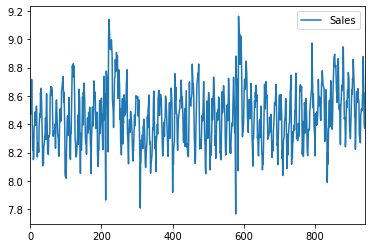

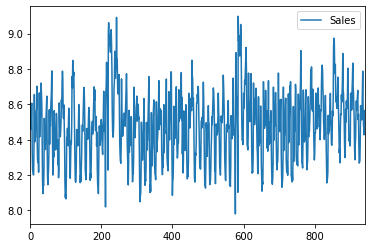

In [159]:
train_val1.plot.line()
#print('train1:',train_val1)
train_val2.plot.line()
#print('train2:',train_val2)

In [176]:
X_test['StateHoliday'] = lbl.fit_transform(X_test['StateHoliday'].astype(str))#将提示的包含错误数据类型这一列进行转换
X_test['Assortment'] = lbl.fit_transform(X_test['Assortment'].astype(str))#将提示的包含错误数据类型这一列进行转换
xgb_test_prod = xgb_model.predict(xgb.DMatrix(X_test))
xgb_test_prod = np.expm1(xgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = xgb_test_prod
#sub_df.to_csv("xgb_submission7.csv", index=False)

In [177]:
from sklearn.externals import joblib
joblib.dump(xgb_model, "yz_xgb_model.joblib")

['yz_xgb_model.joblib']

## Conclusion

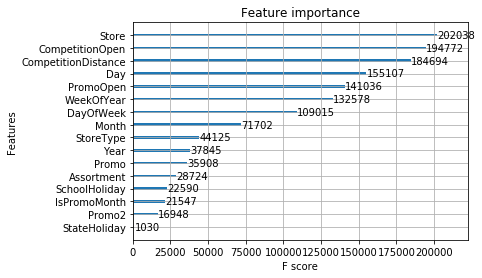

In [179]:
xgb.plot_importance(xgb_model)